# ECE 763 - Computer Vision - Project 03
## Babysitting the training of a Network

### mmsardes 

#### Import libraries
<p>Keras Sequential API was used to build the network. The CIFAR datasets was downloaded from keras datasets. 
Babysitting the training of a DNN is important as the final network performance depends a lot on how you set the hyper-parameters, how you initialize the weights, for how long you train the network etc. You don't want to over-train, or over-fit the model as it would lead to loss of generalization. General steps followed while training a DNN are 
1. Pre-process the Data and select Data Augmentation schemes. 
2. Choose architecture of the network 
3. Double check if the loss is reasonable. 
4. Hyperparameter tuning 
    </p>


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Reshape, BatchNormalization, Activation
from tensorflow.keras import optimizers, regularizers
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

#### Import and preprocess the data. 
<p> Preprocessing scheme was standard scaling by subtracting mean and dividing by the standard deviation. A basic preprocessing operation is done by subtracting the mean and dividing by the standard deviation over the dataset. This is basically zero centering the data. This makes the model less sensitive to small changes in weights and makes it easier to optimize. It also reduces the effect of outliers to some extent as the range of the data is restricted. </p>

In [4]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#conv to float
(X_train, y_train), (X_test, y_test)=(X_train.astype('float32'), y_train), (X_test.astype('float32'), y_test)
#class_names for cifar
class_name = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(class_name)
preprocess_flag=True

In [5]:
def preprocess_data(X_train, X_test):
    X_train-=np.mean(X_train,axis=0)
    X_test-=np.mean(X_test,axis=0)
    X_train/=np.std(X_train,axis=0)
    X_test/=np.std(X_test,axis=0)
    return X_train, X_test
if preprocess_flag==True:
    X_train, X_test=preprocess_data(X_train, X_test)

In [6]:
#shape of the image data. 
iRows,iCols=X_train[0].shape[0],X_train[0].shape[1]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

### Build the CNN 
<p> Here I have chosen a basic CNN with 3 layers. 32, 64, 128 filters in the three layers. All of them being 3x3 filters with a stride of 1. All the convolutional blocks are followed by 2x2 maxpool blocks. In the end the result is flattened and connected to a FCN with one hidden layer with 128 neurons and a softmax layer with 10 units as there are 10 classes in CIFAR. All the layers have 'relu' activations. The model is created using the Sequential API in Keras. Conditions are added to tweak the network if batchnormalization and dropout is desired.</p> 

In [8]:
#model hyperparam - Intial
LEARNING_RATE=1e-4
EPOCHS=10
L2_REG=0
BATCH_SIZE=32
DROPOUT=0.5

In [9]:
#Function to create model according to given conditions. 
def create_model(num_clases,L2_REG, drop=False, bnorm=False):
    model = Sequential()
    if drop==True:
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = (iRows, iCols,3)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
        model.add(Dropout(DROPOUT))
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
        model.add(Dropout(DROPOUT))

        model.add(Flatten())
        model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(Dense(units=num_classes,activation='softmax'))
    elif bnorm==True:
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same',input_shape = (iRows, iCols,3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
        
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Flatten())
        model.add(Dense(units = 128, kernel_regularizer=regularizers.l2(L2_REG), use_bias=False))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(units=num_classes,activation='softmax'))
    else:
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu',input_shape = (iRows, iCols,3)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))
    
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu',kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding='same'))

        model.add(Flatten())
        model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG), bias_regularizer=regularizers.l2(L2_REG)))
        model.add(Dense(units=num_classes,activation='softmax'))
    return model 

In [10]:
model=create_model(num_classes,L2_REG)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________

#### Compile and evaluate the Initial loss as a sanity check 
<p> The initial loss should come up to be around 2.3 for 10 classes with no regularization applied. </p>

In [11]:
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [12]:
model.evaluate(X_train,y_train)

37500/37500 [==============================] - 4s 110us/sample - loss: 2.3173 - sparse_categorical_accuracy: 0.1051s - loss: 2.3194 - sparse_categorical_accuracy: 0. - ETA: 5s - loss: 2.3183 - sparse_categorical_ - ETA: 1s - loss: 2.3176 - sparse_categorica


[2.317313319498698, 0.10514667]

#### Crank up regularization 
Sanity check: If we crank up the regularization we get a higher loss as expected. 

In [13]:
#model hyperparam
LEARNING_RATE=1e-4
EPOCHS=10
L2_REG=1e3

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.evaluate(X_train, y_train)

37500/37500 [==============================] - 3s 68us/sample - loss: 369745.2781 - sparse_categorical_accuracy: 0.1180s - loss: 369745.2783 - sparse_catego


[369745.27807666664, 0.118]

#### Try to overfit a small portion of data. 
We try to overfit the small portion of the data as a sanity check with no regularization and vanilla SGD optimizer. This ensures that our model is actually learning and the loss is going down. We verify this using the training accuracy (It should reach 100% theoretically). We can also see that the model reaches a very small loss as we reach the last epoch. That's a good sanity check. 

In [14]:
#model hyperparam
LEARNING_RATE=1e-3
EPOCHS=600
L2_REG=0

X_tiny=X_train[:20]
y_tiny=y_train[:20]


In [15]:
model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_tiny,y_tiny,batch_size=2,epochs=EPOCHS, verbose=1)

Train on 20 samples
Epoch 1/600
20/20 [==============================] - 0s 14ms/sample - loss: 2.2464 - sparse_categorical_accuracy: 0.1000
Epoch 2/600
20/20 [==============================] - 0s 181us/sample - loss: 2.2363 - sparse_categorical_accuracy: 0.1000
Epoch 3/600
20/20 [==============================] - 0s 130us/sample - loss: 2.2263 - sparse_categorical_accuracy: 0.1000
Epoch 4/600
20/20 [==============================] - 0s 178us/sample - loss: 2.2166 - sparse_categorical_accuracy: 0.1000
Epoch 5/600
20/20 [==============================] - 0s 175us/sample - loss: 2.2072 - sparse_categorical_accuracy: 0.1000
Epoch 6/600
20/20 [==============================] - 0s 181us/sample - loss: 2.1980 - sparse_categorical_accuracy: 0.1500
Epoch 7/600
20/20 [==============================] - 0s 249us/sample - loss: 2.1890 - sparse_categorical_accuracy: 0.1000
Epoch 8/600
20/20 [==============================] - 0s 186us/sample - loss: 2.1802 - sparse_categorical_accuracy: 0.1000
Epoch

Epoch 68/600
20/20 [==============================] - 0s 196us/sample - loss: 1.7978 - sparse_categorical_accuracy: 0.5000
Epoch 69/600
20/20 [==============================] - 0s 150us/sample - loss: 1.7929 - sparse_categorical_accuracy: 0.5000
Epoch 70/600
20/20 [==============================] - 0s 190us/sample - loss: 1.7880 - sparse_categorical_accuracy: 0.5000
Epoch 71/600
20/20 [==============================] - 0s 203us/sample - loss: 1.7830 - sparse_categorical_accuracy: 0.5000
Epoch 72/600
20/20 [==============================] - 0s 167us/sample - loss: 1.7780 - sparse_categorical_accuracy: 0.5000
Epoch 73/600
20/20 [==============================] - 0s 189us/sample - loss: 1.7731 - sparse_categorical_accuracy: 0.5000
Epoch 74/600
20/20 [==============================] - 0s 223us/sample - loss: 1.7682 - sparse_categorical_accuracy: 0.5000
Epoch 75/600
20/20 [==============================] - 0s 207us/sample - loss: 1.7634 - sparse_categorical_accuracy: 0.5000
Epoch 76/600
20/

Epoch 135/600
20/20 [==============================] - 0s 199us/sample - loss: 1.5231 - sparse_categorical_accuracy: 0.5000
Epoch 136/600
20/20 [==============================] - 0s 152us/sample - loss: 1.5195 - sparse_categorical_accuracy: 0.5000
Epoch 137/600
20/20 [==============================] - 0s 207us/sample - loss: 1.5159 - sparse_categorical_accuracy: 0.5000
Epoch 138/600
20/20 [==============================] - 0s 171us/sample - loss: 1.5123 - sparse_categorical_accuracy: 0.5000
Epoch 139/600
20/20 [==============================] - 0s 414us/sample - loss: 1.5087 - sparse_categorical_accuracy: 0.5000
Epoch 140/600
20/20 [==============================] - 0s 230us/sample - loss: 1.5051 - sparse_categorical_accuracy: 0.5000
Epoch 141/600
20/20 [==============================] - 0s 199us/sample - loss: 1.5015 - sparse_categorical_accuracy: 0.5000
Epoch 142/600
20/20 [==============================] - 0s 198us/sample - loss: 1.4979 - sparse_categorical_accuracy: 0.5000
Epoch 14

Epoch 202/600
20/20 [==============================] - 0s 244us/sample - loss: 1.2819 - sparse_categorical_accuracy: 0.6000
Epoch 203/600
20/20 [==============================] - 0s 186us/sample - loss: 1.2783 - sparse_categorical_accuracy: 0.6000
Epoch 204/600
20/20 [==============================] - 0s 211us/sample - loss: 1.2747 - sparse_categorical_accuracy: 0.6000
Epoch 205/600
20/20 [==============================] - 0s 203us/sample - loss: 1.2711 - sparse_categorical_accuracy: 0.6000
Epoch 206/600
20/20 [==============================] - 0s 197us/sample - loss: 1.2675 - sparse_categorical_accuracy: 0.6000
Epoch 207/600
20/20 [==============================] - 0s 175us/sample - loss: 1.2639 - sparse_categorical_accuracy: 0.6000
Epoch 208/600
20/20 [==============================] - 0s 180us/sample - loss: 1.2603 - sparse_categorical_accuracy: 0.6000
Epoch 209/600
20/20 [==============================] - 0s 175us/sample - loss: 1.2567 - sparse_categorical_accuracy: 0.6000
Epoch 21

Epoch 269/600
20/20 [==============================] - 0s 199us/sample - loss: 1.0438 - sparse_categorical_accuracy: 0.7000
Epoch 270/600
20/20 [==============================] - 0s 227us/sample - loss: 1.0403 - sparse_categorical_accuracy: 0.7000
Epoch 271/600
20/20 [==============================] - 0s 163us/sample - loss: 1.0369 - sparse_categorical_accuracy: 0.7000
Epoch 272/600
20/20 [==============================] - 0s 187us/sample - loss: 1.0334 - sparse_categorical_accuracy: 0.7000
Epoch 273/600
20/20 [==============================] - 0s 200us/sample - loss: 1.0299 - sparse_categorical_accuracy: 0.7000
Epoch 274/600
20/20 [==============================] - 0s 218us/sample - loss: 1.0264 - sparse_categorical_accuracy: 0.7000
Epoch 275/600
20/20 [==============================] - 0s 208us/sample - loss: 1.0230 - sparse_categorical_accuracy: 0.7000
Epoch 276/600
20/20 [==============================] - 0s 163us/sample - loss: 1.0195 - sparse_categorical_accuracy: 0.7000
Epoch 27

Epoch 335/600
20/20 [==============================] - 0s 205us/sample - loss: 0.8269 - sparse_categorical_accuracy: 0.7000
Epoch 336/600
20/20 [==============================] - 0s 225us/sample - loss: 0.8238 - sparse_categorical_accuracy: 0.7000
Epoch 337/600
20/20 [==============================] - 0s 262us/sample - loss: 0.8207 - sparse_categorical_accuracy: 0.7000
Epoch 338/600
20/20 [==============================] - 0s 172us/sample - loss: 0.8177 - sparse_categorical_accuracy: 0.7000
Epoch 339/600
20/20 [==============================] - 0s 199us/sample - loss: 0.8146 - sparse_categorical_accuracy: 0.7000
Epoch 340/600
20/20 [==============================] - 0s 190us/sample - loss: 0.8116 - sparse_categorical_accuracy: 0.7000
Epoch 341/600
20/20 [==============================] - 0s 203us/sample - loss: 0.8086 - sparse_categorical_accuracy: 0.7000
Epoch 342/600
20/20 [==============================] - 0s 180us/sample - loss: 0.8055 - sparse_categorical_accuracy: 0.7000
Epoch 34

Epoch 402/600
20/20 [==============================] - 0s 214us/sample - loss: 0.6361 - sparse_categorical_accuracy: 0.8500
Epoch 403/600
20/20 [==============================] - 0s 240us/sample - loss: 0.6335 - sparse_categorical_accuracy: 0.8500
Epoch 404/600
20/20 [==============================] - 0s 213us/sample - loss: 0.6310 - sparse_categorical_accuracy: 0.8500
Epoch 405/600
20/20 [==============================] - 0s 194us/sample - loss: 0.6284 - sparse_categorical_accuracy: 0.8500
Epoch 406/600
20/20 [==============================] - 0s 208us/sample - loss: 0.6258 - sparse_categorical_accuracy: 0.9000
Epoch 407/600
20/20 [==============================] - 0s 216us/sample - loss: 0.6233 - sparse_categorical_accuracy: 0.9000
Epoch 408/600
20/20 [==============================] - 0s 205us/sample - loss: 0.6207 - sparse_categorical_accuracy: 0.9000
Epoch 409/600
20/20 [==============================] - 0s 170us/sample - loss: 0.6181 - sparse_categorical_accuracy: 0.9000
Epoch 41

Epoch 469/600
20/20 [==============================] - 0s 161us/sample - loss: 0.4838 - sparse_categorical_accuracy: 0.9500
Epoch 470/600
20/20 [==============================] - 0s 235us/sample - loss: 0.4819 - sparse_categorical_accuracy: 0.9500
Epoch 471/600
20/20 [==============================] - 0s 213us/sample - loss: 0.4800 - sparse_categorical_accuracy: 0.9500
Epoch 472/600
20/20 [==============================] - 0s 234us/sample - loss: 0.4781 - sparse_categorical_accuracy: 0.9500
Epoch 473/600
20/20 [==============================] - 0s 196us/sample - loss: 0.4761 - sparse_categorical_accuracy: 0.9500
Epoch 474/600
20/20 [==============================] - 0s 178us/sample - loss: 0.4741 - sparse_categorical_accuracy: 0.9500
Epoch 475/600
20/20 [==============================] - 0s 203us/sample - loss: 0.4723 - sparse_categorical_accuracy: 0.9500
Epoch 476/600
20/20 [==============================] - 0s 176us/sample - loss: 0.4703 - sparse_categorical_accuracy: 0.9500
Epoch 47

Epoch 536/600
20/20 [==============================] - 0s 199us/sample - loss: 0.3726 - sparse_categorical_accuracy: 0.9500
Epoch 537/600
20/20 [==============================] - 0s 199us/sample - loss: 0.3712 - sparse_categorical_accuracy: 0.9500
Epoch 538/600
20/20 [==============================] - 0s 229us/sample - loss: 0.3698 - sparse_categorical_accuracy: 0.9500
Epoch 539/600
20/20 [==============================] - 0s 182us/sample - loss: 0.3685 - sparse_categorical_accuracy: 0.9500
Epoch 540/600
20/20 [==============================] - 0s 243us/sample - loss: 0.3672 - sparse_categorical_accuracy: 0.9500
Epoch 541/600
20/20 [==============================] - 0s 191us/sample - loss: 0.3658 - sparse_categorical_accuracy: 0.9500
Epoch 542/600
20/20 [==============================] - 0s 248us/sample - loss: 0.3645 - sparse_categorical_accuracy: 0.9500
Epoch 543/600
20/20 [==============================] - 0s 199us/sample - loss: 0.3632 - sparse_categorical_accuracy: 0.9500
Epoch 54

In [16]:
#Function for plotting loss and accuracy curves from the history variable. 
def plot_curves(history):
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

#### Start with small regularization and find a Learning rate that makes the loss go down 

We start with a small regularization and try to find a learning rate that makes the loss go down. 
We can observe here that the loss is not going down. As we can see in curves below the learning rate is so small that the model is actually not learning! The validation accuracy is still around 10% owing to the random guess. Remember that the softmax function is used at the end of the network for the actual 'classification' purposes. 

In [22]:
LEARNING_RATE=1e-6
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 5s 129us/sample - loss: 2.3243 - sparse_categorical_accuracy: 0.1034 - val_loss: 2.3262 - val_sparse_categorical_accuracy: 0.1002
Epoch 2/10
37500/37500 [==============================] - 5s 123us/sample - loss: 2.3235 - sparse_categorical_accuracy: 0.1038 - val_loss: 2.3254 - val_sparse_categorical_accuracy: 0.1007
Epoch 3/10
37500/37500 [==============================] - 5s 123us/sample - loss: 2.3227 - sparse_categorical_accuracy: 0.1043 - val_loss: 2.3246 - val_sparse_categorical_accuracy: 0.1018
Epoch 4/10
37500/37500 [==============================] - 5s 125us/sample - loss: 2.3220 - sparse_categorical_accuracy: 0.1046 - val_loss: 2.3239 - val_sparse_categorical_accuracy: 0.1017
Epoch 5/10
37500/37500 [==============================] - 5s 125us/sample - loss: 2.3213 - sparse_categorical_accuracy: 0.1050 - val_loss: 2.3231 - val_sparse_categorical_accuracy: 0.1017
Epoch 6/10

#### Very high Learning Rate - Loss exploding

We can now try a higher learning rate. We set the learning rate to 1e6. As we can see in the curves below the cost is so high that the loss is exploding. It is because the weights are updated by a huge number. Trying to find the optimum learning rate is very important. 

In [23]:
LEARNING_RATE=1e5
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 5s 131us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 2/10
37500/37500 [==============================] - 5s 124us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 3/10
37500/37500 [==============================] - 5s 122us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 4/10
37500/37500 [==============================] - 5s 124us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 5/10
37500/37500 [==============================] - 5s 122us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 6/10
37500/37500 [================

#### Crank up the Learning rate to check if the loss still explodes. 

We can keep trying values for which the loss will go down, but that is a trial and error method. We can adopt a cross validation strategy where we try different learning rates and regularizations in a fixed range and choose the combination that gives the best performance on the model. We can see here that the loss is still exploding for an increased LR. 
The learning rate is generally selected between 1e-3, 1e-4

In [32]:
LEARNING_RATE=0.4825
EPOCHS=10
L2_REG=1e-6

model=create_model(num_classes,L2_REG)
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,  validation_data=(X_val,y_val))

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 5s 146us/sample - loss: 2.1148 - sparse_categorical_accuracy: 0.2051 - val_loss: 1.8623 - val_sparse_categorical_accuracy: 0.3003
Epoch 2/10
37500/37500 [==============================] - 5s 133us/sample - loss: nan - sparse_categorical_accuracy: 0.1827 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 3/10
37500/37500 [==============================] - 5s 134us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 4/10
37500/37500 [==============================] - 5s 136us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 5/10
37500/37500 [==============================] - 5s 131us/sample - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0992
Epoch 6/10
37500/37500 [==========

### Hyper parameter Tuning
To find the optimum learning rate and regularization to apply, we first go through a few epochs to get a rough idea of how the params work and then move on to the second stage, where we have a longer run time and a finer search. 

#### Coarse Search
For coarse search we take a random value of the learning rate between 1e-3 and 1e-6 and a random value for regularization. As seen in we can see the top 10 performers from the coarse search strategy, we  can  see  that  the  learning  ratesare restricted within the range 1e-3 and 1e-4 and the regularization between 1e-5 and 1. Thus, we narrow down the range andperform a finer search for a longer time, i.e. increase the number of epochs

In [33]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(100)):
    lr = 10**np.random.uniform(-3,-6)
    l2_reg = 10**np.random.uniform(-5, 1)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=5, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)

  0%|          | 0/100 [00:00<?, ?it/s]

Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 143us/sample - loss: 2.1678 - sparse_categorical_accuracy: 0.2259 - val_loss: 2.0512 - val_sparse_categorical_accuracy: 0.2704
Epoch 2/5
37500/37500 [==============================] - 5s 130us/sample - loss: 1.9566 - sparse_categorical_accuracy: 0.3161 - val_loss: 1.8828 - val_sparse_categorical_accuracy: 0.3415
Epoch 3/5
37500/37500 [==============================] - 5s 129us/sample - loss: 1.8110 - sparse_categorical_accuracy: 0.3677 - val_loss: 1.7715 - val_sparse_categorical_accuracy: 0.3769
Epoch 4/5
37500/37500 [==============================] - 5s 129us/sample - loss: 1.7045 - sparse_categorical_accuracy: 0.4033 - val_loss: 1.6665 - val_sparse_categorical_accuracy: 0.4150
Epoch 5/5
37500/37500 [==============================] - 5s 131us/sample - loss: 1.6172 - sparse_categorical_accuracy: 0.4338 - val_loss: 1.5963 - val_sparse_categorical_accuracy: 0.4356


  1%|          | 1/100 [00:25<42:09, 25.55s/it]

0.4356 0.000964651669434161 3.9585137634618574e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 151us/sample - loss: 196.4742 - sparse_categorical_accuracy: 0.0897 - val_loss: 196.1994 - val_sparse_categorical_accuracy: 0.0938
Epoch 2/5
37500/37500 [==============================] - 5s 133us/sample - loss: 195.9222 - sparse_categorical_accuracy: 0.0905 - val_loss: 195.6481 - val_sparse_categorical_accuracy: 0.0941
Epoch 3/5
37500/37500 [==============================] - 5s 131us/sample - loss: 195.3718 - sparse_categorical_accuracy: 0.0911 - val_loss: 195.0985 - val_sparse_categorical_accuracy: 0.0945
Epoch 4/5
37500/37500 [==============================] - 5s 134us/sample - loss: 194.8229 - sparse_categorical_accuracy: 0.0911 - val_loss: 194.5504 - val_sparse_categorical_accuracy: 0.0934
Epoch 5/5
37500/37500 [==============================] - 5s 138us/sample - loss: 194.2757 - sparse_categorical_accuracy: 0.0921 - val_l

  2%|▏         | 2/100 [00:52<42:13, 25.85s/it]

0.09352 1.1473973163643606e-06 0.5280101167034242
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 5s 146us/sample - loss: 2.4907 - sparse_categorical_accuracy: 0.1059 - val_loss: 2.4813 - val_sparse_categorical_accuracy: 0.1098
Epoch 2/5
37500/37500 [==============================] - 5s 130us/sample - loss: 2.4734 - sparse_categorical_accuracy: 0.1122 - val_loss: 2.4669 - val_sparse_categorical_accuracy: 0.1150
Epoch 3/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.4607 - sparse_categorical_accuracy: 0.1216 - val_loss: 2.4560 - val_sparse_categorical_accuracy: 0.1260
Epoch 4/5
37500/37500 [==============================] - 5s 131us/sample - loss: 2.4509 - sparse_categorical_accuracy: 0.1330 - val_loss: 2.4473 - val_sparse_categorical_accuracy: 0.1342
Epoch 5/5
37500/37500 [==============================] - 5s 130us/sample - loss: 2.4428 - sparse_categorical_accuracy: 0.1451 - val_loss: 2.4400 - val_s

  3%|▎         | 3/100 [01:17<41:45, 25.83s/it]

0.15024 1.5044773721612762e-05 0.00042390096926228464
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 148us/sample - loss: 2.3356 - sparse_categorical_accuracy: 0.0997 - val_loss: 2.3340 - val_sparse_categorical_accuracy: 0.0981
Epoch 2/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.3318 - sparse_categorical_accuracy: 0.1007 - val_loss: 2.3303 - val_sparse_categorical_accuracy: 0.0985
Epoch 3/5
37500/37500 [==============================] - 5s 131us/sample - loss: 2.3283 - sparse_categorical_accuracy: 0.1021 - val_loss: 2.3270 - val_sparse_categorical_accuracy: 0.0986
Epoch 4/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.3252 - sparse_categorical_accuracy: 0.1035 - val_loss: 2.3241 - val_sparse_categorical_accuracy: 0.0996
Epoch 5/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.3223 - sparse_categorical_accuracy: 0.1046 - val_loss: 2.3213 - v

  4%|▍         | 4/100 [01:43<41:27, 25.91s/it]

0.10112 1.4032123064585471e-05 4.354653833347733e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 147us/sample - loss: 2.5644 - sparse_categorical_accuracy: 0.1808 - val_loss: 2.5173 - val_sparse_categorical_accuracy: 0.2220
Epoch 2/5
37500/37500 [==============================] - 5s 134us/sample - loss: 2.4597 - sparse_categorical_accuracy: 0.2534 - val_loss: 2.4023 - val_sparse_categorical_accuracy: 0.2733
Epoch 3/5
37500/37500 [==============================] - 5s 131us/sample - loss: 2.3390 - sparse_categorical_accuracy: 0.2975 - val_loss: 2.2896 - val_sparse_categorical_accuracy: 0.3061
Epoch 4/5
37500/37500 [==============================] - 5s 130us/sample - loss: 2.2377 - sparse_categorical_accuracy: 0.3232 - val_loss: 2.2059 - val_sparse_categorical_accuracy: 0.3247
Epoch 5/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.1656 - sparse_categorical_accuracy: 0.3440 - val_loss: 2.1491 - va

  5%|▌         | 5/100 [02:10<41:06, 25.97s/it]

0.34536 0.0003841847995263698 0.0008248627639668004
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 148us/sample - loss: 18.5547 - sparse_categorical_accuracy: 0.1133 - val_loss: 18.3409 - val_sparse_categorical_accuracy: 0.1356
Epoch 2/5
37500/37500 [==============================] - 5s 133us/sample - loss: 18.1352 - sparse_categorical_accuracy: 0.1534 - val_loss: 17.9333 - val_sparse_categorical_accuracy: 0.1754
Epoch 3/5
37500/37500 [==============================] - 5s 136us/sample - loss: 17.7333 - sparse_categorical_accuracy: 0.1885 - val_loss: 17.5373 - val_sparse_categorical_accuracy: 0.2074
Epoch 4/5
37500/37500 [==============================] - 5s 133us/sample - loss: 17.3425 - sparse_categorical_accuracy: 0.2182 - val_loss: 17.1519 - val_sparse_categorical_accuracy: 0.2301
Epoch 5/5
37500/37500 [==============================] - 5s 134us/sample - loss: 16.9608 - sparse_categorical_accuracy: 0.2399 - val_loss: 16.

  6%|▌         | 6/100 [02:36<40:55, 26.13s/it]

0.24544 0.00011603662609640516 0.04468582342314639
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 150us/sample - loss: 2.3853 - sparse_categorical_accuracy: 0.1187 - val_loss: 2.3844 - val_sparse_categorical_accuracy: 0.1147
Epoch 2/5
37500/37500 [==============================] - 5s 134us/sample - loss: 2.3845 - sparse_categorical_accuracy: 0.1193 - val_loss: 2.3835 - val_sparse_categorical_accuracy: 0.1163
Epoch 3/5
37500/37500 [==============================] - 5s 133us/sample - loss: 2.3836 - sparse_categorical_accuracy: 0.1200 - val_loss: 2.3827 - val_sparse_categorical_accuracy: 0.1169
Epoch 4/5
37500/37500 [==============================] - 5s 134us/sample - loss: 2.3828 - sparse_categorical_accuracy: 0.1204 - val_loss: 2.3820 - val_sparse_categorical_accuracy: 0.1177
Epoch 5/5
37500/37500 [==============================] - 5s 133us/sample - loss: 2.3820 - sparse_categorical_accuracy: 0.1215 - val_loss: 2.3812 - val_

  7%|▋         | 7/100 [03:03<40:43, 26.28s/it]

0.11856 2.0088667119479095e-06 0.00019084992504096593
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 151us/sample - loss: 8.5161 - sparse_categorical_accuracy: 0.1251 - val_loss: 8.4426 - val_sparse_categorical_accuracy: 0.1500
Epoch 2/5
37500/37500 [==============================] - 5s 135us/sample - loss: 8.3770 - sparse_categorical_accuracy: 0.1815 - val_loss: 8.3137 - val_sparse_categorical_accuracy: 0.2050
Epoch 3/5
37500/37500 [==============================] - 5s 139us/sample - loss: 8.2454 - sparse_categorical_accuracy: 0.2262 - val_loss: 8.1812 - val_sparse_categorical_accuracy: 0.2458
Epoch 4/5
37500/37500 [==============================] - 5s 136us/sample - loss: 8.1087 - sparse_categorical_accuracy: 0.2563 - val_loss: 8.0434 - val_sparse_categorical_accuracy: 0.2638
Epoch 5/5
37500/37500 [==============================] - 5s 138us/sample - loss: 7.9675 - sparse_categorical_accuracy: 0.2749 - val_loss: 7.9031 - v

  8%|▊         | 8/100 [03:30<40:38, 26.50s/it]

0.27824 0.00019382277102167732 0.016932326511822225
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 150us/sample - loss: 2.3006 - sparse_categorical_accuracy: 0.1029 - val_loss: 2.2897 - val_sparse_categorical_accuracy: 0.1143
Epoch 2/5
37500/37500 [==============================] - 5s 132us/sample - loss: 2.2803 - sparse_categorical_accuracy: 0.1278 - val_loss: 2.2729 - val_sparse_categorical_accuracy: 0.1389
Epoch 3/5
37500/37500 [==============================] - 5s 133us/sample - loss: 2.2632 - sparse_categorical_accuracy: 0.1571 - val_loss: 2.2562 - val_sparse_categorical_accuracy: 0.1666
Epoch 4/5
37500/37500 [==============================] - 5s 133us/sample - loss: 2.2452 - sparse_categorical_accuracy: 0.1822 - val_loss: 2.2380 - val_sparse_categorical_accuracy: 0.1927
Epoch 5/5
37500/37500 [==============================] - 5s 133us/sample - loss: 2.2254 - sparse_categorical_accuracy: 0.2066 - val_loss: 2.2176 - val

  9%|▉         | 9/100 [03:56<40:11, 26.50s/it]

0.21216 0.00010696344535474933 1.525994848654146e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 155us/sample - loss: 2.3486 - sparse_categorical_accuracy: 0.1045 - val_loss: 2.3267 - val_sparse_categorical_accuracy: 0.1477
Epoch 2/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.3105 - sparse_categorical_accuracy: 0.1741 - val_loss: 2.2942 - val_sparse_categorical_accuracy: 0.1961
Epoch 3/5
37500/37500 [==============================] - 5s 136us/sample - loss: 2.2756 - sparse_categorical_accuracy: 0.2139 - val_loss: 2.2574 - val_sparse_categorical_accuracy: 0.2246
Epoch 4/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.2356 - sparse_categorical_accuracy: 0.2347 - val_loss: 2.2159 - val_sparse_categorical_accuracy: 0.2430
Epoch 5/5
37500/37500 [==============================] - 5s 138us/sample - loss: 2.1921 - sparse_categorical_accuracy: 0.2483 - val_loss: 2.1726 - va

 10%|█         | 10/100 [04:24<40:09, 26.77s/it]

0.25552 0.0001850006583602752 0.00014773909264388925
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 153us/sample - loss: 4.9639 - sparse_categorical_accuracy: 0.0985 - val_loss: 4.9587 - val_sparse_categorical_accuracy: 0.0993
Epoch 2/5
37500/37500 [==============================] - 5s 137us/sample - loss: 4.9532 - sparse_categorical_accuracy: 0.0997 - val_loss: 4.9489 - val_sparse_categorical_accuracy: 0.0992
Epoch 3/5
37500/37500 [==============================] - 5s 137us/sample - loss: 4.9442 - sparse_categorical_accuracy: 0.1008 - val_loss: 4.9404 - val_sparse_categorical_accuracy: 0.1007
Epoch 4/5
37500/37500 [==============================] - 5s 136us/sample - loss: 4.9362 - sparse_categorical_accuracy: 0.1010 - val_loss: 4.9329 - val_sparse_categorical_accuracy: 0.1013
Epoch 5/5
37500/37500 [==============================] - 5s 138us/sample - loss: 4.9291 - sparse_categorical_accuracy: 0.1022 - val_loss: 4.9262 - va

 11%|█         | 11/100 [04:51<39:55, 26.91s/it]

0.1028 9.727962797494415e-06 0.007073586691929423
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 156us/sample - loss: 332.1692 - sparse_categorical_accuracy: 0.1207 - val_loss: 295.3958 - val_sparse_categorical_accuracy: 0.1305
Epoch 2/5
37500/37500 [==============================] - 5s 138us/sample - loss: 263.9506 - sparse_categorical_accuracy: 0.1396 - val_loss: 234.7856 - val_sparse_categorical_accuracy: 0.1455
Epoch 3/5
37500/37500 [==============================] - 5s 138us/sample - loss: 209.8445 - sparse_categorical_accuracy: 0.1530 - val_loss: 186.7119 - val_sparse_categorical_accuracy: 0.1573
Epoch 4/5
37500/37500 [==============================] - 5s 138us/sample - loss: 166.9289 - sparse_categorical_accuracy: 0.1636 - val_loss: 148.5806 - val_sparse_categorical_accuracy: 0.1659
Epoch 5/5
37500/37500 [==============================] - 5s 137us/sample - loss: 132.8885 - sparse_categorical_accuracy: 0.1706 - val_lo

 12%|█▏        | 12/100 [05:18<39:44, 27.09s/it]

0.17352 4.9357645350018835e-05 1.001139705339608
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 158us/sample - loss: 3.2959 - sparse_categorical_accuracy: 0.1037 - val_loss: 3.2847 - val_sparse_categorical_accuracy: 0.1094
Epoch 2/5
37500/37500 [==============================] - 5s 140us/sample - loss: 3.2791 - sparse_categorical_accuracy: 0.1101 - val_loss: 3.2713 - val_sparse_categorical_accuracy: 0.1202
Epoch 3/5
37500/37500 [==============================] - 5s 139us/sample - loss: 3.2673 - sparse_categorical_accuracy: 0.1228 - val_loss: 3.2613 - val_sparse_categorical_accuracy: 0.1389
Epoch 4/5
37500/37500 [==============================] - 5s 142us/sample - loss: 3.2580 - sparse_categorical_accuracy: 0.1443 - val_loss: 3.2531 - val_sparse_categorical_accuracy: 0.1578
Epoch 5/5
37500/37500 [==============================] - 5s 138us/sample - loss: 3.2502 - sparse_categorical_accuracy: 0.1611 - val_loss: 3.2461 - val_sp

 13%|█▎        | 13/100 [05:46<39:38, 27.34s/it]

0.17128 2.468824236730592e-05 0.0026230542207942987
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 158us/sample - loss: 3.6293 - sparse_categorical_accuracy: 0.1081 - val_loss: 3.6254 - val_sparse_categorical_accuracy: 0.1081
Epoch 2/5
37500/37500 [==============================] - 5s 139us/sample - loss: 3.6217 - sparse_categorical_accuracy: 0.1117 - val_loss: 3.6187 - val_sparse_categorical_accuracy: 0.1104
Epoch 3/5
37500/37500 [==============================] - 5s 138us/sample - loss: 3.6152 - sparse_categorical_accuracy: 0.1166 - val_loss: 3.6129 - val_sparse_categorical_accuracy: 0.1144
Epoch 4/5
37500/37500 [==============================] - 5s 140us/sample - loss: 3.6094 - sparse_categorical_accuracy: 0.1217 - val_loss: 3.6076 - val_sparse_categorical_accuracy: 0.1189
Epoch 5/5
37500/37500 [==============================] - 5s 137us/sample - loss: 3.6042 - sparse_categorical_accuracy: 0.1281 - val_loss: 3.6029 - val

 14%|█▍        | 14/100 [06:14<39:21, 27.45s/it]

0.124 1.4209551349986519e-05 0.00355893280700234
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 161us/sample - loss: 3.5277 - sparse_categorical_accuracy: 0.1709 - val_loss: 3.4881 - val_sparse_categorical_accuracy: 0.2193
Epoch 2/5
37500/37500 [==============================] - 5s 143us/sample - loss: 3.4356 - sparse_categorical_accuracy: 0.2415 - val_loss: 3.3900 - val_sparse_categorical_accuracy: 0.2537
Epoch 3/5
37500/37500 [==============================] - 5s 139us/sample - loss: 3.3340 - sparse_categorical_accuracy: 0.2653 - val_loss: 3.2957 - val_sparse_categorical_accuracy: 0.2714
Epoch 4/5
37500/37500 [==============================] - 5s 140us/sample - loss: 3.2472 - sparse_categorical_accuracy: 0.2886 - val_loss: 3.2188 - val_sparse_categorical_accuracy: 0.2890
Epoch 5/5
37500/37500 [==============================] - 5s 141us/sample - loss: 3.1719 - sparse_categorical_accuracy: 0.3131 - val_loss: 3.1472 - val_sp

 15%|█▌        | 15/100 [06:42<39:13, 27.69s/it]

0.3184 0.0003876357904310137 0.003416237458690826
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 160us/sample - loss: 3.2182 - sparse_categorical_accuracy: 0.0796 - val_loss: 3.2171 - val_sparse_categorical_accuracy: 0.0794
Epoch 2/5
37500/37500 [==============================] - 5s 141us/sample - loss: 3.2162 - sparse_categorical_accuracy: 0.0804 - val_loss: 3.2151 - val_sparse_categorical_accuracy: 0.0815
Epoch 3/5
37500/37500 [==============================] - 5s 142us/sample - loss: 3.2142 - sparse_categorical_accuracy: 0.0817 - val_loss: 3.2132 - val_sparse_categorical_accuracy: 0.0822
Epoch 4/5
37500/37500 [==============================] - 5s 140us/sample - loss: 3.2124 - sparse_categorical_accuracy: 0.0830 - val_loss: 3.2114 - val_sparse_categorical_accuracy: 0.0828
Epoch 5/5
37500/37500 [==============================] - 5s 138us/sample - loss: 3.2106 - sparse_categorical_accuracy: 0.0837 - val_loss: 3.2097 - val_s

 16%|█▌        | 16/100 [07:10<38:57, 27.82s/it]

0.08376 1.3983415680883341e-06 0.002404787272206656
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 163us/sample - loss: 25.4767 - sparse_categorical_accuracy: 0.1014 - val_loss: 25.3717 - val_sparse_categorical_accuracy: 0.1033
Epoch 2/5
37500/37500 [==============================] - 5s 141us/sample - loss: 25.2758 - sparse_categorical_accuracy: 0.1094 - val_loss: 25.1771 - val_sparse_categorical_accuracy: 0.1178
Epoch 3/5
37500/37500 [==============================] - 5s 141us/sample - loss: 25.0845 - sparse_categorical_accuracy: 0.1258 - val_loss: 24.9888 - val_sparse_categorical_accuracy: 0.1418
Epoch 4/5
37500/37500 [==============================] - 5s 141us/sample - loss: 24.8979 - sparse_categorical_accuracy: 0.1414 - val_loss: 24.8039 - val_sparse_categorical_accuracy: 0.1560
Epoch 5/5
37500/37500 [==============================] - 5s 141us/sample - loss: 24.7141 - sparse_categorical_accuracy: 0.1497 - val_loss: 24.

 17%|█▋        | 17/100 [07:39<38:43, 27.99s/it]

0.16272 2.6550785995356316e-05 0.06299196594241435
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 165us/sample - loss: 3.4932 - sparse_categorical_accuracy: 0.0949 - val_loss: 3.4915 - val_sparse_categorical_accuracy: 0.0903
Epoch 2/5
37500/37500 [==============================] - 5s 144us/sample - loss: 3.4890 - sparse_categorical_accuracy: 0.0956 - val_loss: 3.4874 - val_sparse_categorical_accuracy: 0.0917
Epoch 3/5
37500/37500 [==============================] - 5s 143us/sample - loss: 3.4851 - sparse_categorical_accuracy: 0.0975 - val_loss: 3.4836 - val_sparse_categorical_accuracy: 0.0930
Epoch 4/5
37500/37500 [==============================] - 5s 144us/sample - loss: 3.4816 - sparse_categorical_accuracy: 0.0985 - val_loss: 3.4802 - val_sparse_categorical_accuracy: 0.0957
Epoch 5/5
37500/37500 [==============================] - 5s 144us/sample - loss: 3.4783 - sparse_categorical_accuracy: 0.1003 - val_loss: 3.4770 - val_

 18%|█▊        | 18/100 [08:08<38:36, 28.25s/it]

0.09968 7.604070096478901e-06 0.0031631635316854137
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 161us/sample - loss: 223.6120 - sparse_categorical_accuracy: 0.1206 - val_loss: 114.0850 - val_sparse_categorical_accuracy: 0.1363
Epoch 2/5
37500/37500 [==============================] - 5s 145us/sample - loss: 66.4376 - sparse_categorical_accuracy: 0.1496 - val_loss: 34.6987 - val_sparse_categorical_accuracy: 0.1632
Epoch 3/5
37500/37500 [==============================] - 5s 141us/sample - loss: 20.8899 - sparse_categorical_accuracy: 0.1847 - val_loss: 11.6914 - val_sparse_categorical_accuracy: 0.1156
Epoch 4/5
37500/37500 [==============================] - 5s 143us/sample - loss: 7.6894 - sparse_categorical_accuracy: 0.1061 - val_loss: 5.0235 - val_sparse_categorical_accuracy: 0.0990
Epoch 5/5
37500/37500 [==============================] - 5s 142us/sample - loss: 3.8637 - sparse_categorical_accuracy: 0.1006 - val_loss: 3.09

 19%|█▉        | 19/100 [08:36<38:18, 28.38s/it]

0.09776 0.0002521455196137213 1.0475697998690494
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 162us/sample - loss: 663.7172 - sparse_categorical_accuracy: 0.0973 - val_loss: 626.5040 - val_sparse_categorical_accuracy: 0.0986
Epoch 2/5
37500/37500 [==============================] - 5s 142us/sample - loss: 592.0988 - sparse_categorical_accuracy: 0.0977 - val_loss: 558.9176 - val_sparse_categorical_accuracy: 0.1006
Epoch 3/5
37500/37500 [==============================] - 5s 143us/sample - loss: 528.2392 - sparse_categorical_accuracy: 0.0996 - val_loss: 498.6521 - val_sparse_categorical_accuracy: 0.1014
Epoch 4/5
37500/37500 [==============================] - 5s 141us/sample - loss: 471.2960 - sparse_categorical_accuracy: 0.1018 - val_loss: 444.9133 - val_sparse_categorical_accuracy: 0.1028
Epoch 5/5
37500/37500 [==============================] - 5s 145us/sample - loss: 420.5195 - sparse_categorical_accuracy: 0.1031 - val_los

 20%|██        | 20/100 [09:05<37:57, 28.47s/it]

0.10632 1.2862936038948876e-05 1.9000978615935422
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 166us/sample - loss: 2.3241 - sparse_categorical_accuracy: 0.0951 - val_loss: 2.3135 - val_sparse_categorical_accuracy: 0.1004
Epoch 2/5
37500/37500 [==============================] - 5s 146us/sample - loss: 2.3011 - sparse_categorical_accuracy: 0.1151 - val_loss: 2.2949 - val_sparse_categorical_accuracy: 0.1265
Epoch 3/5
37500/37500 [==============================] - 6s 147us/sample - loss: 2.2847 - sparse_categorical_accuracy: 0.1446 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.1541
Epoch 4/5
37500/37500 [==============================] - 5s 145us/sample - loss: 2.2707 - sparse_categorical_accuracy: 0.1682 - val_loss: 2.2669 - val_sparse_categorical_accuracy: 0.1742
Epoch 5/5
37500/37500 [==============================] - 5s 146us/sample - loss: 2.2574 - sparse_categorical_accuracy: 0.1877 - val_loss: 2.2537 - val_s

 21%|██        | 21/100 [09:34<37:50, 28.74s/it]

0.192 5.603600864858877e-05 1.4375857644308472e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 171us/sample - loss: 2.3320 - sparse_categorical_accuracy: 0.0982 - val_loss: 2.3316 - val_sparse_categorical_accuracy: 0.1001
Epoch 2/5
37500/37500 [==============================] - 5s 145us/sample - loss: 2.3294 - sparse_categorical_accuracy: 0.1005 - val_loss: 2.3292 - val_sparse_categorical_accuracy: 0.1019
Epoch 3/5
37500/37500 [==============================] - 6s 149us/sample - loss: 2.3270 - sparse_categorical_accuracy: 0.1034 - val_loss: 2.3269 - val_sparse_categorical_accuracy: 0.1072
Epoch 4/5
37500/37500 [==============================] - 5s 145us/sample - loss: 2.3247 - sparse_categorical_accuracy: 0.1077 - val_loss: 2.3247 - val_sparse_categorical_accuracy: 0.1094
Epoch 5/5
37500/37500 [==============================] - 6s 148us/sample - loss: 2.3225 - sparse_categorical_accuracy: 0.1113 - val_loss: 2.3226 - val_

 22%|██▏       | 22/100 [10:04<37:44, 29.03s/it]

0.11208 4.542523157199087e-06 6.252533926068026e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 170us/sample - loss: 184.7621 - sparse_categorical_accuracy: 0.1108 - val_loss: 143.7531 - val_sparse_categorical_accuracy: 0.1270
Epoch 2/5
37500/37500 [==============================] - 6s 148us/sample - loss: 114.2210 - sparse_categorical_accuracy: 0.1348 - val_loss: 89.0736 - val_sparse_categorical_accuracy: 0.1442
Epoch 3/5
37500/37500 [==============================] - 6s 150us/sample - loss: 70.9593 - sparse_categorical_accuracy: 0.1471 - val_loss: 55.5339 - val_sparse_categorical_accuracy: 0.1533
Epoch 4/5
37500/37500 [==============================] - 6s 160us/sample - loss: 44.4219 - sparse_categorical_accuracy: 0.1653 - val_loss: 34.9591 - val_sparse_categorical_accuracy: 0.1799
Epoch 5/5
37500/37500 [==============================] - 6s 147us/sample - loss: 28.1422 - sparse_categorical_accuracy: 0.2025 - val_loss: 

 23%|██▎       | 23/100 [10:34<37:45, 29.42s/it]

0.22552 0.0001669466675681543 0.6243256036910368
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 170us/sample - loss: 273.9629 - sparse_categorical_accuracy: 0.1102 - val_loss: 272.8271 - val_sparse_categorical_accuracy: 0.1076
Epoch 2/5
37500/37500 [==============================] - 5s 144us/sample - loss: 271.6991 - sparse_categorical_accuracy: 0.1112 - val_loss: 270.5728 - val_sparse_categorical_accuracy: 0.1090
Epoch 3/5
37500/37500 [==============================] - 5s 144us/sample - loss: 269.4545 - sparse_categorical_accuracy: 0.1127 - val_loss: 268.3378 - val_sparse_categorical_accuracy: 0.1106
Epoch 4/5
37500/37500 [==============================] - 5s 145us/sample - loss: 267.2289 - sparse_categorical_accuracy: 0.1143 - val_loss: 266.1216 - val_sparse_categorical_accuracy: 0.1114
Epoch 5/5
37500/37500 [==============================] - 5s 146us/sample - loss: 265.0222 - sparse_categorical_accuracy: 0.1157 - val_los

 24%|██▍       | 24/100 [11:04<37:16, 29.43s/it]

0.11304 2.4105931773433393e-06 0.7390760270324491
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 6s 171us/sample - loss: 2.7614 - sparse_categorical_accuracy: 0.0797 - val_loss: 2.7520 - val_sparse_categorical_accuracy: 0.0766
Epoch 2/5
37500/37500 [==============================] - 6s 152us/sample - loss: 2.7442 - sparse_categorical_accuracy: 0.0806 - val_loss: 2.7377 - val_sparse_categorical_accuracy: 0.0816
Epoch 3/5
37500/37500 [==============================] - 6s 148us/sample - loss: 2.7319 - sparse_categorical_accuracy: 0.0867 - val_loss: 2.7270 - val_sparse_categorical_accuracy: 0.0910
Epoch 4/5
37500/37500 [==============================] - 6s 150us/sample - loss: 2.7223 - sparse_categorical_accuracy: 0.0986 - val_loss: 2.7182 - val_sparse_categorical_accuracy: 0.1070
Epoch 5/5
37500/37500 [==============================] - 6s 148us/sample - loss: 2.7142 - sparse_categorical_accuracy: 0.1124 - val_loss: 2.7106 - val_s

 25%|██▌       | 25/100 [11:34<37:06, 29.69s/it]

0.12152 2.2218493825427412e-05 0.0011422139842147219
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 176us/sample - loss: 8.3041 - sparse_categorical_accuracy: 0.0839 - val_loss: 8.2882 - val_sparse_categorical_accuracy: 0.0866
Epoch 2/5
37500/37500 [==============================] - 6s 152us/sample - loss: 8.2712 - sparse_categorical_accuracy: 0.0920 - val_loss: 8.2602 - val_sparse_categorical_accuracy: 0.0979
Epoch 3/5
37500/37500 [==============================] - 6s 150us/sample - loss: 8.2462 - sparse_categorical_accuracy: 0.1038 - val_loss: 8.2377 - val_sparse_categorical_accuracy: 0.1097
Epoch 4/5
37500/37500 [==============================] - 6s 151us/sample - loss: 8.2254 - sparse_categorical_accuracy: 0.1179 - val_loss: 8.2186 - val_sparse_categorical_accuracy: 0.1229
Epoch 5/5
37500/37500 [==============================] - 6s 151us/sample - loss: 8.2073 - sparse_categorical_accuracy: 0.1353 - val_loss: 8.2015 - va

 26%|██▌       | 26/100 [12:05<36:57, 29.97s/it]

0.13808 2.025916977249733e-05 0.01615789182858704
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 174us/sample - loss: 2.6904 - sparse_categorical_accuracy: 0.1026 - val_loss: 2.6916 - val_sparse_categorical_accuracy: 0.0986
Epoch 2/5
37500/37500 [==============================] - 6s 154us/sample - loss: 2.6870 - sparse_categorical_accuracy: 0.1040 - val_loss: 2.6883 - val_sparse_categorical_accuracy: 0.1009
Epoch 3/5
37500/37500 [==============================] - 6s 160us/sample - loss: 2.6839 - sparse_categorical_accuracy: 0.1053 - val_loss: 2.6853 - val_sparse_categorical_accuracy: 0.1030
Epoch 4/5
37500/37500 [==============================] - 6s 154us/sample - loss: 2.6810 - sparse_categorical_accuracy: 0.1073 - val_loss: 2.6825 - val_sparse_categorical_accuracy: 0.1044
Epoch 5/5
37500/37500 [==============================] - 6s 152us/sample - loss: 2.6783 - sparse_categorical_accuracy: 0.1091 - val_loss: 2.6798 - val_s

 27%|██▋       | 27/100 [12:36<36:54, 30.34s/it]

0.10648 5.585552683060652e-06 0.0009910662990293927
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 192us/sample - loss: 111.8441 - sparse_categorical_accuracy: 0.0995 - val_loss: 107.5836 - val_sparse_categorical_accuracy: 0.1085
Epoch 2/5
37500/37500 [==============================] - 6s 157us/sample - loss: 103.5532 - sparse_categorical_accuracy: 0.1244 - val_loss: 99.6235 - val_sparse_categorical_accuracy: 0.1431
Epoch 3/5
37500/37500 [==============================] - 6s 160us/sample - loss: 95.9015 - sparse_categorical_accuracy: 0.1513 - val_loss: 92.2714 - val_sparse_categorical_accuracy: 0.1646
Epoch 4/5
37500/37500 [==============================] - 6s 156us/sample - loss: 88.8321 - sparse_categorical_accuracy: 0.1675 - val_loss: 85.4775 - val_sparse_categorical_accuracy: 0.1745
Epoch 5/5
37500/37500 [==============================] - 6s 163us/sample - loss: 82.2986 - sparse_categorical_accuracy: 0.1754 - val_loss: 

 28%|██▊       | 28/100 [13:08<37:10, 30.98s/it]

0.1812 5.4098317879863887e-05 0.30939968375569865
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 181us/sample - loss: 84.8957 - sparse_categorical_accuracy: 0.0912 - val_loss: 84.4731 - val_sparse_categorical_accuracy: 0.0872
Epoch 2/5
37500/37500 [==============================] - 6s 160us/sample - loss: 84.0508 - sparse_categorical_accuracy: 0.0869 - val_loss: 83.6339 - val_sparse_categorical_accuracy: 0.0855
Epoch 3/5
37500/37500 [==============================] - 6s 163us/sample - loss: 83.2173 - sparse_categorical_accuracy: 0.0859 - val_loss: 82.8055 - val_sparse_categorical_accuracy: 0.0846
Epoch 4/5
37500/37500 [==============================] - 6s 154us/sample - loss: 82.3941 - sparse_categorical_accuracy: 0.0866 - val_loss: 81.9871 - val_sparse_categorical_accuracy: 0.0862
Epoch 5/5
37500/37500 [==============================] - 6s 154us/sample - loss: 81.5805 - sparse_categorical_accuracy: 0.0896 - val_loss: 81.17

 29%|██▉       | 29/100 [13:40<36:59, 31.26s/it]

0.09136 9.622462923895183e-06 0.22487389366269248
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 179us/sample - loss: 3.0968 - sparse_categorical_accuracy: 0.1001 - val_loss: 3.0969 - val_sparse_categorical_accuracy: 0.1010
Epoch 2/5
37500/37500 [==============================] - 6s 164us/sample - loss: 3.0953 - sparse_categorical_accuracy: 0.1006 - val_loss: 3.0954 - val_sparse_categorical_accuracy: 0.1015
Epoch 3/5
37500/37500 [==============================] - 6s 165us/sample - loss: 3.0938 - sparse_categorical_accuracy: 0.1002 - val_loss: 3.0940 - val_sparse_categorical_accuracy: 0.1012
Epoch 4/5
37500/37500 [==============================] - 6s 155us/sample - loss: 3.0924 - sparse_categorical_accuracy: 0.1006 - val_loss: 3.0926 - val_sparse_categorical_accuracy: 0.1016
Epoch 5/5
37500/37500 [==============================] - 6s 158us/sample - loss: 3.0910 - sparse_categorical_accuracy: 0.1012 - val_loss: 3.0912 - val_s

 30%|███       | 30/100 [14:13<36:50, 31.58s/it]

0.10168 3.186814800908145e-06 0.0021416990657933542
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 180us/sample - loss: 4.7699 - sparse_categorical_accuracy: 0.2038 - val_loss: 4.6369 - val_sparse_categorical_accuracy: 0.2678
Epoch 2/5
37500/37500 [==============================] - 6s 156us/sample - loss: 4.4923 - sparse_categorical_accuracy: 0.3050 - val_loss: 4.3785 - val_sparse_categorical_accuracy: 0.3255
Epoch 3/5
37500/37500 [==============================] - 6s 153us/sample - loss: 4.2804 - sparse_categorical_accuracy: 0.3516 - val_loss: 4.2089 - val_sparse_categorical_accuracy: 0.3610
Epoch 4/5
37500/37500 [==============================] - 6s 151us/sample - loss: 4.1250 - sparse_categorical_accuracy: 0.3834 - val_loss: 4.0646 - val_sparse_categorical_accuracy: 0.3882
Epoch 5/5
37500/37500 [==============================] - 6s 155us/sample - loss: 3.9881 - sparse_categorical_accuracy: 0.4120 - val_loss: 3.9360 - val

 31%|███       | 31/100 [14:44<36:13, 31.50s/it]

0.41608 0.0007819861280033422 0.007013919127532981
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 185us/sample - loss: 186.2096 - sparse_categorical_accuracy: 0.1041 - val_loss: 2.3037 - val_sparse_categorical_accuracy: 0.0984
Epoch 2/5
37500/37500 [==============================] - 6s 158us/sample - loss: 2.3027 - sparse_categorical_accuracy: 0.0982 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 3/5
37500/37500 [==============================] - 6s 157us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0995 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 4/5
37500/37500 [==============================] - 6s 155us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0990 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 5/5
37500/37500 [==============================] - 6s 158us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3026 - va

 32%|███▏      | 32/100 [15:16<35:51, 31.65s/it]

0.09776 0.00042941208368517473 7.256472414641624
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 181us/sample - loss: 3.7167 - sparse_categorical_accuracy: 0.1762 - val_loss: 3.6680 - val_sparse_categorical_accuracy: 0.2336
Epoch 2/5
37500/37500 [==============================] - 6s 157us/sample - loss: 3.6124 - sparse_categorical_accuracy: 0.2597 - val_loss: 3.5608 - val_sparse_categorical_accuracy: 0.2760
Epoch 3/5
37500/37500 [==============================] - 6s 154us/sample - loss: 3.5031 - sparse_categorical_accuracy: 0.2891 - val_loss: 3.4597 - val_sparse_categorical_accuracy: 0.2974
Epoch 4/5
37500/37500 [==============================] - 6s 154us/sample - loss: 3.4096 - sparse_categorical_accuracy: 0.3116 - val_loss: 3.3781 - val_sparse_categorical_accuracy: 0.3136
Epoch 5/5
37500/37500 [==============================] - 6s 156us/sample - loss: 3.3344 - sparse_categorical_accuracy: 0.3342 - val_loss: 3.3115 - val_sp

 33%|███▎      | 33/100 [15:48<35:20, 31.65s/it]

0.3352 0.00031356329326217766 0.003955478464591665
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 189us/sample - loss: 10.0441 - sparse_categorical_accuracy: 0.0883 - val_loss: 10.0436 - val_sparse_categorical_accuracy: 0.0856
Epoch 2/5
37500/37500 [==============================] - 6s 166us/sample - loss: 10.0401 - sparse_categorical_accuracy: 0.0901 - val_loss: 10.0396 - val_sparse_categorical_accuracy: 0.0873
Epoch 3/5
37500/37500 [==============================] - 6s 162us/sample - loss: 10.0362 - sparse_categorical_accuracy: 0.0924 - val_loss: 10.0357 - val_sparse_categorical_accuracy: 0.0907
Epoch 4/5
37500/37500 [==============================] - 6s 158us/sample - loss: 10.0324 - sparse_categorical_accuracy: 0.0954 - val_loss: 10.0319 - val_sparse_categorical_accuracy: 0.0940
Epoch 5/5
37500/37500 [==============================] - 6s 162us/sample - loss: 10.0287 - sparse_categorical_accuracy: 0.0974 - val_loss: 10.0

 34%|███▍      | 34/100 [16:21<35:14, 32.04s/it]

0.096 2.522734001584257e-06 0.020935841820015424
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 186us/sample - loss: 5.3374 - sparse_categorical_accuracy: 0.1033 - val_loss: 5.3216 - val_sparse_categorical_accuracy: 0.1081
Epoch 2/5
37500/37500 [==============================] - 6s 163us/sample - loss: 5.3130 - sparse_categorical_accuracy: 0.1101 - val_loss: 5.3019 - val_sparse_categorical_accuracy: 0.1219
Epoch 3/5
37500/37500 [==============================] - 6s 158us/sample - loss: 5.2951 - sparse_categorical_accuracy: 0.1221 - val_loss: 5.2862 - val_sparse_categorical_accuracy: 0.1322
Epoch 4/5
37500/37500 [==============================] - 6s 159us/sample - loss: 5.2802 - sparse_categorical_accuracy: 0.1360 - val_loss: 5.2724 - val_sparse_categorical_accuracy: 0.1460
Epoch 5/5
37500/37500 [==============================] - 6s 161us/sample - loss: 5.2667 - sparse_categorical_accuracy: 0.1500 - val_loss: 5.2597 - val_sp

 35%|███▌      | 35/100 [16:53<34:54, 32.22s/it]

0.15752 3.932727613585281e-05 0.008160266913780788
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 187us/sample - loss: 33.7130 - sparse_categorical_accuracy: 0.1805 - val_loss: 28.4008 - val_sparse_categorical_accuracy: 0.2374
Epoch 2/5
37500/37500 [==============================] - 6s 161us/sample - loss: 24.2080 - sparse_categorical_accuracy: 0.2514 - val_loss: 20.4837 - val_sparse_categorical_accuracy: 0.2663
Epoch 3/5
37500/37500 [==============================] - 6s 155us/sample - loss: 17.5425 - sparse_categorical_accuracy: 0.2811 - val_loss: 14.9436 - val_sparse_categorical_accuracy: 0.2788
Epoch 4/5
37500/37500 [==============================] - 6s 159us/sample - loss: 12.8832 - sparse_categorical_accuracy: 0.2992 - val_loss: 11.0656 - val_sparse_categorical_accuracy: 0.3098
Epoch 5/5
37500/37500 [==============================] - 6s 160us/sample - loss: 9.6208 - sparse_categorical_accuracy: 0.3207 - val_loss: 8.354

 36%|███▌      | 36/100 [17:26<34:26, 32.28s/it]

0.3216 0.0007494829868591388 0.10151325525545962
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 188us/sample - loss: 128.9068 - sparse_categorical_accuracy: 0.0986 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 2/5
37500/37500 [==============================] - 6s 164us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0991 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 3/5
37500/37500 [==============================] - 6s 161us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1005 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 4/5
37500/37500 [==============================] - 6s 164us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 5/5
37500/37500 [==============================] - 6s 162us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1007 - val_loss: 2.3026 - val_

 37%|███▋      | 37/100 [17:59<34:09, 32.53s/it]

0.09776 0.0006254588091524623 7.215923504879407
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 189us/sample - loss: 2.3973 - sparse_categorical_accuracy: 0.1376 - val_loss: 2.3918 - val_sparse_categorical_accuracy: 0.1538
Epoch 2/5
37500/37500 [==============================] - 6s 164us/sample - loss: 2.3856 - sparse_categorical_accuracy: 0.1631 - val_loss: 2.3815 - val_sparse_categorical_accuracy: 0.1743
Epoch 3/5
37500/37500 [==============================] - 6s 162us/sample - loss: 2.3763 - sparse_categorical_accuracy: 0.1786 - val_loss: 2.3730 - val_sparse_categorical_accuracy: 0.1822
Epoch 4/5
37500/37500 [==============================] - 6s 163us/sample - loss: 2.3683 - sparse_categorical_accuracy: 0.1841 - val_loss: 2.3654 - val_sparse_categorical_accuracy: 0.1828
Epoch 5/5
37500/37500 [==============================] - 6s 159us/sample - loss: 2.3610 - sparse_categorical_accuracy: 0.1874 - val_loss: 2.3583 - val_spa

 38%|███▊      | 38/100 [18:32<33:45, 32.67s/it]

0.18792 3.927492113566303e-05 0.00024569990027376693
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 7s 195us/sample - loss: 4.2831 - sparse_categorical_accuracy: 0.1075 - val_loss: 4.2790 - val_sparse_categorical_accuracy: 0.1029
Epoch 2/5
37500/37500 [==============================] - 6s 164us/sample - loss: 4.2759 - sparse_categorical_accuracy: 0.1099 - val_loss: 4.2725 - val_sparse_categorical_accuracy: 0.1051
Epoch 3/5
37500/37500 [==============================] - 6s 163us/sample - loss: 4.2695 - sparse_categorical_accuracy: 0.1132 - val_loss: 4.2665 - val_sparse_categorical_accuracy: 0.1086
Epoch 4/5
37500/37500 [==============================] - 6s 165us/sample - loss: 4.2636 - sparse_categorical_accuracy: 0.1165 - val_loss: 4.2610 - val_sparse_categorical_accuracy: 0.1131
Epoch 5/5
37500/37500 [==============================] - 6s 164us/sample - loss: 4.2580 - sparse_categorical_accuracy: 0.1206 - val_loss: 4.2557 - va

 39%|███▉      | 39/100 [19:05<33:30, 32.96s/it]

0.11728 2.2746712607133863e-05 0.005325905153592229
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 200us/sample - loss: 5.0848 - sparse_categorical_accuracy: 0.1887 - val_loss: 4.9870 - val_sparse_categorical_accuracy: 0.2597
Epoch 2/5
37500/37500 [==============================] - 6s 168us/sample - loss: 4.8658 - sparse_categorical_accuracy: 0.2779 - val_loss: 4.7612 - val_sparse_categorical_accuracy: 0.2920
Epoch 3/5
37500/37500 [==============================] - 6s 163us/sample - loss: 4.6571 - sparse_categorical_accuracy: 0.3147 - val_loss: 4.5770 - val_sparse_categorical_accuracy: 0.3241
Epoch 4/5
37500/37500 [==============================] - 6s 167us/sample - loss: 4.4933 - sparse_categorical_accuracy: 0.3525 - val_loss: 4.4319 - val_sparse_categorical_accuracy: 0.3581
Epoch 5/5
37500/37500 [==============================] - 6s 164us/sample - loss: 4.3558 - sparse_categorical_accuracy: 0.3811 - val_loss: 4.3019 - val

 40%|████      | 40/100 [19:40<33:18, 33.30s/it]

0.38952 0.0006587871726348513 0.007792569492363091
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 207us/sample - loss: 9.7838 - sparse_categorical_accuracy: 0.1434 - val_loss: 9.6344 - val_sparse_categorical_accuracy: 0.1964
Epoch 2/5
37500/37500 [==============================] - 7s 177us/sample - loss: 9.4825 - sparse_categorical_accuracy: 0.2345 - val_loss: 9.3373 - val_sparse_categorical_accuracy: 0.2526
Epoch 3/5
37500/37500 [==============================] - 7s 176us/sample - loss: 9.1857 - sparse_categorical_accuracy: 0.2711 - val_loss: 9.0518 - val_sparse_categorical_accuracy: 0.2765
Epoch 4/5
37500/37500 [==============================] - 7s 178us/sample - loss: 8.9102 - sparse_categorical_accuracy: 0.2950 - val_loss: 8.7902 - val_sparse_categorical_accuracy: 0.2973
Epoch 5/5
37500/37500 [==============================] - 7s 176us/sample - loss: 8.6558 - sparse_categorical_accuracy: 0.3167 - val_loss: 8.5436 - val_

 41%|████      | 41/100 [20:16<33:35, 34.16s/it]

0.31872 0.00030003360568931983 0.020674203770785948
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 208us/sample - loss: 2.3516 - sparse_categorical_accuracy: 0.0991 - val_loss: 2.3515 - val_sparse_categorical_accuracy: 0.0975
Epoch 2/5
37500/37500 [==============================] - 7s 180us/sample - loss: 2.3490 - sparse_categorical_accuracy: 0.0991 - val_loss: 2.3489 - val_sparse_categorical_accuracy: 0.0976
Epoch 3/5
37500/37500 [==============================] - 7s 177us/sample - loss: 2.3465 - sparse_categorical_accuracy: 0.0989 - val_loss: 2.3465 - val_sparse_categorical_accuracy: 0.0974
Epoch 4/5
37500/37500 [==============================] - 7s 175us/sample - loss: 2.3441 - sparse_categorical_accuracy: 0.0988 - val_loss: 2.3441 - val_sparse_categorical_accuracy: 0.0973
Epoch 5/5
37500/37500 [==============================] - 7s 176us/sample - loss: 2.3417 - sparse_categorical_accuracy: 0.0987 - val_loss: 2.3419 - val

 42%|████▏     | 42/100 [20:52<33:38, 34.81s/it]

0.09752 1.7232230565677654e-06 1.5336460699484228e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 214us/sample - loss: 24.1353 - sparse_categorical_accuracy: 0.1389 - val_loss: 24.0186 - val_sparse_categorical_accuracy: 0.1417
Epoch 2/5
37500/37500 [==============================] - 6s 173us/sample - loss: 23.9001 - sparse_categorical_accuracy: 0.1469 - val_loss: 23.7855 - val_sparse_categorical_accuracy: 0.1507
Epoch 3/5
37500/37500 [==============================] - 6s 168us/sample - loss: 23.6686 - sparse_categorical_accuracy: 0.1556 - val_loss: 23.5558 - val_sparse_categorical_accuracy: 0.1568
Epoch 4/5
37500/37500 [==============================] - 6s 172us/sample - loss: 23.4403 - sparse_categorical_accuracy: 0.1631 - val_loss: 23.3290 - val_sparse_categorical_accuracy: 0.1638
Epoch 5/5
37500/37500 [==============================] - 6s 170us/sample - loss: 23.2146 - sparse_categorical_accuracy: 0.1706 - val_loss: 2

 43%|████▎     | 43/100 [21:28<33:15, 35.01s/it]

0.17192 3.7275184233299485e-05 0.05938791115919884
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 203us/sample - loss: 21.0529 - sparse_categorical_accuracy: 0.1384 - val_loss: 20.5726 - val_sparse_categorical_accuracy: 0.1714
Epoch 2/5
37500/37500 [==============================] - 6s 170us/sample - loss: 20.1117 - sparse_categorical_accuracy: 0.1988 - val_loss: 19.6607 - val_sparse_categorical_accuracy: 0.2262
Epoch 3/5
37500/37500 [==============================] - 6s 168us/sample - loss: 19.2194 - sparse_categorical_accuracy: 0.2410 - val_loss: 18.7888 - val_sparse_categorical_accuracy: 0.2562
Epoch 4/5
37500/37500 [==============================] - 6s 172us/sample - loss: 18.3643 - sparse_categorical_accuracy: 0.2677 - val_loss: 17.9532 - val_sparse_categorical_accuracy: 0.2664
Epoch 5/5
37500/37500 [==============================] - 6s 172us/sample - loss: 17.5452 - sparse_categorical_accuracy: 0.2793 - val_loss: 17.1

 44%|████▍     | 44/100 [22:03<32:41, 35.03s/it]

0.27864 0.00020091305254859844 0.05215975612601067
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 203us/sample - loss: 33.2941 - sparse_categorical_accuracy: 0.1602 - val_loss: 30.6317 - val_sparse_categorical_accuracy: 0.2127
Epoch 2/5
37500/37500 [==============================] - 6s 171us/sample - loss: 28.2695 - sparse_categorical_accuracy: 0.2438 - val_loss: 26.0396 - val_sparse_categorical_accuracy: 0.2566
Epoch 3/5
37500/37500 [==============================] - 6s 173us/sample - loss: 24.0473 - sparse_categorical_accuracy: 0.2705 - val_loss: 22.1729 - val_sparse_categorical_accuracy: 0.2682
Epoch 4/5
37500/37500 [==============================] - 6s 170us/sample - loss: 20.4954 - sparse_categorical_accuracy: 0.2781 - val_loss: 18.9257 - val_sparse_categorical_accuracy: 0.2838
Epoch 5/5
37500/37500 [==============================] - 6s 171us/sample - loss: 17.5175 - sparse_categorical_accuracy: 0.2900 - val_loss: 16.2

 45%|████▌     | 45/100 [22:38<32:12, 35.13s/it]

0.29376 0.0004071349229244777 0.09161664554750043
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 203us/sample - loss: 122.6938 - sparse_categorical_accuracy: 0.1029 - val_loss: 111.1863 - val_sparse_categorical_accuracy: 0.1096
Epoch 2/5
37500/37500 [==============================] - 7s 174us/sample - loss: 101.1222 - sparse_categorical_accuracy: 0.1198 - val_loss: 91.6819 - val_sparse_categorical_accuracy: 0.1316
Epoch 3/5
37500/37500 [==============================] - 7s 175us/sample - loss: 83.4225 - sparse_categorical_accuracy: 0.1480 - val_loss: 75.6751 - val_sparse_categorical_accuracy: 0.1623
Epoch 4/5
37500/37500 [==============================] - 7s 185us/sample - loss: 68.8956 - sparse_categorical_accuracy: 0.1737 - val_loss: 62.5368 - val_sparse_categorical_accuracy: 0.1807
Epoch 5/5
37500/37500 [==============================] - 6s 171us/sample - loss: 56.9719 - sparse_categorical_accuracy: 0.1900 - val_loss: 51

 46%|████▌     | 46/100 [23:14<31:50, 35.38s/it]

0.19352 0.00011676334784886833 0.3604426129962393
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 214us/sample - loss: 2.5430 - sparse_categorical_accuracy: 0.1667 - val_loss: 2.5186 - val_sparse_categorical_accuracy: 0.1965
Epoch 2/5
37500/37500 [==============================] - 7s 177us/sample - loss: 2.4936 - sparse_categorical_accuracy: 0.2221 - val_loss: 2.4709 - val_sparse_categorical_accuracy: 0.2386
Epoch 3/5
37500/37500 [==============================] - 7s 174us/sample - loss: 2.4385 - sparse_categorical_accuracy: 0.2501 - val_loss: 2.4112 - val_sparse_categorical_accuracy: 0.2512
Epoch 4/5
37500/37500 [==============================] - 7s 174us/sample - loss: 2.3714 - sparse_categorical_accuracy: 0.2662 - val_loss: 2.3423 - val_sparse_categorical_accuracy: 0.2742
Epoch 5/5
37500/37500 [==============================] - 7s 176us/sample - loss: 2.3007 - sparse_categorical_accuracy: 0.2874 - val_loss: 2.2758 - val_s

 47%|████▋     | 47/100 [23:50<31:28, 35.64s/it]

0.29 0.00023060602258851014 0.0007106132500574476
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 221us/sample - loss: 6.0929 - sparse_categorical_accuracy: 0.1051 - val_loss: 6.0879 - val_sparse_categorical_accuracy: 0.1034
Epoch 2/5
37500/37500 [==============================] - 7s 183us/sample - loss: 6.0910 - sparse_categorical_accuracy: 0.1055 - val_loss: 6.0861 - val_sparse_categorical_accuracy: 0.1038
Epoch 3/5
37500/37500 [==============================] - 7s 178us/sample - loss: 6.0891 - sparse_categorical_accuracy: 0.1061 - val_loss: 6.0843 - val_sparse_categorical_accuracy: 0.1040
Epoch 4/5
37500/37500 [==============================] - 7s 181us/sample - loss: 6.0873 - sparse_categorical_accuracy: 0.1066 - val_loss: 6.0826 - val_sparse_categorical_accuracy: 0.1046
Epoch 5/5
37500/37500 [==============================] - 7s 177us/sample - loss: 6.0856 - sparse_categorical_accuracy: 0.1068 - val_loss: 6.0810 - val_s

 48%|████▊     | 48/100 [24:27<31:19, 36.15s/it]

0.10536 1.2131027775849765e-06 0.010122595740440877
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 211us/sample - loss: 9.5909 - sparse_categorical_accuracy: 0.0958 - val_loss: 9.5819 - val_sparse_categorical_accuracy: 0.0966
Epoch 2/5
37500/37500 [==============================] - 7s 178us/sample - loss: 9.5746 - sparse_categorical_accuracy: 0.0973 - val_loss: 9.5665 - val_sparse_categorical_accuracy: 0.0979
Epoch 3/5
37500/37500 [==============================] - 7s 178us/sample - loss: 9.5596 - sparse_categorical_accuracy: 0.0980 - val_loss: 9.5520 - val_sparse_categorical_accuracy: 0.0980
Epoch 4/5
37500/37500 [==============================] - 7s 177us/sample - loss: 9.5455 - sparse_categorical_accuracy: 0.0987 - val_loss: 9.5384 - val_sparse_categorical_accuracy: 0.0988
Epoch 5/5
37500/37500 [==============================] - 7s 178us/sample - loss: 9.5320 - sparse_categorical_accuracy: 0.1005 - val_loss: 9.5253 - val

 49%|████▉     | 49/100 [25:04<30:50, 36.28s/it]

0.09992 1.4631844048599698e-05 0.019732820669358053
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 211us/sample - loss: 9.7750 - sparse_categorical_accuracy: 0.1459 - val_loss: 9.6119 - val_sparse_categorical_accuracy: 0.2014
Epoch 2/5
37500/37500 [==============================] - 7s 182us/sample - loss: 9.4487 - sparse_categorical_accuracy: 0.2383 - val_loss: 9.2880 - val_sparse_categorical_accuracy: 0.2566
Epoch 3/5
37500/37500 [==============================] - 7s 179us/sample - loss: 9.1250 - sparse_categorical_accuracy: 0.2743 - val_loss: 8.9749 - val_sparse_categorical_accuracy: 0.2812
Epoch 4/5
37500/37500 [==============================] - 7s 179us/sample - loss: 8.8221 - sparse_categorical_accuracy: 0.2948 - val_loss: 8.6854 - val_sparse_categorical_accuracy: 0.2966
Epoch 5/5
37500/37500 [==============================] - 7s 180us/sample - loss: 8.5405 - sparse_categorical_accuracy: 0.3147 - val_loss: 8.4133 - val

 50%|█████     | 50/100 [25:41<30:23, 36.48s/it]

0.32144 0.0003445929395460478 0.02069786957287935
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 212us/sample - loss: 362.6150 - sparse_categorical_accuracy: 0.1171 - val_loss: 182.2914 - val_sparse_categorical_accuracy: 0.1386
Epoch 2/5
37500/37500 [==============================] - 7s 179us/sample - loss: 104.8159 - sparse_categorical_accuracy: 0.1561 - val_loss: 53.5132 - val_sparse_categorical_accuracy: 0.1648
Epoch 3/5
37500/37500 [==============================] - 7s 178us/sample - loss: 31.4699 - sparse_categorical_accuracy: 0.1773 - val_loss: 16.8731 - val_sparse_categorical_accuracy: 0.1698
Epoch 4/5
37500/37500 [==============================] - 7s 179us/sample - loss: 10.6013 - sparse_categorical_accuracy: 0.1270 - val_loss: 6.4482 - val_sparse_categorical_accuracy: 0.1006
Epoch 5/5
37500/37500 [==============================] - 7s 182us/sample - loss: 4.6637 - sparse_categorical_accuracy: 0.1027 - val_loss: 3.48

 51%|█████     | 51/100 [26:18<29:54, 36.62s/it]

0.10064 0.00015649101008736172 1.712912326386295
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 214us/sample - loss: 173.3819 - sparse_categorical_accuracy: 0.1380 - val_loss: 155.1230 - val_sparse_categorical_accuracy: 0.1586
Epoch 2/5
37500/37500 [==============================] - 7s 180us/sample - loss: 139.4084 - sparse_categorical_accuracy: 0.1727 - val_loss: 124.7857 - val_sparse_categorical_accuracy: 0.1850
Epoch 3/5
37500/37500 [==============================] - 7s 184us/sample - loss: 112.1940 - sparse_categorical_accuracy: 0.1993 - val_loss: 100.4769 - val_sparse_categorical_accuracy: 0.2069
Epoch 4/5
37500/37500 [==============================] - 7s 180us/sample - loss: 90.3859 - sparse_categorical_accuracy: 0.2180 - val_loss: 80.9960 - val_sparse_categorical_accuracy: 0.2197
Epoch 5/5
37500/37500 [==============================] - 7s 181us/sample - loss: 72.9084 - sparse_categorical_accuracy: 0.2289 - val_loss: 

 52%|█████▏    | 52/100 [26:55<29:26, 36.80s/it]

0.22712 9.1135805659096e-05 0.5177794938491259
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 216us/sample - loss: 2.3916 - sparse_categorical_accuracy: 0.1545 - val_loss: 2.3426 - val_sparse_categorical_accuracy: 0.2034
Epoch 2/5
37500/37500 [==============================] - 7s 183us/sample - loss: 2.2832 - sparse_categorical_accuracy: 0.2439 - val_loss: 2.2326 - val_sparse_categorical_accuracy: 0.2607
Epoch 3/5
37500/37500 [==============================] - 7s 180us/sample - loss: 2.1771 - sparse_categorical_accuracy: 0.2764 - val_loss: 2.1444 - val_sparse_categorical_accuracy: 0.2822
Epoch 4/5
37500/37500 [==============================] - 7s 180us/sample - loss: 2.0984 - sparse_categorical_accuracy: 0.3002 - val_loss: 2.0749 - val_sparse_categorical_accuracy: 0.3134
Epoch 5/5
37500/37500 [==============================] - 7s 182us/sample - loss: 2.0323 - sparse_categorical_accuracy: 0.3265 - val_loss: 2.0166 - val_spar

 53%|█████▎    | 53/100 [27:33<28:59, 37.00s/it]

0.32904 0.0004636609521273699 0.0003353950380753399
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 213us/sample - loss: 245.2756 - sparse_categorical_accuracy: 0.1183 - val_loss: 15.9616 - val_sparse_categorical_accuracy: 0.1357
Epoch 2/5
37500/37500 [==============================] - 7s 185us/sample - loss: 5.3998 - sparse_categorical_accuracy: 0.1003 - val_loss: 2.4767 - val_sparse_categorical_accuracy: 0.1010
Epoch 3/5
37500/37500 [==============================] - 7s 181us/sample - loss: 2.3421 - sparse_categorical_accuracy: 0.0988 - val_loss: 2.3048 - val_sparse_categorical_accuracy: 0.1010
Epoch 4/5
37500/37500 [==============================] - 7s 184us/sample - loss: 2.3031 - sparse_categorical_accuracy: 0.0986 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0992
Epoch 5/5
37500/37500 [==============================] - 7s 182us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3026 - 

 54%|█████▍    | 54/100 [28:10<28:31, 37.22s/it]

0.0992 0.00032033563923196764 2.902263501942408
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 221us/sample - loss: 607.5106 - sparse_categorical_accuracy: 0.1022 - val_loss: 603.4326 - val_sparse_categorical_accuracy: 0.1027
Epoch 2/5
37500/37500 [==============================] - 7s 185us/sample - loss: 599.3955 - sparse_categorical_accuracy: 0.1028 - val_loss: 595.3723 - val_sparse_categorical_accuracy: 0.1030
Epoch 3/5
37500/37500 [==============================] - 7s 185us/sample - loss: 591.3893 - sparse_categorical_accuracy: 0.1035 - val_loss: 587.4202 - val_sparse_categorical_accuracy: 0.1029
Epoch 4/5
37500/37500 [==============================] - 7s 184us/sample - loss: 583.4907 - sparse_categorical_accuracy: 0.1037 - val_loss: 579.5748 - val_sparse_categorical_accuracy: 0.1028
Epoch 5/5
37500/37500 [==============================] - 7s 186us/sample - loss: 575.6980 - sparse_categorical_accuracy: 0.1042 - val_loss

 55%|█████▌    | 55/100 [28:49<28:07, 37.50s/it]

0.10344 1.740931221214868e-06 1.6535849155316449
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 220us/sample - loss: 7.5674 - sparse_categorical_accuracy: 0.0981 - val_loss: 7.5548 - val_sparse_categorical_accuracy: 0.0983
Epoch 2/5
37500/37500 [==============================] - 7s 186us/sample - loss: 7.5477 - sparse_categorical_accuracy: 0.0999 - val_loss: 7.5377 - val_sparse_categorical_accuracy: 0.1003
Epoch 3/5
37500/37500 [==============================] - 7s 184us/sample - loss: 7.5318 - sparse_categorical_accuracy: 0.1022 - val_loss: 7.5232 - val_sparse_categorical_accuracy: 0.1047
Epoch 4/5
37500/37500 [==============================] - 7s 185us/sample - loss: 7.5179 - sparse_categorical_accuracy: 0.1070 - val_loss: 7.5103 - val_sparse_categorical_accuracy: 0.1140
Epoch 5/5
37500/37500 [==============================] - 7s 187us/sample - loss: 7.5052 - sparse_categorical_accuracy: 0.1149 - val_loss: 7.4983 - val_sp

 56%|█████▌    | 56/100 [29:27<27:41, 37.76s/it]

0.12336 1.7025261423630716e-05 0.014194731314542117
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 219us/sample - loss: 107.2151 - sparse_categorical_accuracy: 0.1004 - val_loss: 103.1681 - val_sparse_categorical_accuracy: 0.1093
Epoch 2/5
37500/37500 [==============================] - 7s 183us/sample - loss: 99.3336 - sparse_categorical_accuracy: 0.1269 - val_loss: 95.5933 - val_sparse_categorical_accuracy: 0.1368
Epoch 3/5
37500/37500 [==============================] - 7s 182us/sample - loss: 92.0482 - sparse_categorical_accuracy: 0.1571 - val_loss: 88.5900 - val_sparse_categorical_accuracy: 0.1626
Epoch 4/5
37500/37500 [==============================] - 7s 185us/sample - loss: 85.3118 - sparse_categorical_accuracy: 0.1786 - val_loss: 82.1140 - val_sparse_categorical_accuracy: 0.1794
Epoch 5/5
37500/37500 [==============================] - 7s 182us/sample - loss: 79.0822 - sparse_categorical_accuracy: 0.1950 - val_loss: 7

 57%|█████▋    | 57/100 [30:05<27:05, 37.80s/it]

0.19696 5.610375767548278e-05 0.29638412600147895
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 223us/sample - loss: 2.5445 - sparse_categorical_accuracy: 0.0892 - val_loss: 2.5444 - val_sparse_categorical_accuracy: 0.0874
Epoch 2/5
37500/37500 [==============================] - 7s 187us/sample - loss: 2.5423 - sparse_categorical_accuracy: 0.0879 - val_loss: 2.5423 - val_sparse_categorical_accuracy: 0.0881
Epoch 3/5
37500/37500 [==============================] - 7s 189us/sample - loss: 2.5403 - sparse_categorical_accuracy: 0.0884 - val_loss: 2.5403 - val_sparse_categorical_accuracy: 0.0882
Epoch 4/5
37500/37500 [==============================] - 7s 185us/sample - loss: 2.5383 - sparse_categorical_accuracy: 0.0884 - val_loss: 2.5383 - val_sparse_categorical_accuracy: 0.0876
Epoch 5/5
37500/37500 [==============================] - 7s 186us/sample - loss: 2.5365 - sparse_categorical_accuracy: 0.0891 - val_loss: 2.5365 - val_s

 58%|█████▊    | 58/100 [30:43<26:37, 38.04s/it]

0.08856 5.524481121597007e-06 0.0006273208136046716
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 224us/sample - loss: 59.3748 - sparse_categorical_accuracy: 0.1099 - val_loss: 59.3511 - val_sparse_categorical_accuracy: 0.1060
Epoch 2/5
37500/37500 [==============================] - 7s 189us/sample - loss: 59.3274 - sparse_categorical_accuracy: 0.1105 - val_loss: 59.3036 - val_sparse_categorical_accuracy: 0.1062
Epoch 3/5
37500/37500 [==============================] - 7s 189us/sample - loss: 59.2799 - sparse_categorical_accuracy: 0.1111 - val_loss: 59.2562 - val_sparse_categorical_accuracy: 0.1068
Epoch 4/5
37500/37500 [==============================] - 7s 189us/sample - loss: 59.2325 - sparse_categorical_accuracy: 0.1115 - val_loss: 59.2089 - val_sparse_categorical_accuracy: 0.1066
Epoch 5/5
37500/37500 [==============================] - 7s 188us/sample - loss: 59.1851 - sparse_categorical_accuracy: 0.1123 - val_loss: 59.

 59%|█████▉    | 59/100 [31:22<26:10, 38.31s/it]

0.1076 1.1381966834952107e-06 0.154540834196511
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 227us/sample - loss: 2.3298 - sparse_categorical_accuracy: 0.1349 - val_loss: 2.3145 - val_sparse_categorical_accuracy: 0.1446
Epoch 2/5
37500/37500 [==============================] - 7s 188us/sample - loss: 2.2994 - sparse_categorical_accuracy: 0.1606 - val_loss: 2.2903 - val_sparse_categorical_accuracy: 0.1762
Epoch 3/5
37500/37500 [==============================] - 7s 191us/sample - loss: 2.2774 - sparse_categorical_accuracy: 0.1924 - val_loss: 2.2703 - val_sparse_categorical_accuracy: 0.2053
Epoch 4/5
37500/37500 [==============================] - 7s 189us/sample - loss: 2.2574 - sparse_categorical_accuracy: 0.2158 - val_loss: 2.2513 - val_sparse_categorical_accuracy: 0.2225
Epoch 5/5
37500/37500 [==============================] - 7s 190us/sample - loss: 2.2378 - sparse_categorical_accuracy: 0.2299 - val_loss: 2.2322 - val_spa

 60%|██████    | 60/100 [32:02<25:44, 38.60s/it]

0.23344 8.080858152871523e-05 4.764095388079395e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 8s 225us/sample - loss: 3.7197 - sparse_categorical_accuracy: 0.0958 - val_loss: 3.7185 - val_sparse_categorical_accuracy: 0.0973
Epoch 2/5
37500/37500 [==============================] - 7s 189us/sample - loss: 3.7191 - sparse_categorical_accuracy: 0.0961 - val_loss: 3.7179 - val_sparse_categorical_accuracy: 0.0978
Epoch 3/5
37500/37500 [==============================] - 7s 186us/sample - loss: 3.7184 - sparse_categorical_accuracy: 0.0963 - val_loss: 3.7173 - val_sparse_categorical_accuracy: 0.0978
Epoch 4/5
37500/37500 [==============================] - 7s 187us/sample - loss: 3.7178 - sparse_categorical_accuracy: 0.0966 - val_loss: 3.7167 - val_sparse_categorical_accuracy: 0.0981
Epoch 5/5
37500/37500 [==============================] - 7s 187us/sample - loss: 3.7172 - sparse_categorical_accuracy: 0.0975 - val_loss: 3.7161 - val

 61%|██████    | 61/100 [32:40<25:07, 38.66s/it]

0.09904 1.2216586548037365e-06 0.003799422569578589
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 227us/sample - loss: 8.4490 - sparse_categorical_accuracy: 0.1043 - val_loss: 8.4462 - val_sparse_categorical_accuracy: 0.1018
Epoch 2/5
37500/37500 [==============================] - 7s 192us/sample - loss: 8.4449 - sparse_categorical_accuracy: 0.1062 - val_loss: 8.4423 - val_sparse_categorical_accuracy: 0.1038
Epoch 3/5
37500/37500 [==============================] - 7s 192us/sample - loss: 8.4409 - sparse_categorical_accuracy: 0.1081 - val_loss: 8.4383 - val_sparse_categorical_accuracy: 0.1056
Epoch 4/5
37500/37500 [==============================] - 7s 191us/sample - loss: 8.4370 - sparse_categorical_accuracy: 0.1101 - val_loss: 8.4345 - val_sparse_categorical_accuracy: 0.1066
Epoch 5/5
37500/37500 [==============================] - 7s 194us/sample - loss: 8.4331 - sparse_categorical_accuracy: 0.1121 - val_loss: 8.4306 - val

 62%|██████▏   | 62/100 [33:20<24:41, 38.98s/it]

0.10856 5.1115929797142e-06 0.01665227525295916
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 227us/sample - loss: 726.9593 - sparse_categorical_accuracy: 0.0922 - val_loss: 40.6216 - val_sparse_categorical_accuracy: 0.1190
Epoch 2/5
37500/37500 [==============================] - 7s 193us/sample - loss: 10.8476 - sparse_categorical_accuracy: 0.1012 - val_loss: 2.7544 - val_sparse_categorical_accuracy: 0.0978
Epoch 3/5
37500/37500 [==============================] - 7s 189us/sample - loss: 2.4033 - sparse_categorical_accuracy: 0.0989 - val_loss: 2.3079 - val_sparse_categorical_accuracy: 0.0978
Epoch 4/5
37500/37500 [==============================] - 7s 193us/sample - loss: 2.3038 - sparse_categorical_accuracy: 0.0997 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.0978
Epoch 5/5
37500/37500 [==============================] - 7s 191us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1004 - val_loss: 2.3026 - val

 63%|██████▎   | 63/100 [34:00<24:09, 39.18s/it]

0.09776 0.00010730615137772918 8.818470936148293
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 229us/sample - loss: 3005.0292 - sparse_categorical_accuracy: 0.1113 - val_loss: 2888.6336 - val_sparse_categorical_accuracy: 0.1057
Epoch 2/5
37500/37500 [==============================] - 7s 191us/sample - loss: 2778.3786 - sparse_categorical_accuracy: 0.1116 - val_loss: 2670.7691 - val_sparse_categorical_accuracy: 0.1061
Epoch 3/5
37500/37500 [==============================] - 7s 196us/sample - loss: 2568.8371 - sparse_categorical_accuracy: 0.1118 - val_loss: 2469.3507 - val_sparse_categorical_accuracy: 0.1060
Epoch 4/5
37500/37500 [==============================] - 7s 190us/sample - loss: 2375.1130 - sparse_categorical_accuracy: 0.1122 - val_loss: 2283.1360 - val_sparse_categorical_accuracy: 0.1064
Epoch 5/5
37500/37500 [==============================] - 7s 192us/sample - loss: 2196.0120 - sparse_categorical_accuracy: 0.1124 

 64%|██████▍   | 64/100 [34:40<23:37, 39.38s/it]

0.1064 1.978617422464193e-06 8.460611194972975
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 234us/sample - loss: 118.2147 - sparse_categorical_accuracy: 0.1549 - val_loss: 45.7556 - val_sparse_categorical_accuracy: 0.1982
Epoch 2/5
37500/37500 [==============================] - 7s 196us/sample - loss: 23.0613 - sparse_categorical_accuracy: 0.2173 - val_loss: 10.0863 - val_sparse_categorical_accuracy: 0.1959
Epoch 3/5
37500/37500 [==============================] - 7s 192us/sample - loss: 6.0210 - sparse_categorical_accuracy: 0.1204 - val_loss: 3.6968 - val_sparse_categorical_accuracy: 0.1006
Epoch 4/5
37500/37500 [==============================] - 7s 195us/sample - loss: 2.9686 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.5523 - val_sparse_categorical_accuracy: 0.1006
Epoch 5/5
37500/37500 [==============================] - 7s 193us/sample - loss: 2.4219 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3473 - val

 65%|██████▌   | 65/100 [35:20<23:08, 39.67s/it]

0.10064 0.0005580001767847422 0.6573479509789738
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 237us/sample - loss: 6.0096 - sparse_categorical_accuracy: 0.1013 - val_loss: 5.9989 - val_sparse_categorical_accuracy: 0.1038
Epoch 2/5
37500/37500 [==============================] - 7s 196us/sample - loss: 5.9949 - sparse_categorical_accuracy: 0.1023 - val_loss: 5.9862 - val_sparse_categorical_accuracy: 0.1069
Epoch 3/5
37500/37500 [==============================] - 7s 196us/sample - loss: 5.9834 - sparse_categorical_accuracy: 0.1039 - val_loss: 5.9761 - val_sparse_categorical_accuracy: 0.1111
Epoch 4/5
37500/37500 [==============================] - 7s 194us/sample - loss: 5.9740 - sparse_categorical_accuracy: 0.1075 - val_loss: 5.9677 - val_sparse_categorical_accuracy: 0.1161
Epoch 5/5
37500/37500 [==============================] - 7s 198us/sample - loss: 5.9660 - sparse_categorical_accuracy: 0.1121 - val_loss: 5.9606 - val_sp

 66%|██████▌   | 66/100 [36:01<22:39, 40.00s/it]

0.1212 1.2408738382852513e-05 0.00995315736223575
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 235us/sample - loss: 1527.5515 - sparse_categorical_accuracy: 0.0982 - val_loss: 1165.4502 - val_sparse_categorical_accuracy: 0.1005
Epoch 2/5
37500/37500 [==============================] - 7s 196us/sample - loss: 909.8708 - sparse_categorical_accuracy: 0.0987 - val_loss: 694.4170 - val_sparse_categorical_accuracy: 0.1013
Epoch 3/5
37500/37500 [==============================] - 7s 192us/sample - loss: 542.3397 - sparse_categorical_accuracy: 0.1000 - val_loss: 414.1377 - val_sparse_categorical_accuracy: 0.1037
Epoch 4/5
37500/37500 [==============================] - 7s 195us/sample - loss: 323.6461 - sparse_categorical_accuracy: 0.1019 - val_loss: 247.3610 - val_sparse_categorical_accuracy: 0.1068
Epoch 5/5
37500/37500 [==============================] - 7s 193us/sample - loss: 193.5149 - sparse_categorical_accuracy: 0.1069 - val_

 67%|██████▋   | 67/100 [36:41<22:03, 40.11s/it]

0.11568 2.093481359752972e-05 5.288954673995898
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 238us/sample - loss: 41.5497 - sparse_categorical_accuracy: 0.1099 - val_loss: 41.1473 - val_sparse_categorical_accuracy: 0.1182
Epoch 2/5
37500/37500 [==============================] - 7s 196us/sample - loss: 40.7548 - sparse_categorical_accuracy: 0.1189 - val_loss: 40.3625 - val_sparse_categorical_accuracy: 0.1258
Epoch 3/5
37500/37500 [==============================] - 7s 198us/sample - loss: 39.9785 - sparse_categorical_accuracy: 0.1273 - val_loss: 39.5952 - val_sparse_categorical_accuracy: 0.1324
Epoch 4/5
37500/37500 [==============================] - 7s 196us/sample - loss: 39.2191 - sparse_categorical_accuracy: 0.1337 - val_loss: 38.8442 - val_sparse_categorical_accuracy: 0.1410
Epoch 5/5
37500/37500 [==============================] - 7s 198us/sample - loss: 38.4756 - sparse_categorical_accuracy: 0.1421 - val_loss: 38.1087

 68%|██████▊   | 68/100 [37:22<21:32, 40.39s/it]

0.1492 4.006516242570201e-05 0.10742201767620613
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 239us/sample - loss: 4.4956 - sparse_categorical_accuracy: 0.2240 - val_loss: 4.3270 - val_sparse_categorical_accuracy: 0.2842
Epoch 2/5
37500/37500 [==============================] - 7s 199us/sample - loss: 4.1888 - sparse_categorical_accuracy: 0.3233 - val_loss: 4.0798 - val_sparse_categorical_accuracy: 0.3488
Epoch 3/5
37500/37500 [==============================] - 7s 197us/sample - loss: 3.9785 - sparse_categorical_accuracy: 0.3754 - val_loss: 3.9124 - val_sparse_categorical_accuracy: 0.3835
Epoch 4/5
37500/37500 [==============================] - 7s 199us/sample - loss: 3.8202 - sparse_categorical_accuracy: 0.4081 - val_loss: 3.7668 - val_sparse_categorical_accuracy: 0.4097
Epoch 5/5
37500/37500 [==============================] - 7s 196us/sample - loss: 3.6836 - sparse_categorical_accuracy: 0.4355 - val_loss: 3.6415 - val_sp

 69%|██████▉   | 69/100 [38:03<21:00, 40.65s/it]

0.43768 0.0009695035623997375 0.006379965068727649
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 244us/sample - loss: 2.3619 - sparse_categorical_accuracy: 0.1122 - val_loss: 2.3485 - val_sparse_categorical_accuracy: 0.1245
Epoch 2/5
37500/37500 [==============================] - 8s 205us/sample - loss: 2.3354 - sparse_categorical_accuracy: 0.1370 - val_loss: 2.3272 - val_sparse_categorical_accuracy: 0.1536
Epoch 3/5
37500/37500 [==============================] - 8s 203us/sample - loss: 2.3158 - sparse_categorical_accuracy: 0.1678 - val_loss: 2.3086 - val_sparse_categorical_accuracy: 0.1793
Epoch 4/5
37500/37500 [==============================] - 8s 200us/sample - loss: 2.2969 - sparse_categorical_accuracy: 0.1865 - val_loss: 2.2898 - val_sparse_categorical_accuracy: 0.1950
Epoch 5/5
37500/37500 [==============================] - 8s 201us/sample - loss: 2.2772 - sparse_categorical_accuracy: 0.1990 - val_loss: 2.2700 - val_

 70%|███████   | 70/100 [38:45<20:32, 41.07s/it]

0.20784 7.090279646453941e-05 0.0001482949607012882
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 246us/sample - loss: 2.3353 - sparse_categorical_accuracy: 0.0800 - val_loss: 2.3264 - val_sparse_categorical_accuracy: 0.0878
Epoch 2/5
37500/37500 [==============================] - 7s 198us/sample - loss: 2.3197 - sparse_categorical_accuracy: 0.0990 - val_loss: 2.3142 - val_sparse_categorical_accuracy: 0.1050
Epoch 3/5
37500/37500 [==============================] - 8s 201us/sample - loss: 2.3087 - sparse_categorical_accuracy: 0.1132 - val_loss: 2.3050 - val_sparse_categorical_accuracy: 0.1192
Epoch 4/5
37500/37500 [==============================] - 7s 200us/sample - loss: 2.3001 - sparse_categorical_accuracy: 0.1240 - val_loss: 2.2976 - val_sparse_categorical_accuracy: 0.1293
Epoch 5/5
37500/37500 [==============================] - 7s 199us/sample - loss: 2.2929 - sparse_categorical_accuracy: 0.1324 - val_loss: 2.2911 - val

 71%|███████   | 71/100 [39:27<19:57, 41.29s/it]

0.13568 2.7558102553493017e-05 2.0642658122091302e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 242us/sample - loss: 3.3444 - sparse_categorical_accuracy: 0.1075 - val_loss: 3.3408 - val_sparse_categorical_accuracy: 0.1042
Epoch 2/5
37500/37500 [==============================] - 8s 203us/sample - loss: 3.3387 - sparse_categorical_accuracy: 0.1095 - val_loss: 3.3355 - val_sparse_categorical_accuracy: 0.1064
Epoch 3/5
37500/37500 [==============================] - 8s 200us/sample - loss: 3.3337 - sparse_categorical_accuracy: 0.1105 - val_loss: 3.3308 - val_sparse_categorical_accuracy: 0.1082
Epoch 4/5
37500/37500 [==============================] - 8s 203us/sample - loss: 3.3292 - sparse_categorical_accuracy: 0.1115 - val_loss: 3.3266 - val_sparse_categorical_accuracy: 0.1104
Epoch 5/5
37500/37500 [==============================] - 8s 201us/sample - loss: 3.3252 - sparse_categorical_accuracy: 0.1128 - val_loss: 3.3229 - v

 72%|███████▏  | 72/100 [40:09<19:22, 41.52s/it]

0.1116 4.381115340797881e-06 0.0027667712415496946
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 249us/sample - loss: 2.5997 - sparse_categorical_accuracy: 0.1039 - val_loss: 2.5906 - val_sparse_categorical_accuracy: 0.1042
Epoch 2/5
37500/37500 [==============================] - 8s 202us/sample - loss: 2.5849 - sparse_categorical_accuracy: 0.1050 - val_loss: 2.5792 - val_sparse_categorical_accuracy: 0.1058
Epoch 3/5
37500/37500 [==============================] - 8s 206us/sample - loss: 2.5745 - sparse_categorical_accuracy: 0.1084 - val_loss: 2.5704 - val_sparse_categorical_accuracy: 0.1127
Epoch 4/5
37500/37500 [==============================] - 8s 204us/sample - loss: 2.5660 - sparse_categorical_accuracy: 0.1149 - val_loss: 2.5626 - val_sparse_categorical_accuracy: 0.1198
Epoch 5/5
37500/37500 [==============================] - 8s 206us/sample - loss: 2.5581 - sparse_categorical_accuracy: 0.1251 - val_loss: 2.5552 - val_

 73%|███████▎  | 73/100 [40:52<18:50, 41.87s/it]

0.13336 3.5793854402526506e-05 0.0007586720523235277
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 247us/sample - loss: 2.6940 - sparse_categorical_accuracy: 0.1711 - val_loss: 2.6351 - val_sparse_categorical_accuracy: 0.2318
Epoch 2/5
37500/37500 [==============================] - 8s 208us/sample - loss: 2.5665 - sparse_categorical_accuracy: 0.2640 - val_loss: 2.5098 - val_sparse_categorical_accuracy: 0.2725
Epoch 3/5
37500/37500 [==============================] - 8s 206us/sample - loss: 2.4484 - sparse_categorical_accuracy: 0.2952 - val_loss: 2.4088 - val_sparse_categorical_accuracy: 0.3009
Epoch 4/5
37500/37500 [==============================] - 8s 208us/sample - loss: 2.3590 - sparse_categorical_accuracy: 0.3247 - val_loss: 2.3303 - val_sparse_categorical_accuracy: 0.3314
Epoch 5/5
37500/37500 [==============================] - 8s 206us/sample - loss: 2.2888 - sparse_categorical_accuracy: 0.3521 - val_loss: 2.2681 - va

 74%|███████▍  | 74/100 [41:35<18:16, 42.18s/it]

0.35256 0.00038386290913662075 0.0011979286755808632
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 248us/sample - loss: 3.6154 - sparse_categorical_accuracy: 0.1064 - val_loss: 3.6029 - val_sparse_categorical_accuracy: 0.1137
Epoch 2/5
37500/37500 [==============================] - 8s 208us/sample - loss: 3.5928 - sparse_categorical_accuracy: 0.1375 - val_loss: 3.5854 - val_sparse_categorical_accuracy: 0.1484
Epoch 3/5
37500/37500 [==============================] - 8s 207us/sample - loss: 3.5774 - sparse_categorical_accuracy: 0.1648 - val_loss: 3.5716 - val_sparse_categorical_accuracy: 0.1690
Epoch 4/5
37500/37500 [==============================] - 8s 208us/sample - loss: 3.5641 - sparse_categorical_accuracy: 0.1794 - val_loss: 3.5588 - val_sparse_categorical_accuracy: 0.1838
Epoch 5/5
37500/37500 [==============================] - 8s 206us/sample - loss: 3.5509 - sparse_categorical_accuracy: 0.1935 - val_loss: 3.5458 - va

 75%|███████▌  | 75/100 [42:18<17:41, 42.44s/it]

0.198 5.381784655921287e-05 0.003545899325002575
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 250us/sample - loss: 2872.0409 - sparse_categorical_accuracy: 0.0962 - val_loss: 2579.5118 - val_sparse_categorical_accuracy: 0.0980
Epoch 2/5
37500/37500 [==============================] - 8s 206us/sample - loss: 2325.8827 - sparse_categorical_accuracy: 0.0959 - val_loss: 2089.0289 - val_sparse_categorical_accuracy: 0.0980
Epoch 3/5
37500/37500 [==============================] - 8s 207us/sample - loss: 1883.6706 - sparse_categorical_accuracy: 0.0962 - val_loss: 1691.8948 - val_sparse_categorical_accuracy: 0.0980
Epoch 4/5
37500/37500 [==============================] - 8s 205us/sample - loss: 1525.6198 - sparse_categorical_accuracy: 0.0959 - val_loss: 1370.3423 - val_sparse_categorical_accuracy: 0.0976
Epoch 5/5
37500/37500 [==============================] - 8s 208us/sample - loss: 1235.7119 - sparse_categorical_accuracy: 0.0960 

 76%|███████▌  | 76/100 [43:01<17:03, 42.63s/it]

0.09784 5.229795458797382e-06 8.610178099621942
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 250us/sample - loss: 2.3611 - sparse_categorical_accuracy: 0.0894 - val_loss: 2.3502 - val_sparse_categorical_accuracy: 0.0908
Epoch 2/5
37500/37500 [==============================] - 8s 206us/sample - loss: 2.3450 - sparse_categorical_accuracy: 0.0941 - val_loss: 2.3374 - val_sparse_categorical_accuracy: 0.0984
Epoch 3/5
37500/37500 [==============================] - 8s 206us/sample - loss: 2.3334 - sparse_categorical_accuracy: 0.1053 - val_loss: 2.3274 - val_sparse_categorical_accuracy: 0.1126
Epoch 4/5
37500/37500 [==============================] - 8s 204us/sample - loss: 2.3236 - sparse_categorical_accuracy: 0.1215 - val_loss: 2.3185 - val_sparse_categorical_accuracy: 0.1266
Epoch 5/5
37500/37500 [==============================] - 8s 204us/sample - loss: 2.3146 - sparse_categorical_accuracy: 0.1385 - val_loss: 2.3101 - val_spa

 77%|███████▋  | 77/100 [43:44<16:23, 42.75s/it]

0.14496 4.0174107637599394e-05 8.492451209651224e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 9s 252us/sample - loss: 208.2516 - sparse_categorical_accuracy: 0.1010 - val_loss: 204.4795 - val_sparse_categorical_accuracy: 0.0964
Epoch 2/5
37500/37500 [==============================] - 8s 207us/sample - loss: 200.8069 - sparse_categorical_accuracy: 0.1014 - val_loss: 197.1738 - val_sparse_categorical_accuracy: 0.0955
Epoch 3/5
37500/37500 [==============================] - 8s 205us/sample - loss: 193.6356 - sparse_categorical_accuracy: 0.1040 - val_loss: 190.1351 - val_sparse_categorical_accuracy: 0.0958
Epoch 4/5
37500/37500 [==============================] - 8s 206us/sample - loss: 186.7257 - sparse_categorical_accuracy: 0.1080 - val_loss: 183.3524 - val_sparse_categorical_accuracy: 0.1037
Epoch 5/5
37500/37500 [==============================] - 8s 204us/sample - loss: 180.0668 - sparse_categorical_accuracy: 0.1144 - val

 78%|███████▊  | 78/100 [44:27<15:43, 42.87s/it]

0.11248 1.379064767808715e-05 0.5684185252744115
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 256us/sample - loss: 5.8087 - sparse_categorical_accuracy: 0.0867 - val_loss: 5.7970 - val_sparse_categorical_accuracy: 0.0927
Epoch 2/5
37500/37500 [==============================] - 8s 211us/sample - loss: 5.7886 - sparse_categorical_accuracy: 0.0965 - val_loss: 5.7798 - val_sparse_categorical_accuracy: 0.0992
Epoch 3/5
37500/37500 [==============================] - 8s 211us/sample - loss: 5.7728 - sparse_categorical_accuracy: 0.1055 - val_loss: 5.7658 - val_sparse_categorical_accuracy: 0.1106
Epoch 4/5
37500/37500 [==============================] - 8s 209us/sample - loss: 5.7594 - sparse_categorical_accuracy: 0.1134 - val_loss: 5.7536 - val_sparse_categorical_accuracy: 0.1166
Epoch 5/5
37500/37500 [==============================] - 8s 211us/sample - loss: 5.7475 - sparse_categorical_accuracy: 0.1197 - val_loss: 5.7425 - val_s

 79%|███████▉  | 79/100 [45:11<15:06, 43.18s/it]

0.12 2.3604162932672514e-05 0.009401143526973894
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 255us/sample - loss: 11.8483 - sparse_categorical_accuracy: 0.1782 - val_loss: 11.4299 - val_sparse_categorical_accuracy: 0.2494
Epoch 2/5
37500/37500 [==============================] - 8s 208us/sample - loss: 11.0173 - sparse_categorical_accuracy: 0.2797 - val_loss: 10.6237 - val_sparse_categorical_accuracy: 0.2962
Epoch 3/5
37500/37500 [==============================] - 8s 210us/sample - loss: 10.2525 - sparse_categorical_accuracy: 0.3154 - val_loss: 9.9152 - val_sparse_categorical_accuracy: 0.3257
Epoch 4/5
37500/37500 [==============================] - 8s 209us/sample - loss: 9.5779 - sparse_categorical_accuracy: 0.3430 - val_loss: 9.2759 - val_sparse_categorical_accuracy: 0.3462
Epoch 5/5
37500/37500 [==============================] - 8s 211us/sample - loss: 8.9670 - sparse_categorical_accuracy: 0.3648 - val_loss: 8.6926 - 

 80%|████████  | 80/100 [45:55<14:27, 43.37s/it]

0.36976 0.0005934300959321931 0.0270961933459066
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 257us/sample - loss: 2.5468 - sparse_categorical_accuracy: 0.0885 - val_loss: 2.5470 - val_sparse_categorical_accuracy: 0.0889
Epoch 2/5
37500/37500 [==============================] - 8s 209us/sample - loss: 2.5456 - sparse_categorical_accuracy: 0.0890 - val_loss: 2.5458 - val_sparse_categorical_accuracy: 0.0894
Epoch 3/5
37500/37500 [==============================] - 8s 209us/sample - loss: 2.5443 - sparse_categorical_accuracy: 0.0886 - val_loss: 2.5446 - val_sparse_categorical_accuracy: 0.0891
Epoch 4/5
37500/37500 [==============================] - 8s 209us/sample - loss: 2.5432 - sparse_categorical_accuracy: 0.0889 - val_loss: 2.5435 - val_sparse_categorical_accuracy: 0.0895
Epoch 5/5
37500/37500 [==============================] - 8s 208us/sample - loss: 2.5420 - sparse_categorical_accuracy: 0.0891 - val_loss: 2.5423 - val_s

 81%|████████  | 81/100 [46:39<13:47, 43.53s/it]

0.09032 1.694776074223085e-06 0.0006038825663962079
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 258us/sample - loss: 2.2939 - sparse_categorical_accuracy: 0.1563 - val_loss: 2.2493 - val_sparse_categorical_accuracy: 0.2075
Epoch 2/5
37500/37500 [==============================] - 8s 213us/sample - loss: 2.1882 - sparse_categorical_accuracy: 0.2467 - val_loss: 2.1278 - val_sparse_categorical_accuracy: 0.2612
Epoch 3/5
37500/37500 [==============================] - 8s 212us/sample - loss: 2.0541 - sparse_categorical_accuracy: 0.2929 - val_loss: 2.0012 - val_sparse_categorical_accuracy: 0.3038
Epoch 4/5
37500/37500 [==============================] - 8s 213us/sample - loss: 1.9358 - sparse_categorical_accuracy: 0.3317 - val_loss: 1.9004 - val_sparse_categorical_accuracy: 0.3407
Epoch 5/5
37500/37500 [==============================] - 8s 211us/sample - loss: 1.8482 - sparse_categorical_accuracy: 0.3608 - val_loss: 1.8321 - va

 82%|████████▏ | 82/100 [47:23<13:08, 43.82s/it]

0.36096 0.00047527204005882756 7.53769584805802e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 258us/sample - loss: 1083.0093 - sparse_categorical_accuracy: 0.1148 - val_loss: 551.3379 - val_sparse_categorical_accuracy: 0.1118
Epoch 2/5
37500/37500 [==============================] - 8s 213us/sample - loss: 318.5202 - sparse_categorical_accuracy: 0.1179 - val_loss: 162.9541 - val_sparse_categorical_accuracy: 0.1160
Epoch 3/5
37500/37500 [==============================] - 8s 213us/sample - loss: 94.8302 - sparse_categorical_accuracy: 0.1231 - val_loss: 49.3105 - val_sparse_categorical_accuracy: 0.1408
Epoch 4/5
37500/37500 [==============================] - 8s 211us/sample - loss: 29.3769 - sparse_categorical_accuracy: 0.1138 - val_loss: 16.0575 - val_sparse_categorical_accuracy: 0.0978
Epoch 5/5
37500/37500 [==============================] - 8s 214us/sample - loss: 10.2247 - sparse_categorical_accuracy: 0.1007 - val_los

 83%|████████▎ | 83/100 [48:08<12:29, 44.06s/it]

0.09776 5.154762878294502e-05 5.0841119038517615
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 262us/sample - loss: 21.1231 - sparse_categorical_accuracy: 0.0946 - val_loss: 21.0495 - val_sparse_categorical_accuracy: 0.0990
Epoch 2/5
37500/37500 [==============================] - 8s 211us/sample - loss: 20.9798 - sparse_categorical_accuracy: 0.1024 - val_loss: 20.9089 - val_sparse_categorical_accuracy: 0.1090
Epoch 3/5
37500/37500 [==============================] - 8s 212us/sample - loss: 20.8406 - sparse_categorical_accuracy: 0.1103 - val_loss: 20.7714 - val_sparse_categorical_accuracy: 0.1162
Epoch 4/5
37500/37500 [==============================] - 8s 210us/sample - loss: 20.7039 - sparse_categorical_accuracy: 0.1175 - val_loss: 20.6359 - val_sparse_categorical_accuracy: 0.1244
Epoch 5/5
37500/37500 [==============================] - 8s 212us/sample - loss: 20.5691 - sparse_categorical_accuracy: 0.1254 - val_loss: 20.50

 84%|████████▍ | 84/100 [48:52<11:47, 44.19s/it]

0.13336 2.920084340562622e-05 0.05118010269060469
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 262us/sample - loss: 379.4109 - sparse_categorical_accuracy: 0.1324 - val_loss: 58.0805 - val_sparse_categorical_accuracy: 0.1802
Epoch 2/5
37500/37500 [==============================] - 8s 214us/sample - loss: 19.5930 - sparse_categorical_accuracy: 0.1156 - val_loss: 4.8600 - val_sparse_categorical_accuracy: 0.0992
Epoch 3/5
37500/37500 [==============================] - 8s 215us/sample - loss: 3.0954 - sparse_categorical_accuracy: 0.1003 - val_loss: 2.4198 - val_sparse_categorical_accuracy: 0.0992
Epoch 4/5
37500/37500 [==============================] - 8s 213us/sample - loss: 2.3389 - sparse_categorical_accuracy: 0.1003 - val_loss: 2.3080 - val_sparse_categorical_accuracy: 0.0992
Epoch 5/5
37500/37500 [==============================] - 8s 215us/sample - loss: 2.3043 - sparse_categorical_accuracy: 0.1003 - val_loss: 2.3028 - 

 85%|████████▌ | 85/100 [49:37<11:06, 44.43s/it]

0.0992 0.00019884404759045393 3.3044694106177337
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 261us/sample - loss: 6.9427 - sparse_categorical_accuracy: 0.1106 - val_loss: 6.9330 - val_sparse_categorical_accuracy: 0.1136
Epoch 2/5
37500/37500 [==============================] - 8s 215us/sample - loss: 6.9249 - sparse_categorical_accuracy: 0.1147 - val_loss: 6.9166 - val_sparse_categorical_accuracy: 0.1190
Epoch 3/5
37500/37500 [==============================] - 8s 213us/sample - loss: 6.9093 - sparse_categorical_accuracy: 0.1197 - val_loss: 6.9018 - val_sparse_categorical_accuracy: 0.1257
Epoch 4/5
37500/37500 [==============================] - 8s 215us/sample - loss: 6.8950 - sparse_categorical_accuracy: 0.1243 - val_loss: 6.8881 - val_sparse_categorical_accuracy: 0.1301
Epoch 5/5
37500/37500 [==============================] - 8s 213us/sample - loss: 6.8815 - sparse_categorical_accuracy: 0.1304 - val_loss: 6.8750 - val_s

 86%|████████▌ | 86/100 [50:22<10:24, 44.59s/it]

0.13512 2.983001501954912e-05 0.01254812067829477
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 267us/sample - loss: 2.3229 - sparse_categorical_accuracy: 0.1117 - val_loss: 2.3146 - val_sparse_categorical_accuracy: 0.1109
Epoch 2/5
37500/37500 [==============================] - 8s 217us/sample - loss: 2.3092 - sparse_categorical_accuracy: 0.1228 - val_loss: 2.3035 - val_sparse_categorical_accuracy: 0.1272
Epoch 3/5
37500/37500 [==============================] - 8s 216us/sample - loss: 2.2996 - sparse_categorical_accuracy: 0.1343 - val_loss: 2.2951 - val_sparse_categorical_accuracy: 0.1366
Epoch 4/5
37500/37500 [==============================] - 8s 217us/sample - loss: 2.2919 - sparse_categorical_accuracy: 0.1443 - val_loss: 2.2881 - val_sparse_categorical_accuracy: 0.1438
Epoch 5/5
37500/37500 [==============================] - 8s 216us/sample - loss: 2.2852 - sparse_categorical_accuracy: 0.1506 - val_loss: 2.2817 - val_

 87%|████████▋ | 87/100 [51:08<09:44, 44.94s/it]

0.15008 4.370290368175263e-05 1.640522648526908e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 270us/sample - loss: 3.0565 - sparse_categorical_accuracy: 0.1113 - val_loss: 3.0504 - val_sparse_categorical_accuracy: 0.1234
Epoch 2/5
37500/37500 [==============================] - 8s 212us/sample - loss: 3.0425 - sparse_categorical_accuracy: 0.1438 - val_loss: 3.0376 - val_sparse_categorical_accuracy: 0.1586
Epoch 3/5
37500/37500 [==============================] - 8s 207us/sample - loss: 3.0297 - sparse_categorical_accuracy: 0.1747 - val_loss: 3.0253 - val_sparse_categorical_accuracy: 0.1880
Epoch 4/5
37500/37500 [==============================] - 8s 210us/sample - loss: 3.0170 - sparse_categorical_accuracy: 0.1986 - val_loss: 3.0129 - val_sparse_categorical_accuracy: 0.2058
Epoch 5/5
37500/37500 [==============================] - 8s 215us/sample - loss: 3.0037 - sparse_categorical_accuracy: 0.2161 - val_loss: 2.9997 - va

 88%|████████▊ | 88/100 [51:53<08:58, 44.90s/it]

0.2144 8.350687104221956e-05 0.002063837374539443
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 12s 322us/sample - loss: 2.3129 - sparse_categorical_accuracy: 0.1407 - val_loss: 2.2790 - val_sparse_categorical_accuracy: 0.1948
Epoch 2/5
37500/37500 [==============================] - 8s 224us/sample - loss: 2.2380 - sparse_categorical_accuracy: 0.2228 - val_loss: 2.1998 - val_sparse_categorical_accuracy: 0.2399
Epoch 3/5
37500/37500 [==============================] - 8s 213us/sample - loss: 2.1498 - sparse_categorical_accuracy: 0.2647 - val_loss: 2.1117 - val_sparse_categorical_accuracy: 0.2709
Epoch 4/5
37500/37500 [==============================] - 8s 216us/sample - loss: 2.0631 - sparse_categorical_accuracy: 0.2913 - val_loss: 2.0334 - val_sparse_categorical_accuracy: 0.2933
Epoch 5/5
37500/37500 [==============================] - 8s 211us/sample - loss: 1.9892 - sparse_categorical_accuracy: 0.3150 - val_loss: 1.9673 - val_

 89%|████████▉ | 89/100 [52:41<08:23, 45.79s/it]

0.31448 0.0003180718213389353 8.768490544339196e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 261us/sample - loss: 284.6098 - sparse_categorical_accuracy: 0.1217 - val_loss: 3.2471 - val_sparse_categorical_accuracy: 0.1006
Epoch 2/5
37500/37500 [==============================] - 8s 212us/sample - loss: 2.4249 - sparse_categorical_accuracy: 0.0977 - val_loss: 2.3030 - val_sparse_categorical_accuracy: 0.0978
Epoch 3/5
37500/37500 [==============================] - 8s 215us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0979 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 4/5
37500/37500 [==============================] - 8s 212us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1007 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0978
Epoch 5/5
37500/37500 [==============================] - 8s 214us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1007 - val_loss: 2.3026 - 

 90%|█████████ | 90/100 [53:26<07:35, 45.53s/it]

0.09776 0.0002795004280307046 5.900419878856448
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 264us/sample - loss: 2.3878 - sparse_categorical_accuracy: 0.1048 - val_loss: 2.3852 - val_sparse_categorical_accuracy: 0.1073
Epoch 2/5
37500/37500 [==============================] - 8s 214us/sample - loss: 2.3862 - sparse_categorical_accuracy: 0.1050 - val_loss: 2.3837 - val_sparse_categorical_accuracy: 0.1074
Epoch 3/5
37500/37500 [==============================] - 8s 215us/sample - loss: 2.3847 - sparse_categorical_accuracy: 0.1050 - val_loss: 2.3823 - val_sparse_categorical_accuracy: 0.1078
Epoch 4/5
37500/37500 [==============================] - 8s 213us/sample - loss: 2.3833 - sparse_categorical_accuracy: 0.1053 - val_loss: 2.3809 - val_sparse_categorical_accuracy: 0.1082
Epoch 5/5
37500/37500 [==============================] - 8s 215us/sample - loss: 2.3819 - sparse_categorical_accuracy: 0.1058 - val_loss: 2.3796 - val_sp

 91%|█████████ | 91/100 [54:11<06:48, 45.43s/it]

0.10768 2.2711209098199644e-06 0.00013510096169457
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 270us/sample - loss: 4.8163 - sparse_categorical_accuracy: 0.1550 - val_loss: 4.7864 - val_sparse_categorical_accuracy: 0.2010
Epoch 2/5
37500/37500 [==============================] - 8s 215us/sample - loss: 4.7564 - sparse_categorical_accuracy: 0.2189 - val_loss: 4.7271 - val_sparse_categorical_accuracy: 0.2354
Epoch 3/5
37500/37500 [==============================] - 8s 218us/sample - loss: 4.6910 - sparse_categorical_accuracy: 0.2500 - val_loss: 4.6575 - val_sparse_categorical_accuracy: 0.2576
Epoch 4/5
37500/37500 [==============================] - 8s 214us/sample - loss: 4.6153 - sparse_categorical_accuracy: 0.2704 - val_loss: 4.5813 - val_sparse_categorical_accuracy: 0.2777
Epoch 5/5
37500/37500 [==============================] - 8s 217us/sample - loss: 4.5383 - sparse_categorical_accuracy: 0.2894 - val_loss: 4.5082 - val

 92%|█████████▏| 92/100 [54:57<06:04, 45.55s/it]

0.28712 0.0002126396397266379 0.006920073289395831
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 266us/sample - loss: 118.0932 - sparse_categorical_accuracy: 0.0937 - val_loss: 117.7050 - val_sparse_categorical_accuracy: 0.0942
Epoch 2/5
37500/37500 [==============================] - 8s 217us/sample - loss: 117.3194 - sparse_categorical_accuracy: 0.0940 - val_loss: 116.9338 - val_sparse_categorical_accuracy: 0.0947
Epoch 3/5
37500/37500 [==============================] - 8s 215us/sample - loss: 116.5508 - sparse_categorical_accuracy: 0.0946 - val_loss: 116.1679 - val_sparse_categorical_accuracy: 0.0952
Epoch 4/5
37500/37500 [==============================] - 8s 217us/sample - loss: 115.7875 - sparse_categorical_accuracy: 0.0947 - val_loss: 115.4073 - val_sparse_categorical_accuracy: 0.0951
Epoch 5/5
37500/37500 [==============================] - 8s 215us/sample - loss: 115.0295 - sparse_categorical_accuracy: 0.0952 - val_

 93%|█████████▎| 93/100 [55:42<05:18, 45.55s/it]

0.0956 4.519190676409651e-06 0.3157081473168764
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 267us/sample - loss: 457.7436 - sparse_categorical_accuracy: 0.1186 - val_loss: 455.6209 - val_sparse_categorical_accuracy: 0.1155
Epoch 2/5
37500/37500 [==============================] - 8s 219us/sample - loss: 453.5156 - sparse_categorical_accuracy: 0.1199 - val_loss: 451.4126 - val_sparse_categorical_accuracy: 0.1174
Epoch 3/5
37500/37500 [==============================] - 8s 218us/sample - loss: 449.3270 - sparse_categorical_accuracy: 0.1213 - val_loss: 447.2437 - val_sparse_categorical_accuracy: 0.1185
Epoch 4/5
37500/37500 [==============================] - 8s 220us/sample - loss: 445.1774 - sparse_categorical_accuracy: 0.1222 - val_loss: 443.1135 - val_sparse_categorical_accuracy: 0.1194
Epoch 5/5
37500/37500 [==============================] - 8s 220us/sample - loss: 441.0664 - sparse_categorical_accuracy: 0.1232 - val_los

 94%|█████████▍| 94/100 [56:29<04:34, 45.76s/it]

0.12024 1.604462532586685e-06 1.2392862043463517
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 272us/sample - loss: 50.1715 - sparse_categorical_accuracy: 0.1147 - val_loss: 49.9080 - val_sparse_categorical_accuracy: 0.1161
Epoch 2/5
37500/37500 [==============================] - 8s 219us/sample - loss: 49.6482 - sparse_categorical_accuracy: 0.1243 - val_loss: 49.3905 - val_sparse_categorical_accuracy: 0.1252
Epoch 3/5
37500/37500 [==============================] - 8s 217us/sample - loss: 49.1352 - sparse_categorical_accuracy: 0.1317 - val_loss: 48.8820 - val_sparse_categorical_accuracy: 0.1328
Epoch 4/5
37500/37500 [==============================] - 8s 219us/sample - loss: 48.6302 - sparse_categorical_accuracy: 0.1379 - val_loss: 48.3808 - val_sparse_categorical_accuracy: 0.1402
Epoch 5/5
37500/37500 [==============================] - 8s 217us/sample - loss: 48.1322 - sparse_categorical_accuracy: 0.1451 - val_loss: 47.88

 95%|█████████▌| 95/100 [57:15<03:49, 45.91s/it]

0.14568 1.7439693823223552e-05 0.13033300220233454
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 272us/sample - loss: 2.3161 - sparse_categorical_accuracy: 0.1277 - val_loss: 2.3140 - val_sparse_categorical_accuracy: 0.1256
Epoch 2/5
37500/37500 [==============================] - 8s 223us/sample - loss: 2.3111 - sparse_categorical_accuracy: 0.1307 - val_loss: 2.3093 - val_sparse_categorical_accuracy: 0.1281
Epoch 3/5
37500/37500 [==============================] - 8s 220us/sample - loss: 2.3064 - sparse_categorical_accuracy: 0.1337 - val_loss: 2.3049 - val_sparse_categorical_accuracy: 0.1334
Epoch 4/5
37500/37500 [==============================] - 8s 223us/sample - loss: 2.3020 - sparse_categorical_accuracy: 0.1375 - val_loss: 2.3007 - val_sparse_categorical_accuracy: 0.1380
Epoch 5/5
37500/37500 [==============================] - 8s 220us/sample - loss: 2.2978 - sparse_categorical_accuracy: 0.1393 - val_loss: 2.2967 - val

 96%|█████████▌| 96/100 [58:02<03:04, 46.18s/it]

0.13968 1.1825072203385077e-05 3.20500878627329e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 275us/sample - loss: 2.3127 - sparse_categorical_accuracy: 0.1700 - val_loss: 2.2480 - val_sparse_categorical_accuracy: 0.2438
Epoch 2/5
37500/37500 [==============================] - 8s 223us/sample - loss: 2.1748 - sparse_categorical_accuracy: 0.2720 - val_loss: 2.1149 - val_sparse_categorical_accuracy: 0.2858
Epoch 3/5
37500/37500 [==============================] - 8s 223us/sample - loss: 2.0463 - sparse_categorical_accuracy: 0.3109 - val_loss: 1.9999 - val_sparse_categorical_accuracy: 0.3211
Epoch 4/5
37500/37500 [==============================] - 8s 224us/sample - loss: 1.9461 - sparse_categorical_accuracy: 0.3387 - val_loss: 1.9182 - val_sparse_categorical_accuracy: 0.3437
Epoch 5/5
37500/37500 [==============================] - 8s 220us/sample - loss: 1.8779 - sparse_categorical_accuracy: 0.3594 - val_loss: 1.8647 - va

 97%|█████████▋| 97/100 [58:49<02:19, 46.48s/it]

0.35632 0.00042680709537345796 0.00014645204312502708
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 275us/sample - loss: 5.0965 - sparse_categorical_accuracy: 0.1421 - val_loss: 5.0270 - val_sparse_categorical_accuracy: 0.1989
Epoch 2/5
37500/37500 [==============================] - 8s 220us/sample - loss: 4.9450 - sparse_categorical_accuracy: 0.2411 - val_loss: 4.8630 - val_sparse_categorical_accuracy: 0.2688
Epoch 3/5
37500/37500 [==============================] - 8s 223us/sample - loss: 4.7661 - sparse_categorical_accuracy: 0.2957 - val_loss: 4.6901 - val_sparse_categorical_accuracy: 0.3037
Epoch 4/5
37500/37500 [==============================] - 8s 220us/sample - loss: 4.6109 - sparse_categorical_accuracy: 0.3298 - val_loss: 4.5575 - val_sparse_categorical_accuracy: 0.3381
Epoch 5/5
37500/37500 [==============================] - 8s 222us/sample - loss: 4.4890 - sparse_categorical_accuracy: 0.3540 - val_loss: 4.4500 - 

 98%|█████████▊| 98/100 [59:36<01:33, 46.62s/it]

0.35568 0.00046970090517299394 0.007702287836289637
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 11s 280us/sample - loss: 1074.5076 - sparse_categorical_accuracy: 0.1013 - val_loss: 1062.8932 - val_sparse_categorical_accuracy: 0.0981
Epoch 2/5
37500/37500 [==============================] - 8s 221us/sample - loss: 1051.4601 - sparse_categorical_accuracy: 0.1014 - val_loss: 1040.0958 - val_sparse_categorical_accuracy: 0.0982
Epoch 3/5
37500/37500 [==============================] - 8s 222us/sample - loss: 1028.9089 - sparse_categorical_accuracy: 0.1016 - val_loss: 1017.7890 - val_sparse_categorical_accuracy: 0.0984
Epoch 4/5
37500/37500 [==============================] - 8s 220us/sample - loss: 1006.8429 - sparse_categorical_accuracy: 0.1020 - val_loss: 995.9622 - val_sparse_categorical_accuracy: 0.0982
Epoch 5/5
37500/37500 [==============================] - 8s 224us/sample - loss: 985.2518 - sparse_categorical_accuracy: 0.102

 99%|█████████▉| 99/100 [1:00:23<00:46, 46.81s/it]

0.09856 1.576927782278241e-06 2.938548805630909
Train on 37500 samples, validate on 12500 samples
Epoch 1/5
37500/37500 [==============================] - 10s 277us/sample - loss: 2.2943 - sparse_categorical_accuracy: 0.1235 - val_loss: 2.2750 - val_sparse_categorical_accuracy: 0.1352
Epoch 2/5
37500/37500 [==============================] - 8s 224us/sample - loss: 2.2587 - sparse_categorical_accuracy: 0.1588 - val_loss: 2.2427 - val_sparse_categorical_accuracy: 0.1782
Epoch 3/5
37500/37500 [==============================] - 8s 226us/sample - loss: 2.2229 - sparse_categorical_accuracy: 0.2040 - val_loss: 2.2032 - val_sparse_categorical_accuracy: 0.2296
Epoch 4/5
37500/37500 [==============================] - 8s 224us/sample - loss: 2.1776 - sparse_categorical_accuracy: 0.2541 - val_loss: 2.1527 - val_sparse_categorical_accuracy: 0.2642
Epoch 5/5
37500/37500 [==============================] - 9s 227us/sample - loss: 2.1209 - sparse_categorical_accuracy: 0.2790 - val_loss: 2.0924 - val_sp

100%|██████████| 100/100 [1:01:11<00:00, 36.71s/it]

0.28904 0.0001900990978557527 1.3054353604719474e-05


In [34]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [35]:
top10=np.argsort(logs[0,:])[::-1][:10]
top10

array([68,  0, 30, 39, 79, 81, 96, 97, 73,  4], dtype=int64)

In [36]:
logs[:,top10]

array([[4.37680006e-01, 4.35600013e-01, 4.16079998e-01, 3.89519989e-01,
        3.69760007e-01, 3.60960007e-01, 3.56319994e-01, 3.55679989e-01,
        3.52560014e-01, 3.45360011e-01],
       [9.69503562e-04, 9.64651669e-04, 7.81986128e-04, 6.58787173e-04,
        5.93430096e-04, 4.75272040e-04, 4.26807095e-04, 4.69700905e-04,
        3.83862909e-04, 3.84184800e-04],
       [6.37996507e-03, 3.95851376e-05, 7.01391913e-03, 7.79256949e-03,
        2.70961933e-02, 7.53769585e-05, 1.46452043e-04, 7.70228784e-03,
        1.19792868e-03, 8.24862764e-04]])

#### Fine Search 

We restrict the fine search to the smaller range and train for 15 epochs.

In [37]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(30)):
    lr = 10**np.random.uniform(-3,-4)
    l2_reg = 10**np.random.uniform(-6, -2)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=15, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)

  0%|          | 0/30 [00:00<?, ?it/s]

Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 282us/sample - loss: 2.9799 - sparse_categorical_accuracy: 0.1231 - val_loss: 2.9437 - val_sparse_categorical_accuracy: 0.1595
Epoch 2/15
37500/37500 [==============================] - 8s 225us/sample - loss: 2.9202 - sparse_categorical_accuracy: 0.1755 - val_loss: 2.8953 - val_sparse_categorical_accuracy: 0.2074
Epoch 3/15
37500/37500 [==============================] - 8s 226us/sample - loss: 2.8696 - sparse_categorical_accuracy: 0.2220 - val_loss: 2.8453 - val_sparse_categorical_accuracy: 0.2490
Epoch 4/15
37500/37500 [==============================] - 8s 224us/sample - loss: 2.8156 - sparse_categorical_accuracy: 0.2556 - val_loss: 2.7909 - val_sparse_categorical_accuracy: 0.2626
Epoch 5/15
37500/37500 [==============================] - 8s 226us/sample - loss: 2.7583 - sparse_categorical_accuracy: 0.2783 - val_loss: 2.7351 - val_sparse_categorical_accuracy: 0.2842
Epoch 6/1

  3%|▎         | 1/30 [02:12<1:04:03, 132.55s/it]

0.40552 0.00020643142573058333 0.001871218618092688
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 278us/sample - loss: 2.2933 - sparse_categorical_accuracy: 0.1251 - val_loss: 2.2721 - val_sparse_categorical_accuracy: 0.1587
Epoch 2/15
37500/37500 [==============================] - 9s 229us/sample - loss: 2.2545 - sparse_categorical_accuracy: 0.1907 - val_loss: 2.2379 - val_sparse_categorical_accuracy: 0.2083
Epoch 3/15
37500/37500 [==============================] - 8s 225us/sample - loss: 2.2186 - sparse_categorical_accuracy: 0.2250 - val_loss: 2.2015 - val_sparse_categorical_accuracy: 0.2354
Epoch 4/15
37500/37500 [==============================] - 9s 229us/sample - loss: 2.1787 - sparse_categorical_accuracy: 0.2470 - val_loss: 2.1604 - val_sparse_categorical_accuracy: 0.2475
Epoch 5/15
37500/37500 [==============================] - 8s 226us/sample - loss: 2.1346 - sparse_categorical_accuracy: 0.2613 - val_loss: 2.1165

  7%|▋         | 2/30 [04:26<1:02:00, 132.88s/it]

0.35872 0.0001379731871274599 4.472154530294427e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 10s 280us/sample - loss: 4.2647 - sparse_categorical_accuracy: 0.1196 - val_loss: 4.2503 - val_sparse_categorical_accuracy: 0.1366
Epoch 2/15
37500/37500 [==============================] - 8s 225us/sample - loss: 4.2361 - sparse_categorical_accuracy: 0.1405 - val_loss: 4.2231 - val_sparse_categorical_accuracy: 0.1529
Epoch 3/15
37500/37500 [==============================] - 8s 223us/sample - loss: 4.2090 - sparse_categorical_accuracy: 0.1601 - val_loss: 4.1961 - val_sparse_categorical_accuracy: 0.1726
Epoch 4/15
37500/37500 [==============================] - 8s 225us/sample - loss: 4.1811 - sparse_categorical_accuracy: 0.1818 - val_loss: 4.1677 - val_sparse_categorical_accuracy: 0.1960
Epoch 5/15
37500/37500 [==============================] - 9s 228us/sample - loss: 4.1513 - sparse_categorical_accuracy: 0.2078 - val_loss: 4.1370

 10%|█         | 3/30 [06:38<59:41, 132.64s/it]  

0.32888 0.00010878348094758827 0.0053521845038395
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 283us/sample - loss: 2.3818 - sparse_categorical_accuracy: 0.1175 - val_loss: 2.3617 - val_sparse_categorical_accuracy: 0.1402
Epoch 2/15
37500/37500 [==============================] - 9s 227us/sample - loss: 2.3464 - sparse_categorical_accuracy: 0.1608 - val_loss: 2.3362 - val_sparse_categorical_accuracy: 0.1764
Epoch 3/15
37500/37500 [==============================] - 9s 229us/sample - loss: 2.3210 - sparse_categorical_accuracy: 0.1892 - val_loss: 2.3113 - val_sparse_categorical_accuracy: 0.1992
Epoch 4/15
37500/37500 [==============================] - 9s 228us/sample - loss: 2.2940 - sparse_categorical_accuracy: 0.2128 - val_loss: 2.2835 - val_sparse_categorical_accuracy: 0.2238
Epoch 5/15
37500/37500 [==============================] - 9s 229us/sample - loss: 2.2631 - sparse_categorical_accuracy: 0.2339 - val_loss: 2.2516 -

 13%|█▎        | 4/30 [08:52<57:39, 133.05s/it]

0.32992 0.00014883211102093542 0.00019326261416182947
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 281us/sample - loss: 2.3377 - sparse_categorical_accuracy: 0.1498 - val_loss: 2.2977 - val_sparse_categorical_accuracy: 0.2046
Epoch 2/15
37500/37500 [==============================] - 9s 240us/sample - loss: 2.2503 - sparse_categorical_accuracy: 0.2414 - val_loss: 2.2038 - val_sparse_categorical_accuracy: 0.2548
Epoch 3/15
37500/37500 [==============================] - 9s 233us/sample - loss: 2.1424 - sparse_categorical_accuracy: 0.2776 - val_loss: 2.0936 - val_sparse_categorical_accuracy: 0.2864
Epoch 4/15
37500/37500 [==============================] - 8s 226us/sample - loss: 2.0363 - sparse_categorical_accuracy: 0.3078 - val_loss: 1.9992 - val_sparse_categorical_accuracy: 0.3170
Epoch 5/15
37500/37500 [==============================] - 8s 224us/sample - loss: 1.9503 - sparse_categorical_accuracy: 0.3348 - val_loss: 1.92

 17%|█▋        | 5/30 [11:05<55:27, 133.12s/it]

0.46984 0.0003965815057752119 0.00015638464086035125
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 288us/sample - loss: 2.3220 - sparse_categorical_accuracy: 0.1911 - val_loss: 2.2479 - val_sparse_categorical_accuracy: 0.2516
Epoch 2/15
37500/37500 [==============================] - 9s 231us/sample - loss: 2.1500 - sparse_categorical_accuracy: 0.2856 - val_loss: 2.0774 - val_sparse_categorical_accuracy: 0.2997
Epoch 3/15
37500/37500 [==============================] - 9s 231us/sample - loss: 2.0005 - sparse_categorical_accuracy: 0.3271 - val_loss: 1.9558 - val_sparse_categorical_accuracy: 0.3366
Epoch 4/15
37500/37500 [==============================] - 9s 230us/sample - loss: 1.8961 - sparse_categorical_accuracy: 0.3585 - val_loss: 1.8691 - val_sparse_categorical_accuracy: 0.3671
Epoch 5/15
37500/37500 [==============================] - 9s 232us/sample - loss: 1.8179 - sparse_categorical_accuracy: 0.3846 - val_loss: 1.800

 20%|██        | 6/30 [13:25<54:01, 135.08s/it]

0.51208 0.0006306066624663469 0.00022812495612976386
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 289us/sample - loss: 5.7919 - sparse_categorical_accuracy: 0.1662 - val_loss: 5.7240 - val_sparse_categorical_accuracy: 0.2119
Epoch 2/15
37500/37500 [==============================] - 9s 231us/sample - loss: 5.6488 - sparse_categorical_accuracy: 0.2309 - val_loss: 5.5723 - val_sparse_categorical_accuracy: 0.2437
Epoch 3/15
37500/37500 [==============================] - 9s 231us/sample - loss: 5.4853 - sparse_categorical_accuracy: 0.2609 - val_loss: 5.4086 - val_sparse_categorical_accuracy: 0.2738
Epoch 4/15
37500/37500 [==============================] - 9s 232us/sample - loss: 5.3276 - sparse_categorical_accuracy: 0.2926 - val_loss: 5.2622 - val_sparse_categorical_accuracy: 0.3090
Epoch 5/15
37500/37500 [==============================] - 9s 230us/sample - loss: 5.1914 - sparse_categorical_accuracy: 0.3211 - val_loss: 5.139

 23%|██▎       | 7/30 [15:41<51:54, 135.42s/it]

0.45464 0.0003944376356556536 0.009558787384341984
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 288us/sample - loss: 2.2741 - sparse_categorical_accuracy: 0.1520 - val_loss: 2.2218 - val_sparse_categorical_accuracy: 0.2125
Epoch 2/15
37500/37500 [==============================] - 9s 229us/sample - loss: 2.1531 - sparse_categorical_accuracy: 0.2539 - val_loss: 2.0893 - val_sparse_categorical_accuracy: 0.2789
Epoch 3/15
37500/37500 [==============================] - 9s 231us/sample - loss: 2.0174 - sparse_categorical_accuracy: 0.3012 - val_loss: 1.9667 - val_sparse_categorical_accuracy: 0.3202
Epoch 4/15
37500/37500 [==============================] - 9s 229us/sample - loss: 1.9112 - sparse_categorical_accuracy: 0.3344 - val_loss: 1.8792 - val_sparse_categorical_accuracy: 0.3376
Epoch 5/15
37500/37500 [==============================] - 9s 230us/sample - loss: 1.8364 - sparse_categorical_accuracy: 0.3554 - val_loss: 1.8163 

 27%|██▋       | 8/30 [17:56<49:39, 135.42s/it]

0.4796 0.0004905824819956708 3.980777817099539e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 291us/sample - loss: 2.2882 - sparse_categorical_accuracy: 0.1546 - val_loss: 2.2629 - val_sparse_categorical_accuracy: 0.1946
Epoch 2/15
37500/37500 [==============================] - 9s 227us/sample - loss: 2.2411 - sparse_categorical_accuracy: 0.2156 - val_loss: 2.2200 - val_sparse_categorical_accuracy: 0.2321
Epoch 3/15
37500/37500 [==============================] - 8s 225us/sample - loss: 2.1941 - sparse_categorical_accuracy: 0.2488 - val_loss: 2.1694 - val_sparse_categorical_accuracy: 0.2496
Epoch 4/15
37500/37500 [==============================] - 9s 227us/sample - loss: 2.1383 - sparse_categorical_accuracy: 0.2639 - val_loss: 2.1122 - val_sparse_categorical_accuracy: 0.2645
Epoch 5/15
37500/37500 [==============================] - 8s 226us/sample - loss: 2.0802 - sparse_categorical_accuracy: 0.2754 - val_loss: 2.0576 

 30%|███       | 9/30 [20:10<47:14, 134.96s/it]

0.38624 0.0001814890697033512 1.8511908522527782e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 293us/sample - loss: 4.8103 - sparse_categorical_accuracy: 0.1214 - val_loss: 4.7820 - val_sparse_categorical_accuracy: 0.1605
Epoch 2/15
37500/37500 [==============================] - 9s 230us/sample - loss: 4.7522 - sparse_categorical_accuracy: 0.1943 - val_loss: 4.7269 - val_sparse_categorical_accuracy: 0.2169
Epoch 3/15
37500/37500 [==============================] - 9s 233us/sample - loss: 4.6936 - sparse_categorical_accuracy: 0.2396 - val_loss: 4.6658 - val_sparse_categorical_accuracy: 0.2536
Epoch 4/15
37500/37500 [==============================] - 9s 230us/sample - loss: 4.6278 - sparse_categorical_accuracy: 0.2722 - val_loss: 4.5976 - val_sparse_categorical_accuracy: 0.2698
Epoch 5/15
37500/37500 [==============================] - 9s 232us/sample - loss: 4.5573 - sparse_categorical_accuracy: 0.2886 - val_loss: 4.528

 33%|███▎      | 10/30 [22:27<45:08, 135.43s/it]

0.37536 0.0001700117191881522 0.006849492538216262
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 292us/sample - loss: 2.2753 - sparse_categorical_accuracy: 0.1753 - val_loss: 2.2246 - val_sparse_categorical_accuracy: 0.2343
Epoch 2/15
37500/37500 [==============================] - 9s 237us/sample - loss: 2.1628 - sparse_categorical_accuracy: 0.2529 - val_loss: 2.1030 - val_sparse_categorical_accuracy: 0.2715
Epoch 3/15
37500/37500 [==============================] - 9s 233us/sample - loss: 2.0454 - sparse_categorical_accuracy: 0.2833 - val_loss: 2.0025 - val_sparse_categorical_accuracy: 0.2916
Epoch 4/15
37500/37500 [==============================] - 9s 235us/sample - loss: 1.9522 - sparse_categorical_accuracy: 0.3153 - val_loss: 1.9164 - val_sparse_categorical_accuracy: 0.3290
Epoch 5/15
37500/37500 [==============================] - 9s 233us/sample - loss: 1.8691 - sparse_categorical_accuracy: 0.3440 - val_loss: 1.8407 

 37%|███▋      | 11/30 [24:45<43:07, 136.20s/it]

0.49008 0.0005040855530407848 2.4222719277426502e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 295us/sample - loss: 2.2808 - sparse_categorical_accuracy: 0.1434 - val_loss: 2.2487 - val_sparse_categorical_accuracy: 0.1815
Epoch 2/15
37500/37500 [==============================] - 9s 234us/sample - loss: 2.2141 - sparse_categorical_accuracy: 0.2101 - val_loss: 2.1785 - val_sparse_categorical_accuracy: 0.2331
Epoch 3/15
37500/37500 [==============================] - 9s 237us/sample - loss: 2.1362 - sparse_categorical_accuracy: 0.2589 - val_loss: 2.1011 - val_sparse_categorical_accuracy: 0.2766
Epoch 4/15
37500/37500 [==============================] - 9s 234us/sample - loss: 2.0613 - sparse_categorical_accuracy: 0.2863 - val_loss: 2.0350 - val_sparse_categorical_accuracy: 0.2961
Epoch 5/15
37500/37500 [==============================] - 9s 236us/sample - loss: 1.9989 - sparse_categorical_accuracy: 0.3042 - val_loss: 1.977

 40%|████      | 12/30 [27:04<41:06, 137.02s/it]

0.44048 0.00030903219973205196 1.8160318529247225e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 297us/sample - loss: 2.2791 - sparse_categorical_accuracy: 0.1978 - val_loss: 2.1704 - val_sparse_categorical_accuracy: 0.2550
Epoch 2/15
37500/37500 [==============================] - 9s 236us/sample - loss: 2.0751 - sparse_categorical_accuracy: 0.2953 - val_loss: 2.0029 - val_sparse_categorical_accuracy: 0.3227
Epoch 3/15
37500/37500 [==============================] - 9s 234us/sample - loss: 1.9318 - sparse_categorical_accuracy: 0.3470 - val_loss: 1.8909 - val_sparse_categorical_accuracy: 0.3618
Epoch 4/15
37500/37500 [==============================] - 9s 236us/sample - loss: 1.8354 - sparse_categorical_accuracy: 0.3772 - val_loss: 1.8106 - val_sparse_categorical_accuracy: 0.3856
Epoch 5/15
37500/37500 [==============================] - 9s 238us/sample - loss: 1.7612 - sparse_categorical_accuracy: 0.4031 - val_loss: 1.74

 43%|████▎     | 13/30 [29:23<39:00, 137.70s/it]

0.51848 0.0006989081769589997 0.00020571298052255593
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 299us/sample - loss: 2.7078 - sparse_categorical_accuracy: 0.2021 - val_loss: 2.5988 - val_sparse_categorical_accuracy: 0.2640
Epoch 2/15
37500/37500 [==============================] - 9s 237us/sample - loss: 2.4872 - sparse_categorical_accuracy: 0.3006 - val_loss: 2.4049 - val_sparse_categorical_accuracy: 0.3225
Epoch 3/15
37500/37500 [==============================] - 9s 236us/sample - loss: 2.3317 - sparse_categorical_accuracy: 0.3484 - val_loss: 2.2907 - val_sparse_categorical_accuracy: 0.3586
Epoch 4/15
37500/37500 [==============================] - 9s 240us/sample - loss: 2.2253 - sparse_categorical_accuracy: 0.3885 - val_loss: 2.1964 - val_sparse_categorical_accuracy: 0.3914
Epoch 5/15
37500/37500 [==============================] - 9s 235us/sample - loss: 2.1343 - sparse_categorical_accuracy: 0.4179 - val_loss: 2.114

 47%|████▋     | 14/30 [31:42<36:51, 138.21s/it]

0.548 0.0008897323938345441 0.0013517594993773326
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 299us/sample - loss: 3.6404 - sparse_categorical_accuracy: 0.1261 - val_loss: 3.6149 - val_sparse_categorical_accuracy: 0.1607
Epoch 2/15
37500/37500 [==============================] - 9s 234us/sample - loss: 3.5894 - sparse_categorical_accuracy: 0.1958 - val_loss: 3.5692 - val_sparse_categorical_accuracy: 0.2166
Epoch 3/15
37500/37500 [==============================] - 9s 232us/sample - loss: 3.5407 - sparse_categorical_accuracy: 0.2333 - val_loss: 3.5207 - val_sparse_categorical_accuracy: 0.2421
Epoch 4/15
37500/37500 [==============================] - 9s 231us/sample - loss: 3.4898 - sparse_categorical_accuracy: 0.2569 - val_loss: 3.4726 - val_sparse_categorical_accuracy: 0.2548
Epoch 5/15
37500/37500 [==============================] - 9s 231us/sample - loss: 3.4422 - sparse_categorical_accuracy: 0.2674 - val_loss: 3.4299 -

 50%|█████     | 15/30 [33:59<34:27, 137.86s/it]

0.36016 0.00014724855890079438 0.0037024521272401583
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 301us/sample - loss: 2.2757 - sparse_categorical_accuracy: 0.1555 - val_loss: 2.2336 - val_sparse_categorical_accuracy: 0.2194
Epoch 2/15
37500/37500 [==============================] - 9s 239us/sample - loss: 2.1711 - sparse_categorical_accuracy: 0.2583 - val_loss: 2.1129 - val_sparse_categorical_accuracy: 0.2720
Epoch 3/15
37500/37500 [==============================] - 9s 236us/sample - loss: 2.0377 - sparse_categorical_accuracy: 0.3029 - val_loss: 1.9824 - val_sparse_categorical_accuracy: 0.3175
Epoch 4/15
37500/37500 [==============================] - 9s 240us/sample - loss: 1.9144 - sparse_categorical_accuracy: 0.3403 - val_loss: 1.8759 - val_sparse_categorical_accuracy: 0.3466
Epoch 5/15
37500/37500 [==============================] - 9s 241us/sample - loss: 1.8238 - sparse_categorical_accuracy: 0.3674 - val_loss: 1.801

 53%|█████▎    | 16/30 [36:20<32:22, 138.74s/it]

0.4936 0.0005116049023027338 5.848694740426785e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 299us/sample - loss: 2.1980 - sparse_categorical_accuracy: 0.2283 - val_loss: 2.0961 - val_sparse_categorical_accuracy: 0.2658
Epoch 2/15
37500/37500 [==============================] - 9s 237us/sample - loss: 1.9983 - sparse_categorical_accuracy: 0.2942 - val_loss: 1.9263 - val_sparse_categorical_accuracy: 0.3146
Epoch 3/15
37500/37500 [==============================] - 9s 236us/sample - loss: 1.8574 - sparse_categorical_accuracy: 0.3413 - val_loss: 1.8132 - val_sparse_categorical_accuracy: 0.3595
Epoch 4/15
37500/37500 [==============================] - 9s 236us/sample - loss: 1.7549 - sparse_categorical_accuracy: 0.3803 - val_loss: 1.7257 - val_sparse_categorical_accuracy: 0.3907
Epoch 5/15
37500/37500 [==============================] - 9s 238us/sample - loss: 1.6671 - sparse_categorical_accuracy: 0.4114 - val_loss: 1.6454 

 57%|█████▋    | 17/30 [38:40<30:08, 139.12s/it]

0.53968 0.000714903531955744 1.7497337589618284e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 303us/sample - loss: 2.6728 - sparse_categorical_accuracy: 0.1614 - val_loss: 2.6281 - val_sparse_categorical_accuracy: 0.2207
Epoch 2/15
37500/37500 [==============================] - 9s 237us/sample - loss: 2.5780 - sparse_categorical_accuracy: 0.2426 - val_loss: 2.5256 - val_sparse_categorical_accuracy: 0.2605
Epoch 3/15
37500/37500 [==============================] - 9s 241us/sample - loss: 2.4682 - sparse_categorical_accuracy: 0.2790 - val_loss: 2.4234 - val_sparse_categorical_accuracy: 0.2898
Epoch 4/15
37500/37500 [==============================] - 9s 240us/sample - loss: 2.3734 - sparse_categorical_accuracy: 0.3121 - val_loss: 2.3396 - val_sparse_categorical_accuracy: 0.3197
Epoch 5/15
37500/37500 [==============================] - 9s 237us/sample - loss: 2.2940 - sparse_categorical_accuracy: 0.3418 - val_loss: 2.2668

 60%|██████    | 18/30 [41:01<27:56, 139.72s/it]

0.47024 0.0003738208356996944 0.0010967017842270692
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 307us/sample - loss: 2.2171 - sparse_categorical_accuracy: 0.2024 - val_loss: 2.1109 - val_sparse_categorical_accuracy: 0.2610
Epoch 2/15
37500/37500 [==============================] - 9s 238us/sample - loss: 2.0042 - sparse_categorical_accuracy: 0.3003 - val_loss: 1.9316 - val_sparse_categorical_accuracy: 0.3152
Epoch 3/15
37500/37500 [==============================] - 9s 239us/sample - loss: 1.8566 - sparse_categorical_accuracy: 0.3480 - val_loss: 1.8064 - val_sparse_categorical_accuracy: 0.3637
Epoch 4/15
37500/37500 [==============================] - 9s 239us/sample - loss: 1.7494 - sparse_categorical_accuracy: 0.3838 - val_loss: 1.7143 - val_sparse_categorical_accuracy: 0.3933
Epoch 5/15
37500/37500 [==============================] - 9s 241us/sample - loss: 1.6637 - sparse_categorical_accuracy: 0.4146 - val_loss: 1.6387

 63%|██████▎   | 19/30 [43:23<25:44, 140.38s/it]

0.54416 0.0007888092100210364 4.255791372425883e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 306us/sample - loss: 2.3013 - sparse_categorical_accuracy: 0.1071 - val_loss: 2.2795 - val_sparse_categorical_accuracy: 0.1375
Epoch 2/15
37500/37500 [==============================] - 9s 241us/sample - loss: 2.2598 - sparse_categorical_accuracy: 0.1639 - val_loss: 2.2422 - val_sparse_categorical_accuracy: 0.1946
Epoch 3/15
37500/37500 [==============================] - 9s 243us/sample - loss: 2.2156 - sparse_categorical_accuracy: 0.2162 - val_loss: 2.1934 - val_sparse_categorical_accuracy: 0.2222
Epoch 4/15
37500/37500 [==============================] - 9s 242us/sample - loss: 2.1574 - sparse_categorical_accuracy: 0.2413 - val_loss: 2.1300 - val_sparse_categorical_accuracy: 0.2483
Epoch 5/15
37500/37500 [==============================] - 9s 244us/sample - loss: 2.0880 - sparse_categorical_accuracy: 0.2657 - val_loss: 2.0612

 67%|██████▋   | 20/30 [45:47<23:32, 141.26s/it]

0.40328 0.00026700641560741954 2.1538311901031643e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 308us/sample - loss: 2.2943 - sparse_categorical_accuracy: 0.1768 - val_loss: 2.2489 - val_sparse_categorical_accuracy: 0.2174
Epoch 2/15
37500/37500 [==============================] - 9s 236us/sample - loss: 2.1942 - sparse_categorical_accuracy: 0.2485 - val_loss: 2.1425 - val_sparse_categorical_accuracy: 0.2636
Epoch 3/15
37500/37500 [==============================] - 9s 238us/sample - loss: 2.0872 - sparse_categorical_accuracy: 0.2906 - val_loss: 2.0464 - val_sparse_categorical_accuracy: 0.2969
Epoch 4/15
37500/37500 [==============================] - 9s 236us/sample - loss: 2.0010 - sparse_categorical_accuracy: 0.3167 - val_loss: 1.9727 - val_sparse_categorical_accuracy: 0.3245
Epoch 5/15
37500/37500 [==============================] - 9s 238us/sample - loss: 1.9336 - sparse_categorical_accuracy: 0.3365 - val_loss: 1.91

 70%|███████   | 21/30 [48:07<21:08, 140.95s/it]

0.45232 0.00032867371406466913 0.00011348113155850548
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 11s 306us/sample - loss: 2.3118 - sparse_categorical_accuracy: 0.1532 - val_loss: 2.2688 - val_sparse_categorical_accuracy: 0.2121
Epoch 2/15
37500/37500 [==============================] - 9s 244us/sample - loss: 2.2131 - sparse_categorical_accuracy: 0.2382 - val_loss: 2.1526 - val_sparse_categorical_accuracy: 0.2589
Epoch 3/15
37500/37500 [==============================] - 9s 241us/sample - loss: 2.0843 - sparse_categorical_accuracy: 0.2839 - val_loss: 2.0280 - val_sparse_categorical_accuracy: 0.2950
Epoch 4/15
37500/37500 [==============================] - 9s 243us/sample - loss: 1.9702 - sparse_categorical_accuracy: 0.3220 - val_loss: 1.9275 - val_sparse_categorical_accuracy: 0.3279
Epoch 5/15
37500/37500 [==============================] - 9s 244us/sample - loss: 1.8828 - sparse_categorical_accuracy: 0.3514 - val_loss: 1.85

 73%|███████▎  | 22/30 [50:30<18:53, 141.66s/it]

0.47784 0.0004531775732334906 0.00010668466084543196
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 308us/sample - loss: 2.3184 - sparse_categorical_accuracy: 0.1624 - val_loss: 2.2724 - val_sparse_categorical_accuracy: 0.2240
Epoch 2/15
37500/37500 [==============================] - 9s 244us/sample - loss: 2.2159 - sparse_categorical_accuracy: 0.2525 - val_loss: 2.1626 - val_sparse_categorical_accuracy: 0.2682
Epoch 3/15
37500/37500 [==============================] - 9s 241us/sample - loss: 2.1003 - sparse_categorical_accuracy: 0.2835 - val_loss: 2.0537 - val_sparse_categorical_accuracy: 0.2921
Epoch 4/15
37500/37500 [==============================] - 9s 245us/sample - loss: 2.0008 - sparse_categorical_accuracy: 0.3100 - val_loss: 1.9677 - val_sparse_categorical_accuracy: 0.3203
Epoch 5/15
37500/37500 [==============================] - 9s 244us/sample - loss: 1.9254 - sparse_categorical_accuracy: 0.3370 - val_loss: 1.908

 77%|███████▋  | 23/30 [52:54<16:36, 142.31s/it]

0.48304 0.000451102196937042 0.00014884543687588198
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 309us/sample - loss: 4.3799 - sparse_categorical_accuracy: 0.1598 - val_loss: 4.3187 - val_sparse_categorical_accuracy: 0.2116
Epoch 2/15
37500/37500 [==============================] - 9s 245us/sample - loss: 4.2542 - sparse_categorical_accuracy: 0.2479 - val_loss: 4.1930 - val_sparse_categorical_accuracy: 0.2654
Epoch 3/15
37500/37500 [==============================] - 9s 241us/sample - loss: 4.1272 - sparse_categorical_accuracy: 0.2839 - val_loss: 4.0723 - val_sparse_categorical_accuracy: 0.3001
Epoch 4/15
37500/37500 [==============================] - 9s 244us/sample - loss: 4.0149 - sparse_categorical_accuracy: 0.3132 - val_loss: 3.9707 - val_sparse_categorical_accuracy: 0.3249
Epoch 5/15
37500/37500 [==============================] - 9s 245us/sample - loss: 3.9229 - sparse_categorical_accuracy: 0.3398 - val_loss: 3.8911

 80%|████████  | 24/30 [55:18<14:16, 142.77s/it]

0.4588 0.0003662925420195539 0.005764740378137585
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 310us/sample - loss: 2.8502 - sparse_categorical_accuracy: 0.1709 - val_loss: 2.8342 - val_sparse_categorical_accuracy: 0.1814
Epoch 2/15
37500/37500 [==============================] - 9s 241us/sample - loss: 2.8167 - sparse_categorical_accuracy: 0.1929 - val_loss: 2.8021 - val_sparse_categorical_accuracy: 0.1998
Epoch 3/15
37500/37500 [==============================] - 9s 239us/sample - loss: 2.7805 - sparse_categorical_accuracy: 0.2090 - val_loss: 2.7638 - val_sparse_categorical_accuracy: 0.2149
Epoch 4/15
37500/37500 [==============================] - 9s 242us/sample - loss: 2.7388 - sparse_categorical_accuracy: 0.2314 - val_loss: 2.7217 - val_sparse_categorical_accuracy: 0.2380
Epoch 5/15
37500/37500 [==============================] - 9s 243us/sample - loss: 2.6945 - sparse_categorical_accuracy: 0.2561 - val_loss: 2.6781 -

 83%|████████▎ | 25/30 [57:41<11:53, 142.79s/it]

0.37288 0.00018040263751361958 0.0015392955944046117
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 314us/sample - loss: 5.4232 - sparse_categorical_accuracy: 0.1547 - val_loss: 5.3703 - val_sparse_categorical_accuracy: 0.2026
Epoch 2/15
37500/37500 [==============================] - 9s 248us/sample - loss: 5.3194 - sparse_categorical_accuracy: 0.2310 - val_loss: 5.2723 - val_sparse_categorical_accuracy: 0.2453
Epoch 3/15
37500/37500 [==============================] - 9s 246us/sample - loss: 5.2142 - sparse_categorical_accuracy: 0.2664 - val_loss: 5.1675 - val_sparse_categorical_accuracy: 0.2718
Epoch 4/15
37500/37500 [==============================] - 9s 248us/sample - loss: 5.1104 - sparse_categorical_accuracy: 0.2846 - val_loss: 5.0714 - val_sparse_categorical_accuracy: 0.2850
Epoch 5/15
37500/37500 [==============================] - 9s 250us/sample - loss: 5.0182 - sparse_categorical_accuracy: 0.3027 - val_loss: 4.986

 87%|████████▋ | 26/30 [1:00:07<09:35, 143.84s/it]

0.41792 0.00026539891051758475 0.008541428766304817
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 316us/sample - loss: 2.2273 - sparse_categorical_accuracy: 0.1960 - val_loss: 2.1365 - val_sparse_categorical_accuracy: 0.2525
Epoch 2/15
37500/37500 [==============================] - 9s 246us/sample - loss: 2.0364 - sparse_categorical_accuracy: 0.2837 - val_loss: 1.9578 - val_sparse_categorical_accuracy: 0.3105
Epoch 3/15
37500/37500 [==============================] - 9s 247us/sample - loss: 1.8820 - sparse_categorical_accuracy: 0.3354 - val_loss: 1.8271 - val_sparse_categorical_accuracy: 0.3581
Epoch 4/15
37500/37500 [==============================] - 9s 244us/sample - loss: 1.7656 - sparse_categorical_accuracy: 0.3791 - val_loss: 1.7276 - val_sparse_categorical_accuracy: 0.3874
Epoch 5/15
37500/37500 [==============================] - 9s 246us/sample - loss: 1.6743 - sparse_categorical_accuracy: 0.4117 - val_loss: 1.6461

 90%|█████████ | 27/30 [1:02:32<07:12, 144.27s/it]

0.5388 0.0006927253686067175 3.715463693133893e-06
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 318us/sample - loss: 2.2565 - sparse_categorical_accuracy: 0.1889 - val_loss: 2.1983 - val_sparse_categorical_accuracy: 0.2556
Epoch 2/15
37500/37500 [==============================] - 9s 250us/sample - loss: 2.1175 - sparse_categorical_accuracy: 0.2745 - val_loss: 2.0504 - val_sparse_categorical_accuracy: 0.2850
Epoch 3/15
37500/37500 [==============================] - 9s 250us/sample - loss: 1.9814 - sparse_categorical_accuracy: 0.3119 - val_loss: 1.9375 - val_sparse_categorical_accuracy: 0.3162
Epoch 4/15
37500/37500 [==============================] - 9s 249us/sample - loss: 1.8790 - sparse_categorical_accuracy: 0.3431 - val_loss: 1.8485 - val_sparse_categorical_accuracy: 0.3500
Epoch 5/15
37500/37500 [==============================] - 9s 249us/sample - loss: 1.7993 - sparse_categorical_accuracy: 0.3710 - val_loss: 1.7815 

 93%|█████████▎| 28/30 [1:04:59<04:50, 145.17s/it]

0.50752 0.0005041411373468762 2.7019842418589452e-05
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 320us/sample - loss: 2.3112 - sparse_categorical_accuracy: 0.1747 - val_loss: 2.2545 - val_sparse_categorical_accuracy: 0.2061
Epoch 2/15
37500/37500 [==============================] - 9s 246us/sample - loss: 2.2027 - sparse_categorical_accuracy: 0.2259 - val_loss: 2.1551 - val_sparse_categorical_accuracy: 0.2458
Epoch 3/15
37500/37500 [==============================] - 9s 249us/sample - loss: 2.1079 - sparse_categorical_accuracy: 0.2677 - val_loss: 2.0704 - val_sparse_categorical_accuracy: 0.2836
Epoch 4/15
37500/37500 [==============================] - 9s 247us/sample - loss: 2.0268 - sparse_categorical_accuracy: 0.3049 - val_loss: 1.9968 - val_sparse_categorical_accuracy: 0.3160
Epoch 5/15
37500/37500 [==============================] - 9s 249us/sample - loss: 1.9538 - sparse_categorical_accuracy: 0.3343 - val_loss: 1.926

 97%|█████████▋| 29/30 [1:07:27<02:25, 145.77s/it]

0.464 0.0003689436581708352 0.00013779535213403522
Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 12s 321us/sample - loss: 2.6105 - sparse_categorical_accuracy: 0.1578 - val_loss: 2.5530 - val_sparse_categorical_accuracy: 0.2116
Epoch 2/15
37500/37500 [==============================] - 9s 248us/sample - loss: 2.4607 - sparse_categorical_accuracy: 0.2671 - val_loss: 2.3736 - val_sparse_categorical_accuracy: 0.2986
Epoch 3/15
37500/37500 [==============================] - 9s 251us/sample - loss: 2.2920 - sparse_categorical_accuracy: 0.3239 - val_loss: 2.2296 - val_sparse_categorical_accuracy: 0.3427
Epoch 4/15
37500/37500 [==============================] - 9s 251us/sample - loss: 2.1605 - sparse_categorical_accuracy: 0.3659 - val_loss: 2.1154 - val_sparse_categorical_accuracy: 0.3786
Epoch 5/15
37500/37500 [==============================] - 9s 249us/sample - loss: 2.0551 - sparse_categorical_accuracy: 0.4004 - val_loss: 2.0243 

100%|██████████| 30/30 [1:09:56<00:00, 139.87s/it]

0.534 0.0007184675234522362 0.0009539288681134822


In [38]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [39]:
top4=np.argsort(logs[0,:])[::-1][:4]
top4

array([13, 18, 16, 26], dtype=int64)

In [40]:
logs[:,top4]

array([[5.47999978e-01, 5.44160008e-01, 5.39680004e-01, 5.38800001e-01],
       [8.89732394e-04, 7.88809210e-04, 7.14903532e-04, 6.92725369e-04],
       [1.35175950e-03, 4.25579137e-06, 1.74973376e-06, 3.71546369e-06]])

In [41]:
lr, l2_reg = logs[1,top4[0]],logs[2,top4[0]]
lr, l2_reg

(0.0008897323938345441, 0.0013517594993773326)

In [42]:
lr_tuned, l2_reg_tuned = lr, l2_reg
lr_tuned, l2_reg_tuned

(0.0008897323938345441, 0.0013517594993773326)

#### Final Training 

Now we will train the model using the top performer found using the top performer from the fine search. 


In [43]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg)
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 37500 samples, validate on 12500 samples
Epoch 1/50
37500/37500 [==============================] - 12s 323us/sample - loss: 2.7445 - sparse_categorical_accuracy: 0.1938 - val_loss: 2.6626 - val_sparse_categorical_accuracy: 0.2706
Epoch 2/50
37500/37500 [==============================] - 9s 250us/sample - loss: 2.5429 - sparse_categorical_accuracy: 0.2978 - val_loss: 2.4410 - val_sparse_categorical_accuracy: 0.3207
Epoch 3/50
37500/37500 [==============================] - 9s 246us/sample - loss: 2.3520 - sparse_categorical_accuracy: 0.3453 - val_loss: 2.2963 - val_sparse_categorical_accuracy: 0.3626
Epoch 4/50
37500/37500 [==============================] - 9s 249us/sample - loss: 2.2325 - sparse_categorical_accuracy: 0.3865 - val_loss: 2.2009 - val_sparse_categorical_accuracy: 0.3902
Epoch 5/50
37500/37500 [==============================] - 9s 251us/sample - loss: 2.1433 - sparse_categorical_accuracy: 0.4166 - val_loss: 2.1179 - val_sparse_categorical_accuracy: 0.4235
Epoch 6/5

37500/37500 [==============================] - 9s 246us/sample - loss: 1.2609 - sparse_categorical_accuracy: 0.7157 - val_loss: 1.3998 - val_sparse_categorical_accuracy: 0.6656
Epoch 45/50
37500/37500 [==============================] - 9s 248us/sample - loss: 1.2505 - sparse_categorical_accuracy: 0.7178 - val_loss: 1.3927 - val_sparse_categorical_accuracy: 0.6693
Epoch 46/50
37500/37500 [==============================] - 9s 253us/sample - loss: 1.2396 - sparse_categorical_accuracy: 0.7228 - val_loss: 1.4326 - val_sparse_categorical_accuracy: 0.6470
Epoch 47/50
37500/37500 [==============================] - 9s 247us/sample - loss: 1.2279 - sparse_categorical_accuracy: 0.7265 - val_loss: 1.3873 - val_sparse_categorical_accuracy: 0.6694
Epoch 48/50
37500/37500 [==============================] - 9s 247us/sample - loss: 1.2170 - sparse_categorical_accuracy: 0.7271 - val_loss: 1.3566 - val_sparse_categorical_accuracy: 0.6766
Epoch 49/50
37500/37500 [==============================] - 9s 246us

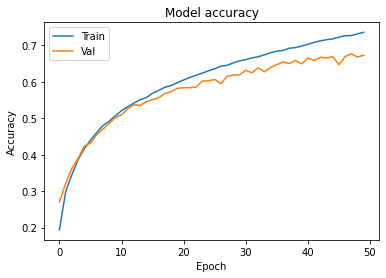

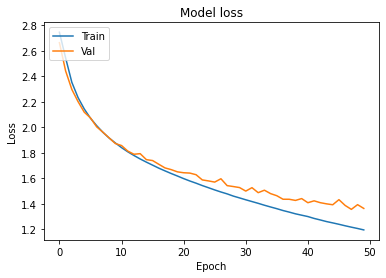

In [44]:
plot_curves(history)

#### Get predictions and find confusion matrix to get the metrics.  

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1fa21400ef0>)

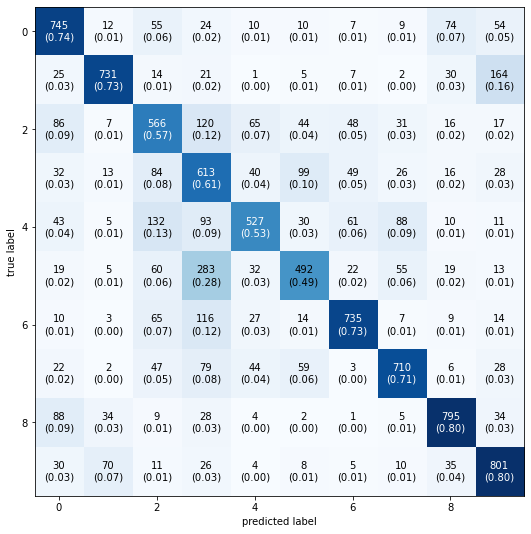

In [45]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1100
           1       0.73      0.83      0.78       882
           2       0.57      0.54      0.55      1043
           3       0.61      0.44      0.51      1403
           4       0.53      0.70      0.60       754
           5       0.49      0.64      0.56       763
           6       0.73      0.78      0.76       938
           7       0.71      0.75      0.73       943
           8       0.80      0.79      0.79      1010
           9       0.80      0.69      0.74      1164

    accuracy                           0.67     10000
   macro avg       0.67      0.68      0.67     10000
weighted avg       0.68      0.67      0.67     10000

0.6715


### Trying out Batch Norm and Dropout on the tuned hyperparameters. 

In [67]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg, False, True)
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 50000 samples, validate on 12500 samples
Epoch 1/50
50000/50000 [==============================] - 33s 660us/sample - loss: 1.9509 - sparse_categorical_accuracy: 0.3453 - val_loss: 3.0335 - val_sparse_categorical_accuracy: 0.1010
Epoch 2/50
50000/50000 [==============================] - 25s 509us/sample - loss: 1.6209 - sparse_categorical_accuracy: 0.4636 - val_loss: 2.9814 - val_sparse_categorical_accuracy: 0.1010
Epoch 3/50
50000/50000 [==============================] - 27s 530us/sample - loss: 1.4933 - sparse_categorical_accuracy: 0.5113 - val_loss: 3.0546 - val_sparse_categorical_accuracy: 0.1010
Epoch 4/50
50000/50000 [==============================] - 26s 517us/sample - loss: 1.4061 - sparse_categorical_accuracy: 0.5470 - val_loss: 3.0836 - val_sparse_categorical_accuracy: 0.1010
Epoch 5/50
50000/50000 [==============================] - 25s 500us/sample - loss: 1.3412 - sparse_categorical_accuracy: 0.5713 - val_loss: 3.0447 - val_sparse_categorical_accuracy: 0.1010
Epoch

In [ ]:
plot_curves(history)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1024
           1       0.81      0.82      0.82       993
           2       0.49      0.72      0.58       682
           3       0.55      0.52      0.53      1051
           4       0.73      0.63      0.68      1159
           5       0.57      0.62      0.60       914
           6       0.79      0.76      0.77      1039
           7       0.71      0.81      0.76       878
           8       0.86      0.70      0.77      1231
           9       0.79      0.77      0.78      1029

    accuracy                           0.70     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.72      0.70      0.71     10000

0.7044


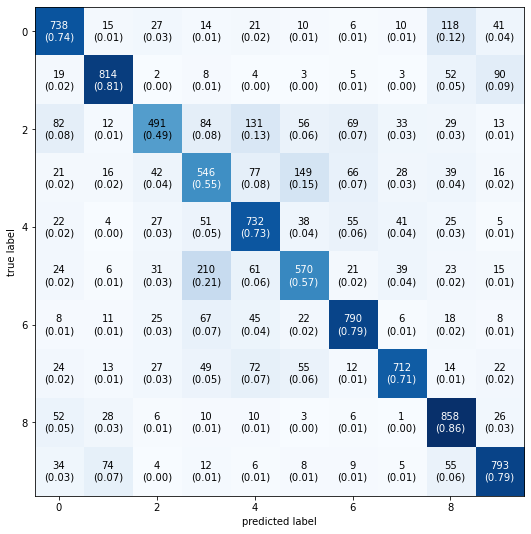

In [48]:
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

### Check the effect of Data Preprocessing on the training. 
Repeated the procedure with the preprocess flag changed to false.  

In [49]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#conv to float
(X_train, y_train), (X_test, y_test)=(X_train.astype('float64'), y_train), (X_test.astype('float64'), y_test)
#class_names for cifar
class_name = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
preprocess_flag=False

In [50]:
if preprocess_flag==True:
    X_train, X_test=preprocess_data(X_train, X_test)

In [51]:
#model hyperparam
LEARNING_RATE=1e-4
EPOCHS=10
L2_REG=0

In [52]:
model=create_model(num_classes,L2_REG)
model.summary()

Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_450 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_450 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_451 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_451 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_452 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_452 (MaxPoolin (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_150 (Flatten)        (None, 2048)           

In [53]:
model.compile(optimizer=optimizers.SGD(learning_rate=LEARNING_RATE),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
model.evaluate(X_train,y_train)

50000/50000 [==============================] - 9s 178us/sample - loss: 37.8876 - sparse_categorical_accuracy: 0.0812


[37.887600780029295, 0.08122]

In [54]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(100)):
    lr = 10**np.random.uniform(-3,-6)
    l2_reg = 10**np.random.uniform(-5, 1)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=5, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)

  0%|          | 0/100 [00:00<?, ?it/s]

Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 321us/sample - loss: 4.4687 - sparse_categorical_accuracy: 0.1903 - val_loss: 2.3056 - val_sparse_categorical_accuracy: 0.1392
Epoch 2/5
50000/50000 [==============================] - 13s 263us/sample - loss: 2.7116 - sparse_categorical_accuracy: 0.2485 - val_loss: 2.3042 - val_sparse_categorical_accuracy: 0.1442
Epoch 3/5
50000/50000 [==============================] - 13s 262us/sample - loss: 2.3584 - sparse_categorical_accuracy: 0.2803 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.1482
Epoch 4/5
50000/50000 [==============================] - 13s 263us/sample - loss: 2.1868 - sparse_categorical_accuracy: 0.3019 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1555
Epoch 5/5
50000/50000 [==============================] - 13s 264us/sample - loss: 2.0771 - sparse_categorical_accuracy: 0.3188 - val_loss: 2.3022 - val_sparse_categorical_accuracy: 0.1585


  1%|          | 1/100 [01:13<2:01:03, 73.37s/it]

0.15848 8.660452655827102e-06 7.391720956495326e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 318us/sample - loss: 3.5595 - sparse_categorical_accuracy: 0.3306 - val_loss: 3.8448 - val_sparse_categorical_accuracy: 0.1379
Epoch 2/5
50000/50000 [==============================] - 13s 262us/sample - loss: 3.1180 - sparse_categorical_accuracy: 0.4381 - val_loss: 3.8292 - val_sparse_categorical_accuracy: 0.1392
Epoch 3/5
50000/50000 [==============================] - 13s 262us/sample - loss: 2.9841 - sparse_categorical_accuracy: 0.4823 - val_loss: 3.8152 - val_sparse_categorical_accuracy: 0.1389
Epoch 4/5
50000/50000 [==============================] - 13s 262us/sample - loss: 2.8892 - sparse_categorical_accuracy: 0.5128 - val_loss: 3.8030 - val_sparse_categorical_accuracy: 0.1366
Epoch 5/5
50000/50000 [==============================] - 13s 262us/sample - loss: 2.8195 - sparse_categorical_accuracy: 0.5373 - val_loss: 3.7898 

  2%|▏         | 2/100 [02:26<1:59:37, 73.24s/it]

0.14288 0.00030997755253752687 0.0042621777050488975
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 319us/sample - loss: 540.8845 - sparse_categorical_accuracy: 0.2954 - val_loss: 271.8076 - val_sparse_categorical_accuracy: 0.1293
Epoch 2/5
50000/50000 [==============================] - 13s 258us/sample - loss: 155.7157 - sparse_categorical_accuracy: 0.3519 - val_loss: 79.4131 - val_sparse_categorical_accuracy: 0.1686
Epoch 3/5
50000/50000 [==============================] - 13s 260us/sample - loss: 46.0875 - sparse_categorical_accuracy: 0.3290 - val_loss: 24.5027 - val_sparse_categorical_accuracy: 0.2466
Epoch 4/5
50000/50000 [==============================] - 13s 258us/sample - loss: 14.7930 - sparse_categorical_accuracy: 0.2991 - val_loss: 8.8069 - val_sparse_categorical_accuracy: 0.2742
Epoch 5/5
50000/50000 [==============================] - 13s 259us/sample - loss: 5.8333 - sparse_categorical_accuracy: 0.2878 - val_lo

  3%|▎         | 3/100 [03:38<1:58:04, 73.04s/it]

0.25552 7.821624978578324e-05 2.564811615707776
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 319us/sample - loss: 4.7695 - sparse_categorical_accuracy: 0.1738 - val_loss: 2.7999 - val_sparse_categorical_accuracy: 0.1048
Epoch 2/5
50000/50000 [==============================] - 13s 264us/sample - loss: 3.1505 - sparse_categorical_accuracy: 0.2326 - val_loss: 2.7962 - val_sparse_categorical_accuracy: 0.1189
Epoch 3/5
50000/50000 [==============================] - 13s 263us/sample - loss: 2.8221 - sparse_categorical_accuracy: 0.2648 - val_loss: 2.7944 - val_sparse_categorical_accuracy: 0.1243
Epoch 4/5
50000/50000 [==============================] - 13s 261us/sample - loss: 2.6631 - sparse_categorical_accuracy: 0.2882 - val_loss: 2.7932 - val_sparse_categorical_accuracy: 0.1290
Epoch 5/5
50000/50000 [==============================] - 13s 262us/sample - loss: 2.5640 - sparse_categorical_accuracy: 0.3033 - val_loss: 2.7924 - va

  4%|▍         | 4/100 [04:52<1:56:55, 73.08s/it]

0.13032 7.373302353750594e-06 0.001363670430351966
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 322us/sample - loss: 3.4669 - sparse_categorical_accuracy: 0.2258 - val_loss: 2.3071 - val_sparse_categorical_accuracy: 0.1250
Epoch 2/5
50000/50000 [==============================] - 13s 262us/sample - loss: 2.1958 - sparse_categorical_accuracy: 0.3014 - val_loss: 2.3066 - val_sparse_categorical_accuracy: 0.1298
Epoch 3/5
50000/50000 [==============================] - 13s 264us/sample - loss: 1.9807 - sparse_categorical_accuracy: 0.3340 - val_loss: 2.3056 - val_sparse_categorical_accuracy: 0.1364
Epoch 4/5
50000/50000 [==============================] - 13s 264us/sample - loss: 1.8773 - sparse_categorical_accuracy: 0.3584 - val_loss: 2.3050 - val_sparse_categorical_accuracy: 0.1392
Epoch 5/5
50000/50000 [==============================] - 13s 264us/sample - loss: 1.8098 - sparse_categorical_accuracy: 0.3760 - val_loss: 2.3044 -

  5%|▌         | 5/100 [06:05<1:55:56, 73.23s/it]

0.14064 1.9282353681220903e-05 2.698815440459969e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 322us/sample - loss: 3.7696 - sparse_categorical_accuracy: 0.1933 - val_loss: 2.3685 - val_sparse_categorical_accuracy: 0.1237
Epoch 2/5
50000/50000 [==============================] - 13s 265us/sample - loss: 2.4800 - sparse_categorical_accuracy: 0.2509 - val_loss: 2.3676 - val_sparse_categorical_accuracy: 0.1222
Epoch 3/5
50000/50000 [==============================] - 13s 264us/sample - loss: 2.2431 - sparse_categorical_accuracy: 0.2776 - val_loss: 2.3665 - val_sparse_categorical_accuracy: 0.1232
Epoch 4/5
50000/50000 [==============================] - 13s 266us/sample - loss: 2.1226 - sparse_categorical_accuracy: 0.2997 - val_loss: 2.3657 - val_sparse_categorical_accuracy: 0.1246
Epoch 5/5
50000/50000 [==============================] - 13s 264us/sample - loss: 2.0458 - sparse_categorical_accuracy: 0.3158 - val_loss: 2.3649

  6%|▌         | 6/100 [07:19<1:55:01, 73.42s/it]

0.12376 1.131659824769087e-05 0.00019067082984828784
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 327us/sample - loss: 2.6128 - sparse_categorical_accuracy: 0.3743 - val_loss: 3.0823 - val_sparse_categorical_accuracy: 0.1916
Epoch 2/5
50000/50000 [==============================] - 13s 266us/sample - loss: 2.2364 - sparse_categorical_accuracy: 0.4859 - val_loss: 3.0703 - val_sparse_categorical_accuracy: 0.2218
Epoch 3/5
50000/50000 [==============================] - 13s 265us/sample - loss: 2.0952 - sparse_categorical_accuracy: 0.5371 - val_loss: 3.0593 - val_sparse_categorical_accuracy: 0.2352
Epoch 4/5
50000/50000 [==============================] - 13s 268us/sample - loss: 1.9925 - sparse_categorical_accuracy: 0.5722 - val_loss: 3.0519 - val_sparse_categorical_accuracy: 0.2111
Epoch 5/5
50000/50000 [==============================] - 13s 266us/sample - loss: 1.9089 - sparse_categorical_accuracy: 0.5986 - val_loss: 3.0402

  7%|▋         | 7/100 [08:33<1:54:17, 73.74s/it]

0.25024 0.0007423504025545301 0.002192957430950753
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 329us/sample - loss: 10.9091 - sparse_categorical_accuracy: 0.1662 - val_loss: 8.7332 - val_sparse_categorical_accuracy: 0.1302
Epoch 2/5
50000/50000 [==============================] - 14s 273us/sample - loss: 9.2077 - sparse_categorical_accuracy: 0.2281 - val_loss: 8.7246 - val_sparse_categorical_accuracy: 0.1319
Epoch 3/5
50000/50000 [==============================] - 14s 274us/sample - loss: 8.8634 - sparse_categorical_accuracy: 0.2565 - val_loss: 8.7177 - val_sparse_categorical_accuracy: 0.1347
Epoch 4/5
50000/50000 [==============================] - 14s 273us/sample - loss: 8.6835 - sparse_categorical_accuracy: 0.2770 - val_loss: 8.7112 - val_sparse_categorical_accuracy: 0.1365
Epoch 5/5
50000/50000 [==============================] - 14s 272us/sample - loss: 8.5705 - sparse_categorical_accuracy: 0.2942 - val_loss: 8.7050 

  8%|▊         | 8/100 [09:49<1:54:05, 74.40s/it]

0.13808 6.746816048299533e-06 0.017462224985745928
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 330us/sample - loss: 142.1161 - sparse_categorical_accuracy: 0.2865 - val_loss: 125.6281 - val_sparse_categorical_accuracy: 0.0950
Epoch 2/5
50000/50000 [==============================] - 13s 267us/sample - loss: 111.1533 - sparse_categorical_accuracy: 0.3851 - val_loss: 98.8721 - val_sparse_categorical_accuracy: 0.1118
Epoch 3/5
50000/50000 [==============================] - 13s 268us/sample - loss: 87.3371 - sparse_categorical_accuracy: 0.4216 - val_loss: 77.9482 - val_sparse_categorical_accuracy: 0.1281
Epoch 4/5
50000/50000 [==============================] - 13s 267us/sample - loss: 68.7293 - sparse_categorical_accuracy: 0.4398 - val_loss: 61.5792 - val_sparse_categorical_accuracy: 0.1530
Epoch 5/5
50000/50000 [==============================] - 13s 268us/sample - loss: 54.1786 - sparse_categorical_accuracy: 0.4559 - val_lo

  9%|▉         | 9/100 [11:04<1:53:04, 74.56s/it]

0.16512 9.152158785556221e-05 0.4275746481754762
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 335us/sample - loss: 3.0251 - sparse_categorical_accuracy: 0.2409 - val_loss: 2.3257 - val_sparse_categorical_accuracy: 0.1547
Epoch 2/5
50000/50000 [==============================] - 13s 269us/sample - loss: 1.9811 - sparse_categorical_accuracy: 0.3278 - val_loss: 2.3233 - val_sparse_categorical_accuracy: 0.1669
Epoch 3/5
50000/50000 [==============================] - 13s 269us/sample - loss: 1.8385 - sparse_categorical_accuracy: 0.3638 - val_loss: 2.3221 - val_sparse_categorical_accuracy: 0.1784
Epoch 4/5
50000/50000 [==============================] - 13s 267us/sample - loss: 1.7568 - sparse_categorical_accuracy: 0.3911 - val_loss: 2.3213 - val_sparse_categorical_accuracy: 0.1870
Epoch 5/5
50000/50000 [==============================] - 13s 269us/sample - loss: 1.7014 - sparse_categorical_accuracy: 0.4096 - val_loss: 2.3204 - v

 10%|█         | 10/100 [12:20<1:52:13, 74.81s/it]

0.18992 3.6666307462315554e-05 0.00010584895254129705
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 16s 329us/sample - loss: 2.1937 - sparse_categorical_accuracy: 0.3013 - val_loss: 2.3094 - val_sparse_categorical_accuracy: 0.1415
Epoch 2/5
50000/50000 [==============================] - 14s 270us/sample - loss: 1.7073 - sparse_categorical_accuracy: 0.3966 - val_loss: 2.3069 - val_sparse_categorical_accuracy: 0.1548
Epoch 3/5
50000/50000 [==============================] - 14s 271us/sample - loss: 1.6003 - sparse_categorical_accuracy: 0.4357 - val_loss: 2.3044 - val_sparse_categorical_accuracy: 0.1726
Epoch 4/5
50000/50000 [==============================] - 14s 272us/sample - loss: 1.5303 - sparse_categorical_accuracy: 0.4605 - val_loss: 2.3024 - val_sparse_categorical_accuracy: 0.1798
Epoch 5/5
50000/50000 [==============================] - 14s 270us/sample - loss: 1.4761 - sparse_categorical_accuracy: 0.4818 - val_loss: 2.301

 11%|█         | 11/100 [13:35<1:51:19, 75.05s/it]

0.18592 0.0001387961910392624 3.2646822932980595e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 334us/sample - loss: 8.0145 - sparse_categorical_accuracy: 0.1335 - val_loss: 2.4067 - val_sparse_categorical_accuracy: 0.0887
Epoch 2/5
50000/50000 [==============================] - 14s 270us/sample - loss: 4.9241 - sparse_categorical_accuracy: 0.1681 - val_loss: 2.4042 - val_sparse_categorical_accuracy: 0.0922
Epoch 3/5
50000/50000 [==============================] - 13s 269us/sample - loss: 4.1853 - sparse_categorical_accuracy: 0.1824 - val_loss: 2.4029 - val_sparse_categorical_accuracy: 0.0949
Epoch 4/5
50000/50000 [==============================] - 13s 270us/sample - loss: 3.7672 - sparse_categorical_accuracy: 0.1954 - val_loss: 2.4020 - val_sparse_categorical_accuracy: 0.0961
Epoch 5/5
50000/50000 [==============================] - 13s 269us/sample - loss: 3.4830 - sparse_categorical_accuracy: 0.2064 - val_loss: 2.4015

 12%|█▏        | 12/100 [14:51<1:50:21, 75.25s/it]

0.09728 1.1814154715939826e-06 0.00023552215673875294
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 338us/sample - loss: 2.0872 - sparse_categorical_accuracy: 0.3352 - val_loss: 2.2896 - val_sparse_categorical_accuracy: 0.1826
Epoch 2/5
50000/50000 [==============================] - 14s 275us/sample - loss: 1.6058 - sparse_categorical_accuracy: 0.4299 - val_loss: 2.2858 - val_sparse_categorical_accuracy: 0.1995
Epoch 3/5
50000/50000 [==============================] - 14s 274us/sample - loss: 1.4958 - sparse_categorical_accuracy: 0.4704 - val_loss: 2.2823 - val_sparse_categorical_accuracy: 0.2111
Epoch 4/5
50000/50000 [==============================] - 14s 274us/sample - loss: 1.4193 - sparse_categorical_accuracy: 0.4992 - val_loss: 2.2810 - val_sparse_categorical_accuracy: 0.2220
Epoch 5/5
50000/50000 [==============================] - 14s 275us/sample - loss: 1.3622 - sparse_categorical_accuracy: 0.5199 - val_loss: 2.278

 13%|█▎        | 13/100 [16:08<1:49:46, 75.71s/it]

0.23128 0.00023098104944903008 1.017317191492179e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 338us/sample - loss: 2.1848 - sparse_categorical_accuracy: 0.3218 - val_loss: 2.4214 - val_sparse_categorical_accuracy: 0.1046
Epoch 2/5
50000/50000 [==============================] - 14s 272us/sample - loss: 1.7446 - sparse_categorical_accuracy: 0.4224 - val_loss: 2.4171 - val_sparse_categorical_accuracy: 0.1199
Epoch 3/5
50000/50000 [==============================] - 14s 274us/sample - loss: 1.6281 - sparse_categorical_accuracy: 0.4637 - val_loss: 2.4147 - val_sparse_categorical_accuracy: 0.1374
Epoch 4/5
50000/50000 [==============================] - 14s 274us/sample - loss: 1.5521 - sparse_categorical_accuracy: 0.4929 - val_loss: 2.4131 - val_sparse_categorical_accuracy: 0.1352
Epoch 5/5
50000/50000 [==============================] - 14s 273us/sample - loss: 1.4927 - sparse_categorical_accuracy: 0.5152 - val_loss: 2.4113

 14%|█▍        | 14/100 [17:24<1:48:54, 75.98s/it]

0.15024 0.00022122603410128585 0.0003473902158777044
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 338us/sample - loss: 361.8096 - sparse_categorical_accuracy: 0.2318 - val_loss: 5.1043 - val_sparse_categorical_accuracy: 0.0984
Epoch 2/5
50000/50000 [==============================] - 14s 275us/sample - loss: 2.7170 - sparse_categorical_accuracy: 0.1301 - val_loss: 2.3058 - val_sparse_categorical_accuracy: 0.0984
Epoch 3/5
50000/50000 [==============================] - 14s 273us/sample - loss: 2.3031 - sparse_categorical_accuracy: 0.0987 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0984
Epoch 4/5
50000/50000 [==============================] - 14s 274us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0992 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0984
Epoch 5/5
50000/50000 [==============================] - 14s 273us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0999 - val_loss: 2.30

 15%|█▌        | 15/100 [18:41<1:48:00, 76.24s/it]

0.0984 0.00016390020948105736 6.60175322839365
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 343us/sample - loss: 31.3806 - sparse_categorical_accuracy: 0.2105 - val_loss: 30.1010 - val_sparse_categorical_accuracy: 0.1318
Epoch 2/5
50000/50000 [==============================] - 14s 277us/sample - loss: 29.9024 - sparse_categorical_accuracy: 0.2931 - val_loss: 29.8410 - val_sparse_categorical_accuracy: 0.1478
Epoch 3/5
50000/50000 [==============================] - 14s 277us/sample - loss: 29.4287 - sparse_categorical_accuracy: 0.3280 - val_loss: 29.5882 - val_sparse_categorical_accuracy: 0.1558
Epoch 4/5
50000/50000 [==============================] - 14s 277us/sample - loss: 29.0721 - sparse_categorical_accuracy: 0.3546 - val_loss: 29.3395 - val_sparse_categorical_accuracy: 0.1618
Epoch 5/5
50000/50000 [==============================] - 14s 277us/sample - loss: 28.7550 - sparse_categorical_accuracy: 0.3720 - val_loss: 29.

 16%|█▌        | 16/100 [19:59<1:47:24, 76.72s/it]

0.16776 1.8822414719646452e-05 0.07600958018334109
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 342us/sample - loss: 6.7407 - sparse_categorical_accuracy: 0.1431 - val_loss: 2.3088 - val_sparse_categorical_accuracy: 0.1209
Epoch 2/5
50000/50000 [==============================] - 14s 283us/sample - loss: 4.1072 - sparse_categorical_accuracy: 0.1865 - val_loss: 2.3065 - val_sparse_categorical_accuracy: 0.1228
Epoch 3/5
50000/50000 [==============================] - 14s 282us/sample - loss: 3.3753 - sparse_categorical_accuracy: 0.2079 - val_loss: 2.3052 - val_sparse_categorical_accuracy: 0.1266
Epoch 4/5
50000/50000 [==============================] - 14s 282us/sample - loss: 3.0087 - sparse_categorical_accuracy: 0.2258 - val_loss: 2.3044 - val_sparse_categorical_accuracy: 0.1289
Epoch 5/5
50000/50000 [==============================] - 14s 283us/sample - loss: 2.7891 - sparse_categorical_accuracy: 0.2393 - val_loss: 2.3036 -

 17%|█▋        | 17/100 [21:18<1:47:08, 77.45s/it]

0.13192 1.935458357409728e-06 2.346832291218174e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 347us/sample - loss: 2.0456 - sparse_categorical_accuracy: 0.3161 - val_loss: 2.2933 - val_sparse_categorical_accuracy: 0.1322
Epoch 2/5
50000/50000 [==============================] - 14s 280us/sample - loss: 1.6336 - sparse_categorical_accuracy: 0.4193 - val_loss: 2.2906 - val_sparse_categorical_accuracy: 0.1448
Epoch 3/5
50000/50000 [==============================] - 14s 280us/sample - loss: 1.5086 - sparse_categorical_accuracy: 0.4648 - val_loss: 2.2890 - val_sparse_categorical_accuracy: 0.1492
Epoch 4/5
50000/50000 [==============================] - 14s 279us/sample - loss: 1.4298 - sparse_categorical_accuracy: 0.4897 - val_loss: 2.2880 - val_sparse_categorical_accuracy: 0.1521
Epoch 5/5
50000/50000 [==============================] - 14s 279us/sample - loss: 1.3724 - sparse_categorical_accuracy: 0.5145 - val_loss: 2.2874 

 18%|█▊        | 18/100 [22:37<1:46:19, 77.80s/it]

0.15272 0.00020275646010410128 1.1092885870313044e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 346us/sample - loss: 61.2725 - sparse_categorical_accuracy: 0.3432 - val_loss: 7.8691 - val_sparse_categorical_accuracy: 0.2250
Epoch 2/5
50000/50000 [==============================] - 14s 284us/sample - loss: 3.3265 - sparse_categorical_accuracy: 0.3901 - val_loss: 2.6312 - val_sparse_categorical_accuracy: 0.2584
Epoch 3/5
50000/50000 [==============================] - 14s 283us/sample - loss: 1.9131 - sparse_categorical_accuracy: 0.3989 - val_loss: 2.4980 - val_sparse_categorical_accuracy: 0.2794
Epoch 4/5
50000/50000 [==============================] - 14s 283us/sample - loss: 1.8517 - sparse_categorical_accuracy: 0.4072 - val_loss: 2.4938 - val_sparse_categorical_accuracy: 0.2194
Epoch 5/5
50000/50000 [==============================] - 14s 283us/sample - loss: 1.8254 - sparse_categorical_accuracy: 0.4150 - val_loss: 2.49

 19%|█▉        | 19/100 [23:56<1:45:39, 78.26s/it]

0.26688 0.0009760324743815582 0.6143160393120578
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 344us/sample - loss: 3159.4948 - sparse_categorical_accuracy: 0.1538 - val_loss: 2914.0011 - val_sparse_categorical_accuracy: 0.1263
Epoch 2/5
50000/50000 [==============================] - 14s 279us/sample - loss: 2697.2543 - sparse_categorical_accuracy: 0.2121 - val_loss: 2489.9991 - val_sparse_categorical_accuracy: 0.1346
Epoch 3/5
50000/50000 [==============================] - 14s 279us/sample - loss: 2304.4234 - sparse_categorical_accuracy: 0.2409 - val_loss: 2127.8632 - val_sparse_categorical_accuracy: 0.1390
Epoch 4/5
50000/50000 [==============================] - 14s 279us/sample - loss: 1969.1038 - sparse_categorical_accuracy: 0.2635 - val_loss: 1818.5117 - val_sparse_categorical_accuracy: 0.1435
Epoch 5/5
50000/50000 [==============================] - 14s 282us/sample - loss: 1682.7332 - sparse_categorical_accuracy: 0.

 20%|██        | 20/100 [25:15<1:44:27, 78.35s/it]

0.14608 2.7287134984525446e-06 9.216388581763288
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 350us/sample - loss: 2.7872 - sparse_categorical_accuracy: 0.2865 - val_loss: 2.5800 - val_sparse_categorical_accuracy: 0.1304
Epoch 2/5
50000/50000 [==============================] - 14s 282us/sample - loss: 2.0557 - sparse_categorical_accuracy: 0.3780 - val_loss: 2.5780 - val_sparse_categorical_accuracy: 0.1476
Epoch 3/5
50000/50000 [==============================] - 14s 284us/sample - loss: 1.9426 - sparse_categorical_accuracy: 0.4151 - val_loss: 2.5765 - val_sparse_categorical_accuracy: 0.1612
Epoch 4/5
50000/50000 [==============================] - 14s 284us/sample - loss: 1.8691 - sparse_categorical_accuracy: 0.4403 - val_loss: 2.5750 - val_sparse_categorical_accuracy: 0.1695
Epoch 5/5
50000/50000 [==============================] - 14s 282us/sample - loss: 1.8122 - sparse_categorical_accuracy: 0.4612 - val_loss: 2.5737 - v

 21%|██        | 21/100 [26:34<1:43:35, 78.68s/it]

0.17488 9.154195055497476e-05 0.0007661567636344115
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 346us/sample - loss: 4.2562 - sparse_categorical_accuracy: 0.2240 - val_loss: 3.2598 - val_sparse_categorical_accuracy: 0.1187
Epoch 2/5
50000/50000 [==============================] - 14s 284us/sample - loss: 3.1361 - sparse_categorical_accuracy: 0.2882 - val_loss: 3.2574 - val_sparse_categorical_accuracy: 0.1239
Epoch 3/5
50000/50000 [==============================] - 14s 283us/sample - loss: 2.9489 - sparse_categorical_accuracy: 0.3223 - val_loss: 3.2560 - val_sparse_categorical_accuracy: 0.1291
Epoch 4/5
50000/50000 [==============================] - 14s 283us/sample - loss: 2.8508 - sparse_categorical_accuracy: 0.3461 - val_loss: 3.2549 - val_sparse_categorical_accuracy: 0.1306
Epoch 5/5
50000/50000 [==============================] - 14s 282us/sample - loss: 2.7840 - sparse_categorical_accuracy: 0.3651 - val_loss: 3.2540 

 22%|██▏       | 22/100 [27:54<1:42:34, 78.90s/it]

0.13192 1.8104423091926943e-05 0.0026332854885286095
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 352us/sample - loss: 1.9873 - sparse_categorical_accuracy: 0.3449 - val_loss: 2.2831 - val_sparse_categorical_accuracy: 0.1772
Epoch 2/5
50000/50000 [==============================] - 14s 288us/sample - loss: 1.5225 - sparse_categorical_accuracy: 0.4630 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.1938
Epoch 3/5
50000/50000 [==============================] - 14s 287us/sample - loss: 1.3902 - sparse_categorical_accuracy: 0.5098 - val_loss: 2.2814 - val_sparse_categorical_accuracy: 0.2010
Epoch 4/5
50000/50000 [==============================] - 14s 287us/sample - loss: 1.3012 - sparse_categorical_accuracy: 0.5495 - val_loss: 2.2793 - val_sparse_categorical_accuracy: 0.1926
Epoch 5/5
50000/50000 [==============================] - 14s 289us/sample - loss: 1.2201 - sparse_categorical_accuracy: 0.5764 - val_loss: 2.2785

 23%|██▎       | 23/100 [29:14<1:41:58, 79.46s/it]

0.19864 0.0008105007715771471 3.622876194489416e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 17s 343us/sample - loss: 4.2450 - sparse_categorical_accuracy: 0.1539 - val_loss: 2.4943 - val_sparse_categorical_accuracy: 0.0993
Epoch 2/5
50000/50000 [==============================] - 14s 285us/sample - loss: 2.9535 - sparse_categorical_accuracy: 0.1942 - val_loss: 2.4915 - val_sparse_categorical_accuracy: 0.1033
Epoch 3/5
50000/50000 [==============================] - 14s 284us/sample - loss: 2.6213 - sparse_categorical_accuracy: 0.2248 - val_loss: 2.4900 - val_sparse_categorical_accuracy: 0.1050
Epoch 4/5
50000/50000 [==============================] - 14s 284us/sample - loss: 2.4708 - sparse_categorical_accuracy: 0.2423 - val_loss: 2.4891 - val_sparse_categorical_accuracy: 0.1034
Epoch 5/5
50000/50000 [==============================] - 14s 284us/sample - loss: 2.3784 - sparse_categorical_accuracy: 0.2567 - val_loss: 2.4882 

 24%|██▍       | 24/100 [30:34<1:40:39, 79.47s/it]

0.1052 5.559780932507906e-06 0.000504886949018922
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 356us/sample - loss: 66.2237 - sparse_categorical_accuracy: 0.1074 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1012
Epoch 2/5
50000/50000 [==============================] - 15s 291us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0985 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1012
Epoch 3/5
50000/50000 [==============================] - 14s 289us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0969 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1012
Epoch 4/5
50000/50000 [==============================] - 14s 290us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0977 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0996
Epoch 5/5
50000/50000 [==============================] - 15s 290us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0970 - val_loss: 2.3026 -

 25%|██▌       | 25/100 [31:55<1:40:03, 80.04s/it]

0.0996 0.0009371490479952055 8.71299183899672
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 361us/sample - loss: 13.7230 - sparse_categorical_accuracy: 0.1708 - val_loss: 10.6970 - val_sparse_categorical_accuracy: 0.0895
Epoch 2/5
50000/50000 [==============================] - 14s 284us/sample - loss: 11.5418 - sparse_categorical_accuracy: 0.2135 - val_loss: 10.6872 - val_sparse_categorical_accuracy: 0.0902
Epoch 3/5
50000/50000 [==============================] - 14s 284us/sample - loss: 11.0932 - sparse_categorical_accuracy: 0.2334 - val_loss: 10.6790 - val_sparse_categorical_accuracy: 0.0909
Epoch 4/5
50000/50000 [==============================] - 14s 285us/sample - loss: 10.8733 - sparse_categorical_accuracy: 0.2483 - val_loss: 10.6714 - val_sparse_categorical_accuracy: 0.0934
Epoch 5/5
50000/50000 [==============================] - 14s 286us/sample - loss: 10.7315 - sparse_categorical_accuracy: 0.2623 - val_loss: 10.6

 26%|██▌       | 26/100 [33:16<1:38:58, 80.25s/it]

0.09376 4.966945386230178e-06 0.02275725488424489
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 355us/sample - loss: 2.3916 - sparse_categorical_accuracy: 0.3398 - val_loss: 2.6983 - val_sparse_categorical_accuracy: 0.1640
Epoch 2/5
50000/50000 [==============================] - 15s 292us/sample - loss: 1.9506 - sparse_categorical_accuracy: 0.4536 - val_loss: 2.6905 - val_sparse_categorical_accuracy: 0.1718
Epoch 3/5
50000/50000 [==============================] - 15s 293us/sample - loss: 1.8232 - sparse_categorical_accuracy: 0.4975 - val_loss: 2.6883 - val_sparse_categorical_accuracy: 0.1728
Epoch 4/5
50000/50000 [==============================] - 15s 292us/sample - loss: 1.7404 - sparse_categorical_accuracy: 0.5295 - val_loss: 2.6873 - val_sparse_categorical_accuracy: 0.1693
Epoch 5/5
50000/50000 [==============================] - 15s 291us/sample - loss: 1.6749 - sparse_categorical_accuracy: 0.5529 - val_loss: 2.6869 - 

 27%|██▋       | 27/100 [34:38<1:38:16, 80.77s/it]

0.16968 0.0004720873498397735 0.0011356461034378379
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 362us/sample - loss: 5.5674 - sparse_categorical_accuracy: 0.1630 - val_loss: 2.3119 - val_sparse_categorical_accuracy: 0.1006
Epoch 2/5
50000/50000 [==============================] - 15s 292us/sample - loss: 3.2289 - sparse_categorical_accuracy: 0.2077 - val_loss: 2.3094 - val_sparse_categorical_accuracy: 0.1041
Epoch 3/5
50000/50000 [==============================] - 15s 292us/sample - loss: 2.7828 - sparse_categorical_accuracy: 0.2283 - val_loss: 2.3080 - val_sparse_categorical_accuracy: 0.1074
Epoch 4/5
50000/50000 [==============================] - 15s 291us/sample - loss: 2.5474 - sparse_categorical_accuracy: 0.2466 - val_loss: 2.3069 - val_sparse_categorical_accuracy: 0.1097
Epoch 5/5
50000/50000 [==============================] - 15s 291us/sample - loss: 2.3971 - sparse_categorical_accuracy: 0.2607 - val_loss: 2.3062 

 28%|██▊       | 28/100 [36:00<1:37:23, 81.15s/it]

0.11208 3.6498107363745878e-06 1.859268030991274e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 363us/sample - loss: 8.9866 - sparse_categorical_accuracy: 0.1877 - val_loss: 7.0772 - val_sparse_categorical_accuracy: 0.1134
Epoch 2/5
50000/50000 [==============================] - 14s 283us/sample - loss: 7.4184 - sparse_categorical_accuracy: 0.2504 - val_loss: 7.0714 - val_sparse_categorical_accuracy: 0.1127
Epoch 3/5
50000/50000 [==============================] - 14s 284us/sample - loss: 7.0863 - sparse_categorical_accuracy: 0.2822 - val_loss: 7.0663 - val_sparse_categorical_accuracy: 0.1125
Epoch 4/5
50000/50000 [==============================] - 14s 285us/sample - loss: 6.9208 - sparse_categorical_accuracy: 0.3010 - val_loss: 7.0613 - val_sparse_categorical_accuracy: 0.1165
Epoch 5/5
50000/50000 [==============================] - 14s 286us/sample - loss: 6.8151 - sparse_categorical_accuracy: 0.3167 - val_loss: 7.0567

 29%|██▉       | 29/100 [37:21<1:35:52, 81.02s/it]

0.1172 9.416081732502577e-06 0.012967309814815193
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 366us/sample - loss: 4.8463 - sparse_categorical_accuracy: 0.2029 - val_loss: 3.1526 - val_sparse_categorical_accuracy: 0.1252
Epoch 2/5
50000/50000 [==============================] - 15s 293us/sample - loss: 3.3631 - sparse_categorical_accuracy: 0.2664 - val_loss: 3.1516 - val_sparse_categorical_accuracy: 0.1315
Epoch 3/5
50000/50000 [==============================] - 14s 288us/sample - loss: 3.0824 - sparse_categorical_accuracy: 0.2950 - val_loss: 3.1511 - val_sparse_categorical_accuracy: 0.1345
Epoch 4/5
50000/50000 [==============================] - 15s 290us/sample - loss: 2.9311 - sparse_categorical_accuracy: 0.3168 - val_loss: 3.1507 - val_sparse_categorical_accuracy: 0.1382
Epoch 5/5
50000/50000 [==============================] - 15s 292us/sample - loss: 2.8356 - sparse_categorical_accuracy: 0.3368 - val_loss: 3.1503 - 

 30%|███       | 30/100 [38:43<1:34:58, 81.41s/it]

0.14 1.1109154899548993e-05 0.0023259411615945687
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 360us/sample - loss: 5.5573 - sparse_categorical_accuracy: 0.1246 - val_loss: 2.3469 - val_sparse_categorical_accuracy: 0.0958
Epoch 2/5
50000/50000 [==============================] - 15s 295us/sample - loss: 3.3175 - sparse_categorical_accuracy: 0.1640 - val_loss: 2.3449 - val_sparse_categorical_accuracy: 0.0986
Epoch 3/5
50000/50000 [==============================] - 15s 293us/sample - loss: 2.9220 - sparse_categorical_accuracy: 0.1835 - val_loss: 2.3435 - val_sparse_categorical_accuracy: 0.1013
Epoch 4/5
50000/50000 [==============================] - 15s 293us/sample - loss: 2.7064 - sparse_categorical_accuracy: 0.1976 - val_loss: 2.3425 - val_sparse_categorical_accuracy: 0.1032
Epoch 5/5
50000/50000 [==============================] - 15s 291us/sample - loss: 2.5660 - sparse_categorical_accuracy: 0.2125 - val_loss: 2.3417 - 

 31%|███       | 31/100 [40:06<1:34:06, 81.84s/it]

0.10504 3.2478376553314656e-06 0.00011255363953711129
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 369us/sample - loss: 722.0889 - sparse_categorical_accuracy: 0.2321 - val_loss: 39.0534 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/5
50000/50000 [==============================] - 15s 294us/sample - loss: 10.4160 - sparse_categorical_accuracy: 0.1288 - val_loss: 2.7174 - val_sparse_categorical_accuracy: 0.0984
Epoch 3/5
50000/50000 [==============================] - 15s 293us/sample - loss: 2.3941 - sparse_categorical_accuracy: 0.1001 - val_loss: 2.3073 - val_sparse_categorical_accuracy: 0.0984
Epoch 4/5
50000/50000 [==============================] - 15s 300us/sample - loss: 2.3036 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0984
Epoch 5/5
50000/50000 [==============================] - 15s 293us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0986 - val_loss: 2

 32%|███▏      | 32/100 [41:29<1:33:16, 82.31s/it]

0.0984 8.093679238637585e-05 8.862115146376118
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 367us/sample - loss: 1.8291 - sparse_categorical_accuracy: 0.3689 - val_loss: 2.2853 - val_sparse_categorical_accuracy: 0.1727
Epoch 2/5
50000/50000 [==============================] - 15s 295us/sample - loss: 1.4901 - sparse_categorical_accuracy: 0.4732 - val_loss: 2.2816 - val_sparse_categorical_accuracy: 0.1872
Epoch 3/5
50000/50000 [==============================] - 15s 294us/sample - loss: 1.3632 - sparse_categorical_accuracy: 0.5195 - val_loss: 2.2818 - val_sparse_categorical_accuracy: 0.1729
Epoch 4/5
50000/50000 [==============================] - 15s 293us/sample - loss: 1.2776 - sparse_categorical_accuracy: 0.5514 - val_loss: 2.2812 - val_sparse_categorical_accuracy: 0.1705
Epoch 5/5
50000/50000 [==============================] - 15s 293us/sample - loss: 1.2049 - sparse_categorical_accuracy: 0.5810 - val_loss: 2.2788 - val

 33%|███▎      | 33/100 [42:52<1:32:09, 82.53s/it]

0.16896 0.0006180041944253648 1.860954330406976e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 369us/sample - loss: 2.2856 - sparse_categorical_accuracy: 0.2823 - val_loss: 2.3068 - val_sparse_categorical_accuracy: 0.1199
Epoch 2/5
50000/50000 [==============================] - 15s 295us/sample - loss: 1.7690 - sparse_categorical_accuracy: 0.3783 - val_loss: 2.3025 - val_sparse_categorical_accuracy: 0.1288
Epoch 3/5
50000/50000 [==============================] - 15s 294us/sample - loss: 1.6538 - sparse_categorical_accuracy: 0.4178 - val_loss: 2.3001 - val_sparse_categorical_accuracy: 0.1370
Epoch 4/5
50000/50000 [==============================] - 15s 295us/sample - loss: 1.5792 - sparse_categorical_accuracy: 0.4432 - val_loss: 2.2985 - val_sparse_categorical_accuracy: 0.1454
Epoch 5/5
50000/50000 [==============================] - 15s 297us/sample - loss: 1.5256 - sparse_categorical_accuracy: 0.4626 - val_loss: 2.2979 

 34%|███▍      | 34/100 [44:16<1:31:03, 82.77s/it]

0.14936 9.278775280428263e-05 3.240361174412997e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 369us/sample - loss: 1.9729 - sparse_categorical_accuracy: 0.3464 - val_loss: 2.3039 - val_sparse_categorical_accuracy: 0.1502
Epoch 2/5
50000/50000 [==============================] - 15s 292us/sample - loss: 1.5086 - sparse_categorical_accuracy: 0.4642 - val_loss: 2.2970 - val_sparse_categorical_accuracy: 0.1672
Epoch 3/5
50000/50000 [==============================] - 15s 293us/sample - loss: 1.3672 - sparse_categorical_accuracy: 0.5181 - val_loss: 2.2973 - val_sparse_categorical_accuracy: 0.1633
Epoch 4/5
50000/50000 [==============================] - 15s 293us/sample - loss: 1.2660 - sparse_categorical_accuracy: 0.5582 - val_loss: 2.2954 - val_sparse_categorical_accuracy: 0.1678
Epoch 5/5
50000/50000 [==============================] - 15s 292us/sample - loss: 1.1872 - sparse_categorical_accuracy: 0.5872 - val_loss: 2.2941 

 35%|███▌      | 35/100 [45:39<1:29:45, 82.85s/it]

0.17032 0.000966541768600278 3.422218281672664e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 18s 370us/sample - loss: 24.2141 - sparse_categorical_accuracy: 0.1507 - val_loss: 21.0367 - val_sparse_categorical_accuracy: 0.1236
Epoch 2/5
50000/50000 [==============================] - 15s 296us/sample - loss: 21.8644 - sparse_categorical_accuracy: 0.2166 - val_loss: 21.0015 - val_sparse_categorical_accuracy: 0.1266
Epoch 3/5
50000/50000 [==============================] - 15s 297us/sample - loss: 21.3749 - sparse_categorical_accuracy: 0.2472 - val_loss: 20.9691 - val_sparse_categorical_accuracy: 0.1317
Epoch 4/5
50000/50000 [==============================] - 15s 297us/sample - loss: 21.1091 - sparse_categorical_accuracy: 0.2680 - val_loss: 20.9383 - val_sparse_categorical_accuracy: 0.1336
Epoch 5/5
50000/50000 [==============================] - 15s 294us/sample - loss: 20.9358 - sparse_categorical_accuracy: 0.2850 - val_loss:

 36%|███▌      | 36/100 [47:03<1:28:43, 83.18s/it]

0.13752 4.619224081146212e-06 0.05076776996428
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 371us/sample - loss: 1042.2619 - sparse_categorical_accuracy: 0.2567 - val_loss: 548.3929 - val_sparse_categorical_accuracy: 0.1663
Epoch 2/5
50000/50000 [==============================] - 15s 306us/sample - loss: 323.7142 - sparse_categorical_accuracy: 0.3355 - val_loss: 171.4173 - val_sparse_categorical_accuracy: 0.2232
Epoch 3/5
50000/50000 [==============================] - 15s 305us/sample - loss: 101.7906 - sparse_categorical_accuracy: 0.3117 - val_loss: 54.7725 - val_sparse_categorical_accuracy: 0.2628
Epoch 4/5
50000/50000 [==============================] - 15s 306us/sample - loss: 33.1341 - sparse_categorical_accuracy: 0.2754 - val_loss: 18.6513 - val_sparse_categorical_accuracy: 0.1926
Epoch 5/5
50000/50000 [==============================] - 15s 306us/sample - loss: 11.8793 - sparse_categorical_accuracy: 0.2477 - val_los

 37%|███▋      | 37/100 [48:29<1:28:11, 84.00s/it]

0.15384 3.9182233753124054e-05 4.789225082030182
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 376us/sample - loss: 120.7255 - sparse_categorical_accuracy: 0.1546 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.1018
Epoch 2/5
50000/50000 [==============================] - 15s 301us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0992 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1018
Epoch 3/5
50000/50000 [==============================] - 15s 302us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1018
Epoch 4/5
50000/50000 [==============================] - 15s 300us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1018
Epoch 5/5
50000/50000 [==============================] - 15s 299us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 -

 38%|███▊      | 38/100 [49:54<1:27:08, 84.33s/it]

0.10184 0.0005005824116328683 4.6895572090655335
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 373us/sample - loss: 12.5445 - sparse_categorical_accuracy: 0.3018 - val_loss: 12.5221 - val_sparse_categorical_accuracy: 0.1350
Epoch 2/5
50000/50000 [==============================] - 16s 312us/sample - loss: 11.7865 - sparse_categorical_accuracy: 0.3972 - val_loss: 12.2587 - val_sparse_categorical_accuracy: 0.1470
Epoch 3/5
50000/50000 [==============================] - 16s 311us/sample - loss: 11.4144 - sparse_categorical_accuracy: 0.4391 - val_loss: 12.0038 - val_sparse_categorical_accuracy: 0.1570
Epoch 4/5
50000/50000 [==============================] - 16s 313us/sample - loss: 11.0934 - sparse_categorical_accuracy: 0.4637 - val_loss: 11.7564 - val_sparse_categorical_accuracy: 0.1628
Epoch 5/5
50000/50000 [==============================] - 16s 313us/sample - loss: 10.7965 - sparse_categorical_accuracy: 0.4846 - val_loss: 1

 39%|███▉      | 39/100 [51:21<1:26:36, 85.19s/it]

0.1724 0.00014442364226493467 0.028442628253410818
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 380us/sample - loss: 201.2705 - sparse_categorical_accuracy: 0.2406 - val_loss: 188.0227 - val_sparse_categorical_accuracy: 0.1476
Epoch 2/5
50000/50000 [==============================] - 15s 307us/sample - loss: 176.1989 - sparse_categorical_accuracy: 0.3318 - val_loss: 165.5789 - val_sparse_categorical_accuracy: 0.1646
Epoch 3/5
50000/50000 [==============================] - 15s 306us/sample - loss: 154.9993 - sparse_categorical_accuracy: 0.3759 - val_loss: 145.8770 - val_sparse_categorical_accuracy: 0.1719
Epoch 4/5
50000/50000 [==============================] - 15s 307us/sample - loss: 136.4412 - sparse_categorical_accuracy: 0.4018 - val_loss: 128.5693 - val_sparse_categorical_accuracy: 0.1823
Epoch 5/5
50000/50000 [==============================] - 15s 306us/sample - loss: 120.1570 - sparse_categorical_accuracy: 0.4215 - 

 40%|████      | 40/100 [52:47<1:25:32, 85.55s/it]

0.19304 3.5830496950712624e-05 0.5736406679086342
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 386us/sample - loss: 2.4853 - sparse_categorical_accuracy: 0.2650 - val_loss: 2.3052 - val_sparse_categorical_accuracy: 0.1501
Epoch 2/5
50000/50000 [==============================] - 16s 312us/sample - loss: 1.8282 - sparse_categorical_accuracy: 0.3576 - val_loss: 2.3037 - val_sparse_categorical_accuracy: 0.1622
Epoch 3/5
50000/50000 [==============================] - 16s 312us/sample - loss: 1.7121 - sparse_categorical_accuracy: 0.4000 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1665
Epoch 4/5
50000/50000 [==============================] - 16s 312us/sample - loss: 1.6432 - sparse_categorical_accuracy: 0.4206 - val_loss: 2.3018 - val_sparse_categorical_accuracy: 0.1729
Epoch 5/5
50000/50000 [==============================] - 16s 312us/sample - loss: 1.5908 - sparse_categorical_accuracy: 0.4415 - val_loss: 2.3013 - 

 41%|████      | 41/100 [54:15<1:24:46, 86.22s/it]

0.18312 7.707163423100442e-05 4.818299979831991e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 390us/sample - loss: 7.2589 - sparse_categorical_accuracy: 0.1229 - val_loss: 2.3063 - val_sparse_categorical_accuracy: 0.1279
Epoch 2/5
50000/50000 [==============================] - 16s 311us/sample - loss: 4.6956 - sparse_categorical_accuracy: 0.1563 - val_loss: 2.3043 - val_sparse_categorical_accuracy: 0.1302
Epoch 3/5
50000/50000 [==============================] - 16s 313us/sample - loss: 3.9854 - sparse_categorical_accuracy: 0.1735 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.1348
Epoch 4/5
50000/50000 [==============================] - 16s 312us/sample - loss: 3.5907 - sparse_categorical_accuracy: 0.1853 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1349
Epoch 5/5
50000/50000 [==============================] - 16s 312us/sample - loss: 3.3373 - sparse_categorical_accuracy: 0.1955 - val_loss: 2.3021 

 42%|████▏     | 42/100 [55:43<1:23:55, 86.81s/it]

0.13632 1.117221459834184e-06 2.566521898510271e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 388us/sample - loss: 4.5409 - sparse_categorical_accuracy: 0.1848 - val_loss: 2.5701 - val_sparse_categorical_accuracy: 0.1058
Epoch 2/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.8437 - sparse_categorical_accuracy: 0.2466 - val_loss: 2.5687 - val_sparse_categorical_accuracy: 0.1053
Epoch 3/5
50000/50000 [==============================] - 16s 317us/sample - loss: 2.5325 - sparse_categorical_accuracy: 0.2774 - val_loss: 2.5681 - val_sparse_categorical_accuracy: 0.1064
Epoch 4/5
50000/50000 [==============================] - 16s 317us/sample - loss: 2.3809 - sparse_categorical_accuracy: 0.3016 - val_loss: 2.5676 - val_sparse_categorical_accuracy: 0.1086
Epoch 5/5
50000/50000 [==============================] - 16s 318us/sample - loss: 2.2901 - sparse_categorical_accuracy: 0.3171 - val_loss: 2.5673 

 43%|████▎     | 43/100 [57:12<1:23:08, 87.52s/it]

0.11032 1.0509701610327857e-05 0.0007278167768206475
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 387us/sample - loss: 4.7910 - sparse_categorical_accuracy: 0.1709 - val_loss: 2.3079 - val_sparse_categorical_accuracy: 0.1059
Epoch 2/5
50000/50000 [==============================] - 15s 304us/sample - loss: 2.9746 - sparse_categorical_accuracy: 0.2193 - val_loss: 2.3066 - val_sparse_categorical_accuracy: 0.1127
Epoch 3/5
50000/50000 [==============================] - 15s 305us/sample - loss: 2.5695 - sparse_categorical_accuracy: 0.2483 - val_loss: 2.3058 - val_sparse_categorical_accuracy: 0.1138
Epoch 4/5
50000/50000 [==============================] - 15s 305us/sample - loss: 2.3534 - sparse_categorical_accuracy: 0.2678 - val_loss: 2.3050 - val_sparse_categorical_accuracy: 0.1171
Epoch 5/5
50000/50000 [==============================] - 15s 305us/sample - loss: 2.2228 - sparse_categorical_accuracy: 0.2847 - val_loss: 2.3042

 44%|████▍     | 44/100 [58:39<1:21:28, 87.30s/it]

0.12048 6.074592866267217e-06 1.4202134297339958e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 393us/sample - loss: 363.9589 - sparse_categorical_accuracy: 0.3209 - val_loss: 164.4913 - val_sparse_categorical_accuracy: 0.1470
Epoch 2/5
50000/50000 [==============================] - 16s 314us/sample - loss: 88.1262 - sparse_categorical_accuracy: 0.3814 - val_loss: 41.1411 - val_sparse_categorical_accuracy: 0.1762
Epoch 3/5
50000/50000 [==============================] - 16s 312us/sample - loss: 22.6532 - sparse_categorical_accuracy: 0.3619 - val_loss: 11.7750 - val_sparse_categorical_accuracy: 0.1554
Epoch 4/5
50000/50000 [==============================] - 16s 312us/sample - loss: 7.0486 - sparse_categorical_accuracy: 0.3514 - val_loss: 4.7715 - val_sparse_categorical_accuracy: 0.1746
Epoch 5/5
50000/50000 [==============================] - 16s 312us/sample - loss: 3.3092 - sparse_categorical_accuracy: 0.3535 - val_loss

 45%|████▌     | 45/100 [1:00:08<1:20:19, 87.63s/it]

0.16864 0.000124271599439648 1.8480483992583205
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 394us/sample - loss: 4.0341 - sparse_categorical_accuracy: 0.1511 - val_loss: 2.3103 - val_sparse_categorical_accuracy: 0.1137
Epoch 2/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.6422 - sparse_categorical_accuracy: 0.2091 - val_loss: 2.3073 - val_sparse_categorical_accuracy: 0.1196
Epoch 3/5
50000/50000 [==============================] - 16s 317us/sample - loss: 2.3995 - sparse_categorical_accuracy: 0.2350 - val_loss: 2.3056 - val_sparse_categorical_accuracy: 0.1238
Epoch 4/5
50000/50000 [==============================] - 16s 317us/sample - loss: 2.2626 - sparse_categorical_accuracy: 0.2562 - val_loss: 2.3046 - val_sparse_categorical_accuracy: 0.1262
Epoch 5/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.1704 - sparse_categorical_accuracy: 0.2721 - val_loss: 2.3037 - va

 46%|████▌     | 46/100 [1:01:37<1:19:22, 88.19s/it]

0.12752 6.130198036437592e-06 1.5193172131477439e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 392us/sample - loss: 6.9417 - sparse_categorical_accuracy: 0.2874 - val_loss: 6.9734 - val_sparse_categorical_accuracy: 0.1130
Epoch 2/5
50000/50000 [==============================] - 16s 311us/sample - loss: 6.3799 - sparse_categorical_accuracy: 0.3862 - val_loss: 6.9308 - val_sparse_categorical_accuracy: 0.1300
Epoch 3/5
50000/50000 [==============================] - 15s 308us/sample - loss: 6.2222 - sparse_categorical_accuracy: 0.4282 - val_loss: 6.8901 - val_sparse_categorical_accuracy: 0.1342
Epoch 4/5
50000/50000 [==============================] - 15s 307us/sample - loss: 6.1073 - sparse_categorical_accuracy: 0.4542 - val_loss: 6.8500 - val_sparse_categorical_accuracy: 0.1388
Epoch 5/5
50000/50000 [==============================] - 15s 309us/sample - loss: 6.0105 - sparse_categorical_accuracy: 0.4737 - val_loss: 6.8109

 47%|████▋     | 47/100 [1:03:05<1:17:48, 88.09s/it]

0.14128 0.00010868703488978787 0.01278135988760256
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 398us/sample - loss: 783.4958 - sparse_categorical_accuracy: 0.2143 - val_loss: 686.2986 - val_sparse_categorical_accuracy: 0.1039
Epoch 2/5
50000/50000 [==============================] - 16s 316us/sample - loss: 605.3384 - sparse_categorical_accuracy: 0.2892 - val_loss: 531.4129 - val_sparse_categorical_accuracy: 0.1144
Epoch 3/5
50000/50000 [==============================] - 16s 316us/sample - loss: 468.6097 - sparse_categorical_accuracy: 0.3329 - val_loss: 411.6815 - val_sparse_categorical_accuracy: 0.1298
Epoch 4/5
50000/50000 [==============================] - 16s 319us/sample - loss: 362.9661 - sparse_categorical_accuracy: 0.3580 - val_loss: 319.0855 - val_sparse_categorical_accuracy: 0.1477
Epoch 5/5
50000/50000 [==============================] - 16s 316us/sample - loss: 281.2845 - sparse_categorical_accuracy: 0.3716 - 

 48%|████▊     | 48/100 [1:04:35<1:16:46, 88.58s/it]

0.15992 1.713241813243912e-05 2.3952041301064853
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 19s 390us/sample - loss: 88.9843 - sparse_categorical_accuracy: 0.1153 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1006
Epoch 2/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1006
Epoch 3/5
50000/50000 [==============================] - 16s 315us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1006
Epoch 4/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.0989 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1006
Epoch 5/5
50000/50000 [==============================] - 16s 315us/sample - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - 

 49%|████▉     | 49/100 [1:06:04<1:15:26, 88.75s/it]

0.10064 0.0006870392241764772 6.981922149668817
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 401us/sample - loss: 1634.7702 - sparse_categorical_accuracy: 0.1790 - val_loss: 1414.5388 - val_sparse_categorical_accuracy: 0.1226
Epoch 2/5
50000/50000 [==============================] - 16s 317us/sample - loss: 1233.8110 - sparse_categorical_accuracy: 0.2466 - val_loss: 1069.0230 - val_sparse_categorical_accuracy: 0.1306
Epoch 3/5
50000/50000 [==============================] - 16s 317us/sample - loss: 932.3381 - sparse_categorical_accuracy: 0.2851 - val_loss: 808.1589 - val_sparse_categorical_accuracy: 0.1370
Epoch 4/5
50000/50000 [==============================] - 16s 318us/sample - loss: 704.8074 - sparse_categorical_accuracy: 0.3101 - val_loss: 611.1461 - val_sparse_categorical_accuracy: 0.1417
Epoch 5/5
50000/50000 [==============================] - 16s 317us/sample - loss: 532.9979 - sparse_categorical_accuracy: 0.3242 -

 50%|█████     | 50/100 [1:07:34<1:14:18, 89.17s/it]

0.14864 8.849240678561492e-06 5.068219322203608
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 396us/sample - loss: 10.1176 - sparse_categorical_accuracy: 0.3533 - val_loss: 10.0141 - val_sparse_categorical_accuracy: 0.1422
Epoch 2/5
50000/50000 [==============================] - 16s 318us/sample - loss: 8.7304 - sparse_categorical_accuracy: 0.4746 - val_loss: 9.0833 - val_sparse_categorical_accuracy: 0.1773
Epoch 3/5
50000/50000 [==============================] - 16s 319us/sample - loss: 7.7126 - sparse_categorical_accuracy: 0.5314 - val_loss: 8.2677 - val_sparse_categorical_accuracy: 0.2026
Epoch 4/5
50000/50000 [==============================] - 16s 318us/sample - loss: 6.8431 - sparse_categorical_accuracy: 0.5743 - val_loss: 7.5527 - val_sparse_categorical_accuracy: 0.2702
Epoch 5/5
50000/50000 [==============================] - 16s 320us/sample - loss: 6.0966 - sparse_categorical_accuracy: 0.6052 - val_loss: 6.9296 - 

 51%|█████     | 51/100 [1:09:04<1:13:03, 89.46s/it]

0.27128 0.0008625174769695302 0.023791158565395234
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 400us/sample - loss: 3.3343 - sparse_categorical_accuracy: 0.3310 - val_loss: 3.5941 - val_sparse_categorical_accuracy: 0.1376
Epoch 2/5
50000/50000 [==============================] - 16s 318us/sample - loss: 2.9314 - sparse_categorical_accuracy: 0.4169 - val_loss: 3.5873 - val_sparse_categorical_accuracy: 0.1390
Epoch 3/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.8186 - sparse_categorical_accuracy: 0.4562 - val_loss: 3.5811 - val_sparse_categorical_accuracy: 0.1404
Epoch 4/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.7359 - sparse_categorical_accuracy: 0.4849 - val_loss: 3.5756 - val_sparse_categorical_accuracy: 0.1404
Epoch 5/5
50000/50000 [==============================] - 16s 316us/sample - loss: 2.6700 - sparse_categorical_accuracy: 0.5093 - val_loss: 3.5682 -

 52%|█████▏    | 52/100 [1:10:34<1:11:41, 89.62s/it]

0.142 0.00019643693391209233 0.0035553967843622754
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 399us/sample - loss: 26.5764 - sparse_categorical_accuracy: 0.1250 - val_loss: 21.0635 - val_sparse_categorical_accuracy: 0.1149
Epoch 2/5
50000/50000 [==============================] - 16s 318us/sample - loss: 23.2089 - sparse_categorical_accuracy: 0.1678 - val_loss: 21.0511 - val_sparse_categorical_accuracy: 0.1174
Epoch 3/5
50000/50000 [==============================] - 16s 316us/sample - loss: 22.5498 - sparse_categorical_accuracy: 0.1881 - val_loss: 21.0406 - val_sparse_categorical_accuracy: 0.1194
Epoch 4/5
50000/50000 [==============================] - 16s 318us/sample - loss: 22.1779 - sparse_categorical_accuracy: 0.2008 - val_loss: 21.0309 - val_sparse_categorical_accuracy: 0.1225
Epoch 5/5
50000/50000 [==============================] - 16s 317us/sample - loss: 21.9209 - sparse_categorical_accuracy: 0.2110 - val_loss:

 53%|█████▎    | 53/100 [1:12:04<1:10:19, 89.79s/it]

0.1204 1.2320208478575217e-06 0.0509118666838477
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 397us/sample - loss: 16.1438 - sparse_categorical_accuracy: 0.1598 - val_loss: 13.6833 - val_sparse_categorical_accuracy: 0.1227
Epoch 2/5
50000/50000 [==============================] - 16s 317us/sample - loss: 14.5120 - sparse_categorical_accuracy: 0.1930 - val_loss: 13.6737 - val_sparse_categorical_accuracy: 0.1267
Epoch 3/5
50000/50000 [==============================] - 16s 318us/sample - loss: 14.1392 - sparse_categorical_accuracy: 0.2112 - val_loss: 13.6650 - val_sparse_categorical_accuracy: 0.1283
Epoch 4/5
50000/50000 [==============================] - 16s 318us/sample - loss: 13.9344 - sparse_categorical_accuracy: 0.2270 - val_loss: 13.6568 - val_sparse_categorical_accuracy: 0.1314
Epoch 5/5
50000/50000 [==============================] - 16s 316us/sample - loss: 13.7976 - sparse_categorical_accuracy: 0.2385 - val_loss: 1

 54%|█████▍    | 54/100 [1:13:34<1:08:54, 89.89s/it]

0.13296 3.0932495377222577e-06 0.03094673233431691
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 392us/sample - loss: 591.4599 - sparse_categorical_accuracy: 0.2726 - val_loss: 329.5298 - val_sparse_categorical_accuracy: 0.1818
Epoch 2/5
50000/50000 [==============================] - 16s 324us/sample - loss: 202.3007 - sparse_categorical_accuracy: 0.3471 - val_loss: 113.7357 - val_sparse_categorical_accuracy: 0.2420
Epoch 3/5
50000/50000 [==============================] - 16s 323us/sample - loss: 70.2983 - sparse_categorical_accuracy: 0.3384 - val_loss: 40.3748 - val_sparse_categorical_accuracy: 0.2809
Epoch 4/5
50000/50000 [==============================] - 16s 323us/sample - loss: 25.4270 - sparse_categorical_accuracy: 0.3111 - val_loss: 15.4094 - val_sparse_categorical_accuracy: 0.2682
Epoch 5/5
50000/50000 [==============================] - 16s 322us/sample - loss: 10.1526 - sparse_categorical_accuracy: 0.2954 - val_l

 55%|█████▌    | 55/100 [1:15:06<1:07:41, 90.25s/it]

0.20896 6.610830846519546e-05 2.6104212412291687
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 397us/sample - loss: 650.6492 - sparse_categorical_accuracy: 0.2678 - val_loss: 321.6387 - val_sparse_categorical_accuracy: 0.1409
Epoch 2/5
50000/50000 [==============================] - 16s 322us/sample - loss: 182.2896 - sparse_categorical_accuracy: 0.3305 - val_loss: 91.2311 - val_sparse_categorical_accuracy: 0.2165
Epoch 3/5
50000/50000 [==============================] - 16s 323us/sample - loss: 52.3586 - sparse_categorical_accuracy: 0.3110 - val_loss: 27.1873 - val_sparse_categorical_accuracy: 0.2624
Epoch 4/5
50000/50000 [==============================] - 16s 323us/sample - loss: 16.2399 - sparse_categorical_accuracy: 0.2745 - val_loss: 9.3682 - val_sparse_categorical_accuracy: 0.2207
Epoch 5/5
50000/50000 [==============================] - 16s 322us/sample - loss: 6.1797 - sparse_categorical_accuracy: 0.2590 - val_loss: 

 56%|█████▌    | 56/100 [1:16:37<1:06:25, 90.57s/it]

0.19608 6.571098756881013e-05 3.117094041866665
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 408us/sample - loss: 4.3391 - sparse_categorical_accuracy: 0.1621 - val_loss: 2.3085 - val_sparse_categorical_accuracy: 0.1287
Epoch 2/5
50000/50000 [==============================] - 16s 329us/sample - loss: 2.9289 - sparse_categorical_accuracy: 0.2151 - val_loss: 2.3062 - val_sparse_categorical_accuracy: 0.1364
Epoch 3/5
50000/50000 [==============================] - 16s 325us/sample - loss: 2.6000 - sparse_categorical_accuracy: 0.2396 - val_loss: 2.3048 - val_sparse_categorical_accuracy: 0.1414
Epoch 4/5
50000/50000 [==============================] - 16s 325us/sample - loss: 2.4301 - sparse_categorical_accuracy: 0.2548 - val_loss: 2.3038 - val_sparse_categorical_accuracy: 0.1424
Epoch 5/5
50000/50000 [==============================] - 16s 326us/sample - loss: 2.3165 - sparse_categorical_accuracy: 0.2691 - val_loss: 2.3030 - va

 57%|█████▋    | 57/100 [1:18:09<1:05:20, 91.16s/it]

0.14408 5.380110020908314e-06 2.5963345851029854e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 416us/sample - loss: 226.7826 - sparse_categorical_accuracy: 0.1695 - val_loss: 222.1648 - val_sparse_categorical_accuracy: 0.1200
Epoch 2/5
50000/50000 [==============================] - 16s 326us/sample - loss: 220.1286 - sparse_categorical_accuracy: 0.2296 - val_loss: 217.1919 - val_sparse_categorical_accuracy: 0.1238
Epoch 3/5
50000/50000 [==============================] - 16s 329us/sample - loss: 214.8792 - sparse_categorical_accuracy: 0.2561 - val_loss: 212.3470 - val_sparse_categorical_accuracy: 0.1254
Epoch 4/5
50000/50000 [==============================] - 16s 328us/sample - loss: 209.9155 - sparse_categorical_accuracy: 0.2756 - val_loss: 207.6193 - val_sparse_categorical_accuracy: 0.1260
Epoch 5/5
50000/50000 [==============================] - 16s 328us/sample - loss: 205.1282 - sparse_categorical_accuracy: 0.2918 

 58%|█████▊    | 58/100 [1:19:43<1:04:16, 91.83s/it]

0.12728 5.937876650091801e-06 0.6098124744994157
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 410us/sample - loss: 27.1400 - sparse_categorical_accuracy: 0.3377 - val_loss: 26.1854 - val_sparse_categorical_accuracy: 0.1619
Epoch 2/5
50000/50000 [==============================] - 16s 325us/sample - loss: 24.3639 - sparse_categorical_accuracy: 0.4422 - val_loss: 23.9990 - val_sparse_categorical_accuracy: 0.1990
Epoch 3/5
50000/50000 [==============================] - 16s 325us/sample - loss: 22.1653 - sparse_categorical_accuracy: 0.4828 - val_loss: 22.0187 - val_sparse_categorical_accuracy: 0.2399
Epoch 4/5
50000/50000 [==============================] - 16s 324us/sample - loss: 20.2023 - sparse_categorical_accuracy: 0.5125 - val_loss: 20.2224 - val_sparse_categorical_accuracy: 0.2637
Epoch 5/5
50000/50000 [==============================] - 16s 326us/sample - loss: 18.4341 - sparse_categorical_accuracy: 0.5375 - val_loss: 1

 59%|█████▉    | 59/100 [1:21:15<1:02:51, 91.99s/it]

0.27624 0.0002147695504638327 0.07140517154422657
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 412us/sample - loss: 3.1271 - sparse_categorical_accuracy: 0.2265 - val_loss: 2.3183 - val_sparse_categorical_accuracy: 0.1154
Epoch 2/5
50000/50000 [==============================] - 16s 325us/sample - loss: 2.1030 - sparse_categorical_accuracy: 0.3106 - val_loss: 2.3167 - val_sparse_categorical_accuracy: 0.1226
Epoch 3/5
50000/50000 [==============================] - 16s 325us/sample - loss: 1.9122 - sparse_categorical_accuracy: 0.3528 - val_loss: 2.3156 - val_sparse_categorical_accuracy: 0.1270
Epoch 4/5
50000/50000 [==============================] - 16s 327us/sample - loss: 1.8087 - sparse_categorical_accuracy: 0.3829 - val_loss: 2.3148 - val_sparse_categorical_accuracy: 0.1320
Epoch 5/5
50000/50000 [==============================] - 16s 326us/sample - loss: 1.7374 - sparse_categorical_accuracy: 0.4035 - val_loss: 2.3139 - 

 60%|██████    | 60/100 [1:22:48<1:01:28, 92.20s/it]

0.13368 3.0632463017716996e-05 5.95395661501484e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 411us/sample - loss: 242.8830 - sparse_categorical_accuracy: 0.2870 - val_loss: 200.4616 - val_sparse_categorical_accuracy: 0.1527
Epoch 2/5
50000/50000 [==============================] - 16s 328us/sample - loss: 167.0345 - sparse_categorical_accuracy: 0.3903 - val_loss: 138.5516 - val_sparse_categorical_accuracy: 0.1708
Epoch 3/5
50000/50000 [==============================] - 16s 330us/sample - loss: 115.3372 - sparse_categorical_accuracy: 0.4269 - val_loss: 96.0415 - val_sparse_categorical_accuracy: 0.1932
Epoch 4/5
50000/50000 [==============================] - 17s 332us/sample - loss: 79.8525 - sparse_categorical_accuracy: 0.4472 - val_loss: 66.8384 - val_sparse_categorical_accuracy: 0.1927
Epoch 5/5
50000/50000 [==============================] - 17s 330us/sample - loss: 55.4808 - sparse_categorical_accuracy: 0.4550 - val

 61%|██████    | 61/100 [1:24:22<1:00:13, 92.65s/it]

0.19488 7.659654136940621e-05 0.7828040887107874
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 414us/sample - loss: 952.7154 - sparse_categorical_accuracy: 0.2736 - val_loss: 218.5872 - val_sparse_categorical_accuracy: 0.1749
Epoch 2/5
50000/50000 [==============================] - 16s 327us/sample - loss: 82.4458 - sparse_categorical_accuracy: 0.2729 - val_loss: 20.6276 - val_sparse_categorical_accuracy: 0.1467
Epoch 3/5
50000/50000 [==============================] - 16s 328us/sample - loss: 9.0954 - sparse_categorical_accuracy: 0.1846 - val_loss: 3.8634 - val_sparse_categorical_accuracy: 0.1006
Epoch 4/5
50000/50000 [==============================] - 16s 327us/sample - loss: 2.8813 - sparse_categorical_accuracy: 0.1535 - val_loss: 2.4354 - val_sparse_categorical_accuracy: 0.1006
Epoch 5/5
50000/50000 [==============================] - 16s 326us/sample - loss: 2.3518 - sparse_categorical_accuracy: 0.1078 - val_loss: 2.31

 62%|██████▏   | 62/100 [1:25:55<58:48, 92.87s/it]  

0.10064 5.685076804563572e-05 6.956762439753276
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 20s 410us/sample - loss: 2.1544 - sparse_categorical_accuracy: 0.3499 - val_loss: 2.3556 - val_sparse_categorical_accuracy: 0.1574
Epoch 2/5
50000/50000 [==============================] - 16s 327us/sample - loss: 1.5908 - sparse_categorical_accuracy: 0.4567 - val_loss: 2.3511 - val_sparse_categorical_accuracy: 0.1946
Epoch 3/5
50000/50000 [==============================] - 16s 327us/sample - loss: 1.4642 - sparse_categorical_accuracy: 0.4997 - val_loss: 2.3464 - val_sparse_categorical_accuracy: 0.2378
Epoch 4/5
50000/50000 [==============================] - 16s 328us/sample - loss: 1.3718 - sparse_categorical_accuracy: 0.5374 - val_loss: 2.3453 - val_sparse_categorical_accuracy: 0.2503
Epoch 5/5
50000/50000 [==============================] - 16s 327us/sample - loss: 1.3006 - sparse_categorical_accuracy: 0.5671 - val_loss: 2.3423 - va

 63%|██████▎   | 63/100 [1:27:28<57:22, 93.03s/it]

0.2632 0.0006185923009009729 0.00019178295056477619
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 422us/sample - loss: 22.6273 - sparse_categorical_accuracy: 0.1431 - val_loss: 17.1802 - val_sparse_categorical_accuracy: 0.1495
Epoch 2/5
50000/50000 [==============================] - 16s 330us/sample - loss: 19.4265 - sparse_categorical_accuracy: 0.1768 - val_loss: 17.1724 - val_sparse_categorical_accuracy: 0.1583
Epoch 3/5
50000/50000 [==============================] - 17s 330us/sample - loss: 18.7945 - sparse_categorical_accuracy: 0.1913 - val_loss: 17.1656 - val_sparse_categorical_accuracy: 0.1618
Epoch 4/5
50000/50000 [==============================] - 17s 333us/sample - loss: 18.4182 - sparse_categorical_accuracy: 0.2029 - val_loss: 17.1591 - val_sparse_categorical_accuracy: 0.1676
Epoch 5/5
50000/50000 [==============================] - 17s 330us/sample - loss: 18.1696 - sparse_categorical_accuracy: 0.2117 - val_loss

 64%|██████▍   | 64/100 [1:29:03<56:04, 93.46s/it]

0.16904 1.2893461543431523e-06 0.04049817673799383
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 425us/sample - loss: 366.5000 - sparse_categorical_accuracy: 0.3199 - val_loss: 135.1790 - val_sparse_categorical_accuracy: 0.1342
Epoch 2/5
50000/50000 [==============================] - 17s 337us/sample - loss: 64.5076 - sparse_categorical_accuracy: 0.3642 - val_loss: 25.3176 - val_sparse_categorical_accuracy: 0.1838
Epoch 3/5
50000/50000 [==============================] - 17s 336us/sample - loss: 12.8941 - sparse_categorical_accuracy: 0.3449 - val_loss: 6.4805 - val_sparse_categorical_accuracy: 0.1963
Epoch 4/5
50000/50000 [==============================] - 17s 336us/sample - loss: 4.0279 - sparse_categorical_accuracy: 0.3411 - val_loss: 3.2466 - val_sparse_categorical_accuracy: 0.1621
Epoch 5/5
50000/50000 [==============================] - 17s 337us/sample - loss: 2.4864 - sparse_categorical_accuracy: 0.3422 - val_loss: 2

 65%|██████▌   | 65/100 [1:30:39<54:56, 94.19s/it]

0.1484 0.00013409527854376014 2.1051742194546783
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 425us/sample - loss: 6.7188 - sparse_categorical_accuracy: 0.1669 - val_loss: 2.3010 - val_sparse_categorical_accuracy: 0.1202
Epoch 2/5
50000/50000 [==============================] - 17s 333us/sample - loss: 4.0155 - sparse_categorical_accuracy: 0.1990 - val_loss: 2.2998 - val_sparse_categorical_accuracy: 0.1220
Epoch 3/5
50000/50000 [==============================] - 17s 332us/sample - loss: 3.3555 - sparse_categorical_accuracy: 0.2157 - val_loss: 2.2995 - val_sparse_categorical_accuracy: 0.1237
Epoch 4/5
50000/50000 [==============================] - 17s 332us/sample - loss: 3.0094 - sparse_categorical_accuracy: 0.2331 - val_loss: 2.2990 - val_sparse_categorical_accuracy: 0.1253
Epoch 5/5
50000/50000 [==============================] - 17s 331us/sample - loss: 2.7872 - sparse_categorical_accuracy: 0.2475 - val_loss: 2.2988 - v

 66%|██████▌   | 66/100 [1:32:14<53:34, 94.54s/it]

0.12568 3.0971650002824387e-06 2.9454647354336314e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 423us/sample - loss: 58.7932 - sparse_categorical_accuracy: 0.3474 - val_loss: 20.6725 - val_sparse_categorical_accuracy: 0.2797
Epoch 2/5
50000/50000 [==============================] - 17s 332us/sample - loss: 9.8003 - sparse_categorical_accuracy: 0.4412 - val_loss: 5.1044 - val_sparse_categorical_accuracy: 0.3239
Epoch 3/5
50000/50000 [==============================] - 17s 333us/sample - loss: 2.8959 - sparse_categorical_accuracy: 0.4640 - val_loss: 2.9089 - val_sparse_categorical_accuracy: 0.3490
Epoch 4/5
50000/50000 [==============================] - 17s 332us/sample - loss: 1.8735 - sparse_categorical_accuracy: 0.4869 - val_loss: 2.5894 - val_sparse_categorical_accuracy: 0.2993
Epoch 5/5
50000/50000 [==============================] - 17s 333us/sample - loss: 1.6921 - sparse_categorical_accuracy: 0.5024 - val_loss: 2.5

 67%|██████▋   | 67/100 [1:33:49<52:05, 94.71s/it]

0.34784 0.000893519401372698 0.3515911454554369
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 425us/sample - loss: 181.1383 - sparse_categorical_accuracy: 0.1620 - val_loss: 176.1018 - val_sparse_categorical_accuracy: 0.1187
Epoch 2/5
50000/50000 [==============================] - 16s 328us/sample - loss: 177.1109 - sparse_categorical_accuracy: 0.1992 - val_loss: 174.8197 - val_sparse_categorical_accuracy: 0.1174
Epoch 3/5
50000/50000 [==============================] - 16s 328us/sample - loss: 175.1574 - sparse_categorical_accuracy: 0.2201 - val_loss: 173.5560 - val_sparse_categorical_accuracy: 0.1194
Epoch 4/5
50000/50000 [==============================] - 16s 328us/sample - loss: 173.5461 - sparse_categorical_accuracy: 0.2343 - val_loss: 172.3065 - val_sparse_categorical_accuracy: 0.1204
Epoch 5/5
50000/50000 [==============================] - 16s 329us/sample - loss: 172.0823 - sparse_categorical_accuracy: 0.2473 - val

 68%|██████▊   | 68/100 [1:35:24<50:27, 94.62s/it]

0.12104 2.4313377717206898e-06 0.47433807303926623
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 21s 429us/sample - loss: 4.3592 - sparse_categorical_accuracy: 0.1793 - val_loss: 2.3403 - val_sparse_categorical_accuracy: 0.1161
Epoch 2/5
50000/50000 [==============================] - 17s 336us/sample - loss: 2.8025 - sparse_categorical_accuracy: 0.2439 - val_loss: 2.3382 - val_sparse_categorical_accuracy: 0.1186
Epoch 3/5
50000/50000 [==============================] - 17s 335us/sample - loss: 2.4622 - sparse_categorical_accuracy: 0.2719 - val_loss: 2.3369 - val_sparse_categorical_accuracy: 0.1197
Epoch 4/5
50000/50000 [==============================] - 17s 335us/sample - loss: 2.2771 - sparse_categorical_accuracy: 0.2933 - val_loss: 2.3359 - val_sparse_categorical_accuracy: 0.1235
Epoch 5/5
50000/50000 [==============================] - 17s 337us/sample - loss: 2.1621 - sparse_categorical_accuracy: 0.3100 - val_loss: 2.3351 -

 69%|██████▉   | 69/100 [1:37:00<49:09, 95.15s/it]

0.12648 7.59390433068011e-06 0.00011242425894555951
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 432us/sample - loss: 2.3319 - sparse_categorical_accuracy: 0.3236 - val_loss: 2.5378 - val_sparse_categorical_accuracy: 0.1450
Epoch 2/5
50000/50000 [==============================] - 17s 347us/sample - loss: 1.8917 - sparse_categorical_accuracy: 0.4117 - val_loss: 2.5354 - val_sparse_categorical_accuracy: 0.1508
Epoch 3/5
50000/50000 [==============================] - 17s 337us/sample - loss: 1.7827 - sparse_categorical_accuracy: 0.4531 - val_loss: 2.5341 - val_sparse_categorical_accuracy: 0.1555
Epoch 4/5
50000/50000 [==============================] - 17s 337us/sample - loss: 1.7105 - sparse_categorical_accuracy: 0.4755 - val_loss: 2.5337 - val_sparse_categorical_accuracy: 0.1590
Epoch 5/5
50000/50000 [==============================] - 17s 339us/sample - loss: 1.6537 - sparse_categorical_accuracy: 0.5006 - val_loss: 2.5324 

 70%|███████   | 70/100 [1:38:37<47:54, 95.83s/it]

0.1596 0.00017718182037722798 0.0006718162477767732
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 433us/sample - loss: 3.8503 - sparse_categorical_accuracy: 0.1841 - val_loss: 2.3554 - val_sparse_categorical_accuracy: 0.1137
Epoch 2/5
50000/50000 [==============================] - 17s 342us/sample - loss: 2.5509 - sparse_categorical_accuracy: 0.2480 - val_loss: 2.3532 - val_sparse_categorical_accuracy: 0.1154
Epoch 3/5
50000/50000 [==============================] - 17s 342us/sample - loss: 2.2775 - sparse_categorical_accuracy: 0.2833 - val_loss: 2.3521 - val_sparse_categorical_accuracy: 0.1165
Epoch 4/5
50000/50000 [==============================] - 17s 341us/sample - loss: 2.1407 - sparse_categorical_accuracy: 0.3053 - val_loss: 2.3515 - val_sparse_categorical_accuracy: 0.1161
Epoch 5/5
50000/50000 [==============================] - 17s 342us/sample - loss: 2.0517 - sparse_categorical_accuracy: 0.3228 - val_loss: 2.3507 

 71%|███████   | 71/100 [1:40:15<46:35, 96.38s/it]

0.1152 1.0290533863897622e-05 0.00013707524695011792
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 431us/sample - loss: 939.3898 - sparse_categorical_accuracy: 0.1473 - val_loss: 917.6786 - val_sparse_categorical_accuracy: 0.1210
Epoch 2/5
50000/50000 [==============================] - 17s 338us/sample - loss: 901.9230 - sparse_categorical_accuracy: 0.1828 - val_loss: 883.4440 - val_sparse_categorical_accuracy: 0.1266
Epoch 3/5
50000/50000 [==============================] - 17s 345us/sample - loss: 867.7621 - sparse_categorical_accuracy: 0.2041 - val_loss: 850.5262 - val_sparse_categorical_accuracy: 0.1286
Epoch 4/5
50000/50000 [==============================] - 17s 337us/sample - loss: 835.1249 - sparse_categorical_accuracy: 0.2203 - val_loss: 818.8604 - val_sparse_categorical_accuracy: 0.1284
Epoch 5/5
50000/50000 [==============================] - 17s 337us/sample - loss: 803.8296 - sparse_categorical_accuracy: 0.2317 

 72%|███████▏  | 72/100 [1:41:52<45:03, 96.55s/it]

0.12984 2.352843485482737e-06 2.579580770201384
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 431us/sample - loss: 2.3812 - sparse_categorical_accuracy: 0.2689 - val_loss: 2.3260 - val_sparse_categorical_accuracy: 0.1177
Epoch 2/5
50000/50000 [==============================] - 17s 342us/sample - loss: 1.8228 - sparse_categorical_accuracy: 0.3635 - val_loss: 2.3232 - val_sparse_categorical_accuracy: 0.1280
Epoch 3/5
50000/50000 [==============================] - 17s 343us/sample - loss: 1.7037 - sparse_categorical_accuracy: 0.4093 - val_loss: 2.3213 - val_sparse_categorical_accuracy: 0.1387
Epoch 4/5
50000/50000 [==============================] - 17s 344us/sample - loss: 1.6290 - sparse_categorical_accuracy: 0.4332 - val_loss: 2.3201 - val_sparse_categorical_accuracy: 0.1482
Epoch 5/5
50000/50000 [==============================] - 17s 343us/sample - loss: 1.5737 - sparse_categorical_accuracy: 0.4525 - val_loss: 2.3192 - va

 73%|███████▎  | 73/100 [1:43:30<43:37, 96.94s/it]

0.15688 8.79483176314785e-05 9.976661317506291e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 431us/sample - loss: 568.1463 - sparse_categorical_accuracy: 0.1105 - val_loss: 560.5034 - val_sparse_categorical_accuracy: 0.1290
Epoch 2/5
50000/50000 [==============================] - 17s 343us/sample - loss: 558.3634 - sparse_categorical_accuracy: 0.1479 - val_loss: 552.7445 - val_sparse_categorical_accuracy: 0.1282
Epoch 3/5
50000/50000 [==============================] - 17s 340us/sample - loss: 550.0601 - sparse_categorical_accuracy: 0.1661 - val_loss: 545.1089 - val_sparse_categorical_accuracy: 0.1271
Epoch 4/5
50000/50000 [==============================] - 17s 340us/sample - loss: 542.1331 - sparse_categorical_accuracy: 0.1834 - val_loss: 537.5879 - val_sparse_categorical_accuracy: 0.1252
Epoch 5/5
50000/50000 [==============================] - 17s 340us/sample - loss: 534.4347 - sparse_categorical_accuracy: 0.1964 - 

 74%|███████▍  | 74/100 [1:45:07<42:05, 97.15s/it]

0.12496 1.4478169751485802e-06 1.533759395239775
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 435us/sample - loss: 4.8049 - sparse_categorical_accuracy: 0.1837 - val_loss: 2.5573 - val_sparse_categorical_accuracy: 0.1122
Epoch 2/5
50000/50000 [==============================] - 17s 345us/sample - loss: 3.2179 - sparse_categorical_accuracy: 0.2301 - val_loss: 2.5559 - val_sparse_categorical_accuracy: 0.1140
Epoch 3/5
50000/50000 [==============================] - 17s 345us/sample - loss: 2.8368 - sparse_categorical_accuracy: 0.2509 - val_loss: 2.5550 - val_sparse_categorical_accuracy: 0.1175
Epoch 4/5
50000/50000 [==============================] - 17s 346us/sample - loss: 2.6406 - sparse_categorical_accuracy: 0.2678 - val_loss: 2.5544 - val_sparse_categorical_accuracy: 0.1192
Epoch 5/5
50000/50000 [==============================] - 17s 345us/sample - loss: 2.5149 - sparse_categorical_accuracy: 0.2827 - val_loss: 2.5539 - v

 75%|███████▌  | 75/100 [1:46:46<40:40, 97.61s/it]

0.1204 5.494856573143742e-06 0.000699162475137832
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 439us/sample - loss: 33.3116 - sparse_categorical_accuracy: 0.2994 - val_loss: 32.4378 - val_sparse_categorical_accuracy: 0.1322
Epoch 2/5
50000/50000 [==============================] - 17s 343us/sample - loss: 31.0087 - sparse_categorical_accuracy: 0.3994 - val_loss: 30.7817 - val_sparse_categorical_accuracy: 0.1470
Epoch 3/5
50000/50000 [==============================] - 17s 342us/sample - loss: 29.2869 - sparse_categorical_accuracy: 0.4411 - val_loss: 29.2218 - val_sparse_categorical_accuracy: 0.1584
Epoch 4/5
50000/50000 [==============================] - 17s 345us/sample - loss: 27.6943 - sparse_categorical_accuracy: 0.4702 - val_loss: 27.7501 - val_sparse_categorical_accuracy: 0.1720
Epoch 5/5
50000/50000 [==============================] - 17s 341us/sample - loss: 26.2065 - sparse_categorical_accuracy: 0.4895 - val_loss: 

 76%|███████▌  | 76/100 [1:48:25<39:08, 97.84s/it]

0.18224 0.00010387235755656263 0.0865962857012191
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 437us/sample - loss: 5.8855 - sparse_categorical_accuracy: 0.2678 - val_loss: 5.5938 - val_sparse_categorical_accuracy: 0.1168
Epoch 2/5
50000/50000 [==============================] - 18s 356us/sample - loss: 5.1415 - sparse_categorical_accuracy: 0.3504 - val_loss: 5.5796 - val_sparse_categorical_accuracy: 0.1204
Epoch 3/5
50000/50000 [==============================] - 18s 350us/sample - loss: 5.0096 - sparse_categorical_accuracy: 0.3871 - val_loss: 5.5669 - val_sparse_categorical_accuracy: 0.1238
Epoch 4/5
50000/50000 [==============================] - 18s 351us/sample - loss: 4.9222 - sparse_categorical_accuracy: 0.4144 - val_loss: 5.5545 - val_sparse_categorical_accuracy: 0.1300
Epoch 5/5
50000/50000 [==============================] - 18s 351us/sample - loss: 4.8542 - sparse_categorical_accuracy: 0.4332 - val_loss: 5.5424 - 

 77%|███████▋  | 77/100 [1:50:05<37:46, 98.53s/it]

0.13456 6.420087152001801e-05 0.008966958906355665
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 445us/sample - loss: 1.9692 - sparse_categorical_accuracy: 0.3469 - val_loss: 2.2967 - val_sparse_categorical_accuracy: 0.1304
Epoch 2/5
50000/50000 [==============================] - 17s 343us/sample - loss: 1.5941 - sparse_categorical_accuracy: 0.4377 - val_loss: 2.2953 - val_sparse_categorical_accuracy: 0.1510
Epoch 3/5
50000/50000 [==============================] - 17s 343us/sample - loss: 1.4782 - sparse_categorical_accuracy: 0.4771 - val_loss: 2.2931 - val_sparse_categorical_accuracy: 0.1658
Epoch 4/5
50000/50000 [==============================] - 17s 344us/sample - loss: 1.3920 - sparse_categorical_accuracy: 0.5067 - val_loss: 2.2916 - val_sparse_categorical_accuracy: 0.1832
Epoch 5/5
50000/50000 [==============================] - 17s 343us/sample - loss: 1.3297 - sparse_categorical_accuracy: 0.5313 - val_loss: 2.2894 -

 78%|███████▊  | 78/100 [1:51:44<36:10, 98.65s/it]

0.19296 0.0003181811711467026 1.8084933299460368e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 438us/sample - loss: 3.1107 - sparse_categorical_accuracy: 0.2538 - val_loss: 2.9392 - val_sparse_categorical_accuracy: 0.1247
Epoch 2/5
50000/50000 [==============================] - 18s 352us/sample - loss: 2.5029 - sparse_categorical_accuracy: 0.3501 - val_loss: 2.9344 - val_sparse_categorical_accuracy: 0.1310
Epoch 3/5
50000/50000 [==============================] - 18s 353us/sample - loss: 2.3736 - sparse_categorical_accuracy: 0.3906 - val_loss: 2.9315 - val_sparse_categorical_accuracy: 0.1362
Epoch 4/5
50000/50000 [==============================] - 18s 353us/sample - loss: 2.2975 - sparse_categorical_accuracy: 0.4148 - val_loss: 2.9293 - val_sparse_categorical_accuracy: 0.1383
Epoch 5/5
50000/50000 [==============================] - 18s 354us/sample - loss: 2.2431 - sparse_categorical_accuracy: 0.4310 - val_loss: 2.9274

 79%|███████▉  | 79/100 [1:53:24<34:42, 99.19s/it]

0.14136 5.555578521256238e-05 0.0017847010364140236
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 22s 443us/sample - loss: 10.8530 - sparse_categorical_accuracy: 0.1543 - val_loss: 6.9906 - val_sparse_categorical_accuracy: 0.1145
Epoch 2/5
50000/50000 [==============================] - 17s 342us/sample - loss: 8.3823 - sparse_categorical_accuracy: 0.1975 - val_loss: 6.9869 - val_sparse_categorical_accuracy: 0.1198
Epoch 3/5
50000/50000 [==============================] - 17s 343us/sample - loss: 7.7875 - sparse_categorical_accuracy: 0.2184 - val_loss: 6.9845 - val_sparse_categorical_accuracy: 0.1219
Epoch 4/5
50000/50000 [==============================] - 17s 343us/sample - loss: 7.4860 - sparse_categorical_accuracy: 0.2341 - val_loss: 6.9827 - val_sparse_categorical_accuracy: 0.1225
Epoch 5/5
50000/50000 [==============================] - 17s 343us/sample - loss: 7.2989 - sparse_categorical_accuracy: 0.2453 - val_loss: 6.9810

 80%|████████  | 80/100 [1:55:03<33:00, 99.05s/it]

0.12296 2.865407916166409e-06 0.012723216640415095
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 450us/sample - loss: 430.6088 - sparse_categorical_accuracy: 0.1829 - val_loss: 418.1040 - val_sparse_categorical_accuracy: 0.1220
Epoch 2/5
50000/50000 [==============================] - 18s 357us/sample - loss: 408.8412 - sparse_categorical_accuracy: 0.2370 - val_loss: 398.7748 - val_sparse_categorical_accuracy: 0.1262
Epoch 3/5
50000/50000 [==============================] - 18s 359us/sample - loss: 389.5995 - sparse_categorical_accuracy: 0.2623 - val_loss: 380.3757 - val_sparse_categorical_accuracy: 0.1307
Epoch 4/5
50000/50000 [==============================] - 18s 357us/sample - loss: 371.4385 - sparse_categorical_accuracy: 0.2832 - val_loss: 362.8482 - val_sparse_categorical_accuracy: 0.1344
Epoch 5/5
50000/50000 [==============================] - 18s 357us/sample - loss: 354.1985 - sparse_categorical_accuracy: 0.2990 - 

 81%|████████  | 81/100 [1:56:45<31:39, 99.95s/it]

0.13624 6.411738988625678e-06 1.180861271929184
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 455us/sample - loss: 1429.5954 - sparse_categorical_accuracy: 0.1870 - val_loss: 1253.4376 - val_sparse_categorical_accuracy: 0.1155
Epoch 2/5
50000/50000 [==============================] - 17s 345us/sample - loss: 1106.4424 - sparse_categorical_accuracy: 0.2579 - val_loss: 971.3652 - val_sparse_categorical_accuracy: 0.1249
Epoch 3/5
50000/50000 [==============================] - 17s 345us/sample - loss: 857.3338 - sparse_categorical_accuracy: 0.2984 - val_loss: 752.9866 - val_sparse_categorical_accuracy: 0.1337
Epoch 4/5
50000/50000 [==============================] - 17s 345us/sample - loss: 664.5488 - sparse_categorical_accuracy: 0.3230 - val_loss: 583.8714 - val_sparse_categorical_accuracy: 0.1398
Epoch 5/5
50000/50000 [==============================] - 17s 345us/sample - loss: 515.2803 - sparse_categorical_accuracy: 0.3409 - 

 82%|████████▏ | 82/100 [1:58:25<29:58, 99.93s/it]

0.14336 9.327526265620555e-06 4.377896820388835
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 452us/sample - loss: 2.9706 - sparse_categorical_accuracy: 0.3063 - val_loss: 3.1125 - val_sparse_categorical_accuracy: 0.1442
Epoch 2/5
50000/50000 [==============================] - 18s 357us/sample - loss: 2.4972 - sparse_categorical_accuracy: 0.4028 - val_loss: 3.1082 - val_sparse_categorical_accuracy: 0.1530
Epoch 3/5
50000/50000 [==============================] - 18s 355us/sample - loss: 2.3841 - sparse_categorical_accuracy: 0.4429 - val_loss: 3.1050 - val_sparse_categorical_accuracy: 0.1598
Epoch 4/5
50000/50000 [==============================] - 18s 355us/sample - loss: 2.3049 - sparse_categorical_accuracy: 0.4692 - val_loss: 3.1022 - val_sparse_categorical_accuracy: 0.1624
Epoch 5/5
50000/50000 [==============================] - 18s 354us/sample - loss: 2.2423 - sparse_categorical_accuracy: 0.4917 - val_loss: 3.0989 - va

 83%|████████▎ | 83/100 [2:00:06<28:28, 100.47s/it]

0.16536 0.00016958020960613514 0.0022237665397071373
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 455us/sample - loss: 2.2246 - sparse_categorical_accuracy: 0.2842 - val_loss: 2.3071 - val_sparse_categorical_accuracy: 0.1586
Epoch 2/5
50000/50000 [==============================] - 18s 351us/sample - loss: 1.7727 - sparse_categorical_accuracy: 0.3738 - val_loss: 2.3053 - val_sparse_categorical_accuracy: 0.1666
Epoch 3/5
50000/50000 [==============================] - 18s 355us/sample - loss: 1.6562 - sparse_categorical_accuracy: 0.4148 - val_loss: 2.3048 - val_sparse_categorical_accuracy: 0.1682
Epoch 4/5
50000/50000 [==============================] - 18s 350us/sample - loss: 1.5842 - sparse_categorical_accuracy: 0.4395 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.1720
Epoch 5/5
50000/50000 [==============================] - 18s 351us/sample - loss: 1.5334 - sparse_categorical_accuracy: 0.4589 - val_loss: 2.3027

 84%|████████▍ | 84/100 [2:01:48<26:52, 100.76s/it]

0.1732 9.41352723322352e-05 4.7484114764355654e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 455us/sample - loss: 2.9517 - sparse_categorical_accuracy: 0.2484 - val_loss: 2.5065 - val_sparse_categorical_accuracy: 0.0896
Epoch 2/5
50000/50000 [==============================] - 18s 363us/sample - loss: 2.1100 - sparse_categorical_accuracy: 0.3458 - val_loss: 2.5052 - val_sparse_categorical_accuracy: 0.0942
Epoch 3/5
50000/50000 [==============================] - 18s 361us/sample - loss: 1.9760 - sparse_categorical_accuracy: 0.3868 - val_loss: 2.5043 - val_sparse_categorical_accuracy: 0.0962
Epoch 4/5
50000/50000 [==============================] - 18s 363us/sample - loss: 1.8981 - sparse_categorical_accuracy: 0.4093 - val_loss: 2.5032 - val_sparse_categorical_accuracy: 0.1013
Epoch 5/5
50000/50000 [==============================] - 18s 364us/sample - loss: 1.8427 - sparse_categorical_accuracy: 0.4273 - val_loss: 2.5021 -

 85%|████████▌ | 85/100 [2:03:31<25:23, 101.57s/it]

0.10144 4.4261958176312025e-05 0.0005830767281309983
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 452us/sample - loss: 90.4108 - sparse_categorical_accuracy: 0.2854 - val_loss: 82.9971 - val_sparse_categorical_accuracy: 0.1331
Epoch 2/5
50000/50000 [==============================] - 18s 354us/sample - loss: 75.8233 - sparse_categorical_accuracy: 0.3903 - val_loss: 70.1814 - val_sparse_categorical_accuracy: 0.1456
Epoch 3/5
50000/50000 [==============================] - 18s 351us/sample - loss: 63.9587 - sparse_categorical_accuracy: 0.4251 - val_loss: 59.4146 - val_sparse_categorical_accuracy: 0.1584
Epoch 4/5
50000/50000 [==============================] - 18s 351us/sample - loss: 54.0122 - sparse_categorical_accuracy: 0.4520 - val_loss: 50.3669 - val_sparse_categorical_accuracy: 0.1734
Epoch 5/5
50000/50000 [==============================] - 18s 355us/sample - loss: 45.6619 - sparse_categorical_accuracy: 0.4692 - val_los

 86%|████████▌ | 86/100 [2:05:13<23:41, 101.55s/it]

0.18616 0.00010609916576495245 0.2608564806998076
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 459us/sample - loss: 55.6155 - sparse_categorical_accuracy: 0.1278 - val_loss: 52.5220 - val_sparse_categorical_accuracy: 0.1122
Epoch 2/5
50000/50000 [==============================] - 18s 370us/sample - loss: 54.0655 - sparse_categorical_accuracy: 0.1511 - val_loss: 52.4517 - val_sparse_categorical_accuracy: 0.1130
Epoch 3/5
50000/50000 [==============================] - 19s 370us/sample - loss: 53.5362 - sparse_categorical_accuracy: 0.1680 - val_loss: 52.3831 - val_sparse_categorical_accuracy: 0.1136
Epoch 4/5
50000/50000 [==============================] - 19s 371us/sample - loss: 53.1841 - sparse_categorical_accuracy: 0.1813 - val_loss: 52.3153 - val_sparse_categorical_accuracy: 0.1138
Epoch 5/5
50000/50000 [==============================] - 18s 370us/sample - loss: 52.9211 - sparse_categorical_accuracy: 0.1933 - val_loss: 

 87%|████████▋ | 87/100 [2:06:58<22:14, 102.67s/it]

0.11408 1.4886107961721681e-06 0.13595739579824603
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 462us/sample - loss: 26.6982 - sparse_categorical_accuracy: 0.3239 - val_loss: 25.8056 - val_sparse_categorical_accuracy: 0.1075
Epoch 2/5
50000/50000 [==============================] - 18s 352us/sample - loss: 24.1353 - sparse_categorical_accuracy: 0.4227 - val_loss: 23.8200 - val_sparse_categorical_accuracy: 0.1233
Epoch 3/5
50000/50000 [==============================] - 18s 354us/sample - loss: 22.1226 - sparse_categorical_accuracy: 0.4630 - val_loss: 22.0070 - val_sparse_categorical_accuracy: 0.1309
Epoch 4/5
50000/50000 [==============================] - 18s 353us/sample - loss: 20.3089 - sparse_categorical_accuracy: 0.4944 - val_loss: 20.3487 - val_sparse_categorical_accuracy: 0.1461
Epoch 5/5
50000/50000 [==============================] - 18s 358us/sample - loss: 18.6656 - sparse_categorical_accuracy: 0.5154 - val_loss:

 88%|████████▊ | 88/100 [2:08:41<20:31, 102.63s/it]

0.16152 0.00020248081062305642 0.06965867412135136
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 454us/sample - loss: 2.8731 - sparse_categorical_accuracy: 0.2302 - val_loss: 2.3266 - val_sparse_categorical_accuracy: 0.1185
Epoch 2/5
50000/50000 [==============================] - 18s 368us/sample - loss: 2.0750 - sparse_categorical_accuracy: 0.2997 - val_loss: 2.3244 - val_sparse_categorical_accuracy: 0.1234
Epoch 3/5
50000/50000 [==============================] - 18s 366us/sample - loss: 1.9179 - sparse_categorical_accuracy: 0.3375 - val_loss: 2.3231 - val_sparse_categorical_accuracy: 0.1235
Epoch 4/5
50000/50000 [==============================] - 18s 367us/sample - loss: 1.8313 - sparse_categorical_accuracy: 0.3628 - val_loss: 2.3219 - val_sparse_categorical_accuracy: 0.1292
Epoch 5/5
50000/50000 [==============================] - 18s 367us/sample - loss: 1.7742 - sparse_categorical_accuracy: 0.3798 - val_loss: 2.3208 -

 89%|████████▉ | 89/100 [2:10:25<18:55, 103.19s/it]

0.13128 2.7704285935843563e-05 7.012036275360902e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 467us/sample - loss: 7.7564 - sparse_categorical_accuracy: 0.1668 - val_loss: 4.3768 - val_sparse_categorical_accuracy: 0.1333
Epoch 2/5
50000/50000 [==============================] - 18s 359us/sample - loss: 5.2421 - sparse_categorical_accuracy: 0.2101 - val_loss: 4.3739 - val_sparse_categorical_accuracy: 0.1356
Epoch 3/5
50000/50000 [==============================] - 18s 359us/sample - loss: 4.8022 - sparse_categorical_accuracy: 0.2303 - val_loss: 4.3712 - val_sparse_categorical_accuracy: 0.1388
Epoch 4/5
50000/50000 [==============================] - 18s 360us/sample - loss: 4.5758 - sparse_categorical_accuracy: 0.2479 - val_loss: 4.3695 - val_sparse_categorical_accuracy: 0.1410
Epoch 5/5
50000/50000 [==============================] - 18s 361us/sample - loss: 4.4327 - sparse_categorical_accuracy: 0.2630 - val_loss: 4.3682

 90%|█████████ | 90/100 [2:12:09<17:14, 103.42s/it]

0.14344 4.39397867046771e-06 0.0056350892121210154
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 457us/sample - loss: 6.2698 - sparse_categorical_accuracy: 0.1283 - val_loss: 2.7931 - val_sparse_categorical_accuracy: 0.1115
Epoch 2/5
50000/50000 [==============================] - 18s 362us/sample - loss: 4.2313 - sparse_categorical_accuracy: 0.1672 - val_loss: 2.7908 - val_sparse_categorical_accuracy: 0.1182
Epoch 3/5
50000/50000 [==============================] - 18s 363us/sample - loss: 3.7377 - sparse_categorical_accuracy: 0.1916 - val_loss: 2.7895 - val_sparse_categorical_accuracy: 0.1193
Epoch 4/5
50000/50000 [==============================] - 18s 361us/sample - loss: 3.4607 - sparse_categorical_accuracy: 0.2068 - val_loss: 2.7886 - val_sparse_categorical_accuracy: 0.1206
Epoch 5/5
50000/50000 [==============================] - 18s 360us/sample - loss: 3.2783 - sparse_categorical_accuracy: 0.2184 - val_loss: 2.7880 -

 91%|█████████ | 91/100 [2:13:53<15:31, 103.55s/it]

0.12344 1.8015066857974784e-06 0.0013220280507103628
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 477us/sample - loss: 5.3827 - sparse_categorical_accuracy: 0.1891 - val_loss: 4.0009 - val_sparse_categorical_accuracy: 0.0952
Epoch 2/5
50000/50000 [==============================] - 18s 364us/sample - loss: 4.1625 - sparse_categorical_accuracy: 0.2549 - val_loss: 3.9973 - val_sparse_categorical_accuracy: 0.0987
Epoch 3/5
50000/50000 [==============================] - 18s 363us/sample - loss: 3.8789 - sparse_categorical_accuracy: 0.2867 - val_loss: 3.9946 - val_sparse_categorical_accuracy: 0.1010
Epoch 4/5
50000/50000 [==============================] - 18s 367us/sample - loss: 3.7249 - sparse_categorical_accuracy: 0.3108 - val_loss: 3.9924 - val_sparse_categorical_accuracy: 0.1011
Epoch 5/5
50000/50000 [==============================] - 18s 364us/sample - loss: 3.6298 - sparse_categorical_accuracy: 0.3306 - val_loss: 3.9907

 92%|█████████▏| 92/100 [2:15:39<13:53, 104.18s/it]

0.10192 1.3075935137985462e-05 0.004557779878649727
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 473us/sample - loss: 15.7122 - sparse_categorical_accuracy: 0.3218 - val_loss: 15.5434 - val_sparse_categorical_accuracy: 0.1358
Epoch 2/5
50000/50000 [==============================] - 19s 374us/sample - loss: 14.4182 - sparse_categorical_accuracy: 0.4281 - val_loss: 14.6645 - val_sparse_categorical_accuracy: 0.1442
Epoch 3/5
50000/50000 [==============================] - 19s 373us/sample - loss: 13.4545 - sparse_categorical_accuracy: 0.4706 - val_loss: 13.8472 - val_sparse_categorical_accuracy: 0.1608
Epoch 4/5
50000/50000 [==============================] - 19s 374us/sample - loss: 12.5840 - sparse_categorical_accuracy: 0.5023 - val_loss: 13.0863 - val_sparse_categorical_accuracy: 0.1809
Epoch 5/5
50000/50000 [==============================] - 19s 380us/sample - loss: 11.7832 - sparse_categorical_accuracy: 0.5259 - val_loss

 93%|█████████▎| 93/100 [2:17:26<12:15, 105.13s/it]

0.1988 0.0002838291856925599 0.03852748221040342
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 472us/sample - loss: 13.3969 - sparse_categorical_accuracy: 0.1279 - val_loss: 9.0235 - val_sparse_categorical_accuracy: 0.0962
Epoch 2/5
50000/50000 [==============================] - 18s 367us/sample - loss: 10.9300 - sparse_categorical_accuracy: 0.1660 - val_loss: 9.0179 - val_sparse_categorical_accuracy: 0.1082
Epoch 3/5
50000/50000 [==============================] - 18s 364us/sample - loss: 10.3339 - sparse_categorical_accuracy: 0.1849 - val_loss: 9.0142 - val_sparse_categorical_accuracy: 0.1154
Epoch 4/5
50000/50000 [==============================] - 18s 363us/sample - loss: 10.0062 - sparse_categorical_accuracy: 0.1981 - val_loss: 9.0113 - val_sparse_categorical_accuracy: 0.1202
Epoch 5/5
50000/50000 [==============================] - 18s 367us/sample - loss: 9.7868 - sparse_categorical_accuracy: 0.2078 - val_loss: 9.0087

 94%|█████████▍| 94/100 [2:19:11<10:31, 105.19s/it]

0.12328 1.623123335753312e-06 0.018177363237771155
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 471us/sample - loss: 2.1705 - sparse_categorical_accuracy: 0.3261 - val_loss: 2.3067 - val_sparse_categorical_accuracy: 0.1468
Epoch 2/5
50000/50000 [==============================] - 19s 375us/sample - loss: 1.6520 - sparse_categorical_accuracy: 0.4257 - val_loss: 2.3044 - val_sparse_categorical_accuracy: 0.1440
Epoch 3/5
50000/50000 [==============================] - 19s 373us/sample - loss: 1.5475 - sparse_categorical_accuracy: 0.4614 - val_loss: 2.3035 - val_sparse_categorical_accuracy: 0.1450
Epoch 4/5
50000/50000 [==============================] - 19s 377us/sample - loss: 1.4730 - sparse_categorical_accuracy: 0.4871 - val_loss: 2.3027 - val_sparse_categorical_accuracy: 0.1474
Epoch 5/5
50000/50000 [==============================] - 19s 374us/sample - loss: 1.4146 - sparse_categorical_accuracy: 0.5087 - val_loss: 2.3020 -

 95%|█████████▌| 95/100 [2:20:59<08:49, 105.84s/it]

0.14952 0.00019092163143131873 5.286756020019272e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 481us/sample - loss: 45.4950 - sparse_categorical_accuracy: 0.1739 - val_loss: 43.2677 - val_sparse_categorical_accuracy: 0.1147
Epoch 2/5
50000/50000 [==============================] - 18s 360us/sample - loss: 43.6360 - sparse_categorical_accuracy: 0.2343 - val_loss: 43.0347 - val_sparse_categorical_accuracy: 0.1174
Epoch 3/5
50000/50000 [==============================] - 18s 360us/sample - loss: 43.0489 - sparse_categorical_accuracy: 0.2672 - val_loss: 42.8077 - val_sparse_categorical_accuracy: 0.1193
Epoch 4/5
50000/50000 [==============================] - 18s 362us/sample - loss: 42.6420 - sparse_categorical_accuracy: 0.2886 - val_loss: 42.5844 - val_sparse_categorical_accuracy: 0.1218
Epoch 5/5
50000/50000 [==============================] - 18s 360us/sample - loss: 42.3034 - sparse_categorical_accuracy: 0.3091 - val_los

 96%|█████████▌| 96/100 [2:22:44<07:02, 105.62s/it]

0.12256 7.690611416185087e-06 0.11143136406782136
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 23s 468us/sample - loss: 25.1249 - sparse_categorical_accuracy: 0.2563 - val_loss: 24.3869 - val_sparse_categorical_accuracy: 0.1566
Epoch 2/5
50000/50000 [==============================] - 19s 370us/sample - loss: 23.7586 - sparse_categorical_accuracy: 0.3443 - val_loss: 23.9173 - val_sparse_categorical_accuracy: 0.1718
Epoch 3/5
50000/50000 [==============================] - 19s 374us/sample - loss: 23.1564 - sparse_categorical_accuracy: 0.3902 - val_loss: 23.4623 - val_sparse_categorical_accuracy: 0.1783
Epoch 4/5
50000/50000 [==============================] - 19s 373us/sample - loss: 22.6262 - sparse_categorical_accuracy: 0.4183 - val_loss: 23.0190 - val_sparse_categorical_accuracy: 0.1876
Epoch 5/5
50000/50000 [==============================] - 19s 371us/sample - loss: 22.1317 - sparse_categorical_accuracy: 0.4361 - val_loss: 

 97%|█████████▋| 97/100 [2:24:31<05:17, 105.95s/it]

0.19416 5.467094311922403e-05 0.06132522366569525
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 488us/sample - loss: 3.5219 - sparse_categorical_accuracy: 0.2062 - val_loss: 2.3116 - val_sparse_categorical_accuracy: 0.1098
Epoch 2/5
50000/50000 [==============================] - 19s 375us/sample - loss: 2.3554 - sparse_categorical_accuracy: 0.2731 - val_loss: 2.3101 - val_sparse_categorical_accuracy: 0.1158
Epoch 3/5
50000/50000 [==============================] - 19s 375us/sample - loss: 2.1216 - sparse_categorical_accuracy: 0.3060 - val_loss: 2.3089 - val_sparse_categorical_accuracy: 0.1209
Epoch 4/5
50000/50000 [==============================] - 19s 377us/sample - loss: 2.0004 - sparse_categorical_accuracy: 0.3298 - val_loss: 2.3078 - val_sparse_categorical_accuracy: 0.1246
Epoch 5/5
50000/50000 [==============================] - 19s 373us/sample - loss: 1.9212 - sparse_categorical_accuracy: 0.3494 - val_loss: 2.3071 - 

 98%|█████████▊| 98/100 [2:26:19<03:33, 106.69s/it]

0.12896 1.460659744598202e-05 4.240484899553023e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 476us/sample - loss: 42.4556 - sparse_categorical_accuracy: 0.2568 - val_loss: 41.6208 - val_sparse_categorical_accuracy: 0.1340
Epoch 2/5
50000/50000 [==============================] - 19s 383us/sample - loss: 40.7389 - sparse_categorical_accuracy: 0.3359 - val_loss: 40.6124 - val_sparse_categorical_accuracy: 0.1398
Epoch 3/5
50000/50000 [==============================] - 19s 383us/sample - loss: 39.6131 - sparse_categorical_accuracy: 0.3728 - val_loss: 39.6347 - val_sparse_categorical_accuracy: 0.1471
Epoch 4/5
50000/50000 [==============================] - 19s 381us/sample - loss: 38.5768 - sparse_categorical_accuracy: 0.3975 - val_loss: 38.6850 - val_sparse_categorical_accuracy: 0.1537
Epoch 5/5
50000/50000 [==============================] - 19s 383us/sample - loss: 37.5891 - sparse_categorical_accuracy: 0.4161 - val_loss

 99%|█████████▉| 99/100 [2:28:08<01:47, 107.44s/it]

0.15768 3.7409079061731846e-05 0.10966399559807373
Train on 50000 samples, validate on 12500 samples
Epoch 1/5
50000/50000 [==============================] - 24s 487us/sample - loss: 5.5265 - sparse_categorical_accuracy: 0.1429 - val_loss: 2.5308 - val_sparse_categorical_accuracy: 0.1123
Epoch 2/5
50000/50000 [==============================] - 19s 373us/sample - loss: 3.6056 - sparse_categorical_accuracy: 0.1921 - val_loss: 2.5275 - val_sparse_categorical_accuracy: 0.1158
Epoch 3/5
50000/50000 [==============================] - 19s 376us/sample - loss: 3.1362 - sparse_categorical_accuracy: 0.2191 - val_loss: 2.5258 - val_sparse_categorical_accuracy: 0.1161
Epoch 4/5
50000/50000 [==============================] - 19s 374us/sample - loss: 2.8940 - sparse_categorical_accuracy: 0.2376 - val_loss: 2.5247 - val_sparse_categorical_accuracy: 0.1183
Epoch 5/5
50000/50000 [==============================] - 19s 375us/sample - loss: 2.7301 - sparse_categorical_accuracy: 0.2533 - val_loss: 2.5241 -

100%|██████████| 100/100 [2:29:56<00:00, 89.97s/it] 

0.11824 3.715624466813815e-06 0.0006366319111000346


In [55]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [56]:
top10=np.argsort(logs[0,:])[::-1][:10]
top10

array([66, 58, 50, 18, 62,  2,  6, 12, 54, 92], dtype=int64)

In [57]:
logs[:,top10]

array([[3.47840011e-01, 2.76239991e-01, 2.71279991e-01, 2.66880006e-01,
        2.63200015e-01, 2.55519986e-01, 2.50239998e-01, 2.31279999e-01,
        2.08959997e-01, 1.98799998e-01],
       [8.93519401e-04, 2.14769550e-04, 8.62517477e-04, 9.76032474e-04,
        6.18592301e-04, 7.82162498e-05, 7.42350403e-04, 2.30981049e-04,
        6.61083085e-05, 2.83829186e-04],
       [3.51591145e-01, 7.14051715e-02, 2.37911586e-02, 6.14316039e-01,
        1.91782951e-04, 2.56481162e+00, 2.19295743e-03, 1.01731719e-05,
        2.61042124e+00, 3.85274822e-02]])

In [58]:
val_acc=[]
lrs=[]
l2_regs=[]
for i in tqdm(range(30)):
    lr = 10**np.random.uniform(-3,-4)
    l2_reg = 10**np.random.uniform(-6, -2)
    model = create_model(num_classes,l2_reg)
    model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
    history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=15, verbose=1,validation_data=(X_val,y_val))
    val_acc.append(history.history['val_sparse_categorical_accuracy'][-1])
    lrs.append(lr)
    l2_regs.append(l2_reg)
    print(history.history['val_sparse_categorical_accuracy'][-1], lr, l2_reg)

  0%|          | 0/30 [00:00<?, ?it/s]

Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 24s 485us/sample - loss: 2.4555 - sparse_categorical_accuracy: 0.3506 - val_loss: 2.7841 - val_sparse_categorical_accuracy: 0.1463
Epoch 2/15
50000/50000 [==============================] - 19s 380us/sample - loss: 2.0269 - sparse_categorical_accuracy: 0.4506 - val_loss: 2.7795 - val_sparse_categorical_accuracy: 0.1560
Epoch 3/15
50000/50000 [==============================] - 19s 379us/sample - loss: 1.9097 - sparse_categorical_accuracy: 0.4935 - val_loss: 2.7762 - val_sparse_categorical_accuracy: 0.1586
Epoch 4/15
50000/50000 [==============================] - 19s 379us/sample - loss: 1.8278 - sparse_categorical_accuracy: 0.5234 - val_loss: 2.7727 - val_sparse_categorical_accuracy: 0.1657
Epoch 5/15
50000/50000 [==============================] - 19s 379us/sample - loss: 1.7656 - sparse_categorical_accuracy: 0.5478 - val_loss: 2.7698 - val_sparse_categorical_accuracy: 0.1614
Epoch

  3%|▎         | 1/30 [04:59<2:24:46, 299.54s/it]

0.1712 0.000340582134981923 0.0013333893009474457
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 492us/sample - loss: 2.0412 - sparse_categorical_accuracy: 0.3269 - val_loss: 2.2911 - val_sparse_categorical_accuracy: 0.1557
Epoch 2/15
50000/50000 [==============================] - 19s 370us/sample - loss: 1.5692 - sparse_categorical_accuracy: 0.4415 - val_loss: 2.2879 - val_sparse_categorical_accuracy: 0.1566
Epoch 3/15
50000/50000 [==============================] - 19s 371us/sample - loss: 1.4374 - sparse_categorical_accuracy: 0.4857 - val_loss: 2.2843 - val_sparse_categorical_accuracy: 0.1783
Epoch 4/15
50000/50000 [==============================] - 19s 372us/sample - loss: 1.3564 - sparse_categorical_accuracy: 0.5162 - val_loss: 2.2824 - val_sparse_categorical_accuracy: 0.1788
Epoch 5/15
50000/50000 [==============================] - 19s 373us/sample - loss: 1.2935 - sparse_categorical_accuracy: 0.5415 - val_loss: 2.28

  7%|▋         | 2/30 [09:54<2:19:05, 298.04s/it]

0.22464 0.00032230219838556276 3.7440545698221587e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 24s 482us/sample - loss: 2.1021 - sparse_categorical_accuracy: 0.3206 - val_loss: 2.2958 - val_sparse_categorical_accuracy: 0.1443
Epoch 2/15
50000/50000 [==============================] - 19s 374us/sample - loss: 1.6131 - sparse_categorical_accuracy: 0.4242 - val_loss: 2.2939 - val_sparse_categorical_accuracy: 0.1652
Epoch 3/15
50000/50000 [==============================] - 19s 373us/sample - loss: 1.5032 - sparse_categorical_accuracy: 0.4632 - val_loss: 2.2930 - val_sparse_categorical_accuracy: 0.1671
Epoch 4/15
50000/50000 [==============================] - 19s 383us/sample - loss: 1.4286 - sparse_categorical_accuracy: 0.4926 - val_loss: 2.2909 - val_sparse_categorical_accuracy: 0.1758
Epoch 5/15
50000/50000 [==============================] - 19s 374us/sample - loss: 1.3724 - sparse_categorical_accuracy: 0.5116 - val_loss: 

 10%|█         | 3/30 [14:51<2:14:03, 297.90s/it]

0.20112 0.00019138515885339346 1.4465308715216947e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 24s 490us/sample - loss: 2.0550 - sparse_categorical_accuracy: 0.3269 - val_loss: 2.3031 - val_sparse_categorical_accuracy: 0.1404
Epoch 2/15
50000/50000 [==============================] - 19s 373us/sample - loss: 1.6468 - sparse_categorical_accuracy: 0.4190 - val_loss: 2.3007 - val_sparse_categorical_accuracy: 0.1571
Epoch 3/15
50000/50000 [==============================] - 19s 374us/sample - loss: 1.5482 - sparse_categorical_accuracy: 0.4552 - val_loss: 2.2990 - val_sparse_categorical_accuracy: 0.1651
Epoch 4/15
50000/50000 [==============================] - 19s 375us/sample - loss: 1.4822 - sparse_categorical_accuracy: 0.4796 - val_loss: 2.2983 - val_sparse_categorical_accuracy: 0.1723
Epoch 5/15
50000/50000 [==============================] - 19s 375us/sample - loss: 1.4294 - sparse_categorical_accuracy: 0.4994 - val_loss: 

 13%|█▎        | 4/30 [19:48<2:08:55, 297.51s/it]

0.18096 0.0002098279648027104 2.3926026621752303e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 493us/sample - loss: 3.0375 - sparse_categorical_accuracy: 0.2918 - val_loss: 3.1693 - val_sparse_categorical_accuracy: 0.1088
Epoch 2/15
50000/50000 [==============================] - 19s 380us/sample - loss: 2.5909 - sparse_categorical_accuracy: 0.3980 - val_loss: 3.1636 - val_sparse_categorical_accuracy: 0.1234
Epoch 3/15
50000/50000 [==============================] - 19s 378us/sample - loss: 2.4726 - sparse_categorical_accuracy: 0.4375 - val_loss: 3.1592 - val_sparse_categorical_accuracy: 0.1349
Epoch 4/15
50000/50000 [==============================] - 19s 381us/sample - loss: 2.3937 - sparse_categorical_accuracy: 0.4623 - val_loss: 3.1559 - val_sparse_categorical_accuracy: 0.1458
Epoch 5/15
50000/50000 [==============================] - 19s 378us/sample - loss: 2.3339 - sparse_categorical_accuracy: 0.4834 - val_loss: 3

 17%|█▋        | 5/30 [24:47<2:04:14, 298.18s/it]

0.17248 0.00014707994739180828 0.002384959790953719
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 496us/sample - loss: 2.2485 - sparse_categorical_accuracy: 0.3015 - val_loss: 2.3058 - val_sparse_categorical_accuracy: 0.1465
Epoch 2/15
50000/50000 [==============================] - 19s 380us/sample - loss: 1.7450 - sparse_categorical_accuracy: 0.3890 - val_loss: 2.3035 - val_sparse_categorical_accuracy: 0.1547
Epoch 3/15
50000/50000 [==============================] - 19s 379us/sample - loss: 1.6415 - sparse_categorical_accuracy: 0.4253 - val_loss: 2.3014 - val_sparse_categorical_accuracy: 0.1610
Epoch 4/15
50000/50000 [==============================] - 19s 378us/sample - loss: 1.5708 - sparse_categorical_accuracy: 0.4489 - val_loss: 2.3008 - val_sparse_categorical_accuracy: 0.1618
Epoch 5/15
50000/50000 [==============================] - 19s 378us/sample - loss: 1.5177 - sparse_categorical_accuracy: 0.4692 - val_loss: 2.

 20%|██        | 6/30 [29:48<1:59:29, 298.73s/it]

0.16896 0.0001342778517839686 4.0798957889452306e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 491us/sample - loss: 1.9313 - sparse_categorical_accuracy: 0.3592 - val_loss: 2.3059 - val_sparse_categorical_accuracy: 0.1219
Epoch 2/15
50000/50000 [==============================] - 19s 386us/sample - loss: 1.4977 - sparse_categorical_accuracy: 0.4625 - val_loss: 2.3056 - val_sparse_categorical_accuracy: 0.1214
Epoch 3/15
50000/50000 [==============================] - 19s 388us/sample - loss: 1.3696 - sparse_categorical_accuracy: 0.5141 - val_loss: 2.3025 - val_sparse_categorical_accuracy: 0.1239
Epoch 4/15
50000/50000 [==============================] - 19s 387us/sample - loss: 1.2707 - sparse_categorical_accuracy: 0.5473 - val_loss: 2.3017 - val_sparse_categorical_accuracy: 0.1268
Epoch 5/15
50000/50000 [==============================] - 19s 387us/sample - loss: 1.1925 - sparse_categorical_accuracy: 0.5784 - val_loss: 2

 23%|██▎       | 7/30 [34:53<1:55:18, 300.82s/it]

0.15152 0.0008699784680401431 1.081620518324613e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 504us/sample - loss: 1.8453 - sparse_categorical_accuracy: 0.3661 - val_loss: 2.2849 - val_sparse_categorical_accuracy: 0.1563
Epoch 2/15
50000/50000 [==============================] - 19s 382us/sample - loss: 1.5083 - sparse_categorical_accuracy: 0.4607 - val_loss: 2.2821 - val_sparse_categorical_accuracy: 0.1637
Epoch 3/15
50000/50000 [==============================] - 19s 380us/sample - loss: 1.4000 - sparse_categorical_accuracy: 0.5020 - val_loss: 2.2814 - val_sparse_categorical_accuracy: 0.1750
Epoch 4/15
50000/50000 [==============================] - 19s 380us/sample - loss: 1.3176 - sparse_categorical_accuracy: 0.5321 - val_loss: 2.2816 - val_sparse_categorical_accuracy: 0.1744
Epoch 5/15
50000/50000 [==============================] - 19s 380us/sample - loss: 1.2484 - sparse_categorical_accuracy: 0.5575 - val_loss: 2.

 27%|██▋       | 8/30 [39:55<1:50:27, 301.23s/it]

0.18736 0.0005748387840345341 2.310176355887451e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 501us/sample - loss: 1.8645 - sparse_categorical_accuracy: 0.3619 - val_loss: 2.2914 - val_sparse_categorical_accuracy: 0.1488
Epoch 2/15
50000/50000 [==============================] - 19s 389us/sample - loss: 1.4841 - sparse_categorical_accuracy: 0.4692 - val_loss: 2.2869 - val_sparse_categorical_accuracy: 0.1470
Epoch 3/15
50000/50000 [==============================] - 20s 390us/sample - loss: 1.3469 - sparse_categorical_accuracy: 0.5256 - val_loss: 2.2851 - val_sparse_categorical_accuracy: 0.1502
Epoch 4/15
50000/50000 [==============================] - 19s 390us/sample - loss: 1.2454 - sparse_categorical_accuracy: 0.5603 - val_loss: 2.2834 - val_sparse_categorical_accuracy: 0.1524
Epoch 5/15
50000/50000 [==============================] - 19s 389us/sample - loss: 1.1629 - sparse_categorical_accuracy: 0.5938 - val_loss: 2.

 30%|███       | 9/30 [45:03<1:46:04, 303.08s/it]

0.18512 0.0009664194360701518 1.086527858133712e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 503us/sample - loss: 2.1020 - sparse_categorical_accuracy: 0.3220 - val_loss: 2.3480 - val_sparse_categorical_accuracy: 0.1098
Epoch 2/15
50000/50000 [==============================] - 19s 385us/sample - loss: 1.6443 - sparse_categorical_accuracy: 0.4286 - val_loss: 2.3449 - val_sparse_categorical_accuracy: 0.1234
Epoch 3/15
50000/50000 [==============================] - 19s 383us/sample - loss: 1.5192 - sparse_categorical_accuracy: 0.4775 - val_loss: 2.3429 - val_sparse_categorical_accuracy: 0.1314
Epoch 4/15
50000/50000 [==============================] - 19s 382us/sample - loss: 1.4401 - sparse_categorical_accuracy: 0.5060 - val_loss: 2.3406 - val_sparse_categorical_accuracy: 0.1422
Epoch 5/15
50000/50000 [==============================] - 19s 384us/sample - loss: 1.3792 - sparse_categorical_accuracy: 0.5293 - val_loss: 2.

 33%|███▎      | 10/30 [50:07<1:41:09, 303.47s/it]

0.18488 0.0002621993548817394 0.00014261719461749074
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 498us/sample - loss: 2.5972 - sparse_categorical_accuracy: 0.3424 - val_loss: 2.9934 - val_sparse_categorical_accuracy: 0.1434
Epoch 2/15
50000/50000 [==============================] - 20s 393us/sample - loss: 2.1889 - sparse_categorical_accuracy: 0.4682 - val_loss: 2.9823 - val_sparse_categorical_accuracy: 0.1392
Epoch 3/15
50000/50000 [==============================] - 20s 393us/sample - loss: 2.0328 - sparse_categorical_accuracy: 0.5247 - val_loss: 2.9720 - val_sparse_categorical_accuracy: 0.1461
Epoch 4/15
50000/50000 [==============================] - 20s 394us/sample - loss: 1.9294 - sparse_categorical_accuracy: 0.5632 - val_loss: 2.9614 - val_sparse_categorical_accuracy: 0.1393
Epoch 5/15
50000/50000 [==============================] - 20s 393us/sample - loss: 1.8414 - sparse_categorical_accuracy: 0.5891 - val_loss: 2

 37%|███▋      | 11/30 [55:17<1:36:44, 305.50s/it]

0.17848 0.000995676056817449 0.0019379997528952964
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 25s 509us/sample - loss: 2.1065 - sparse_categorical_accuracy: 0.3120 - val_loss: 2.2928 - val_sparse_categorical_accuracy: 0.1506
Epoch 2/15
50000/50000 [==============================] - 19s 382us/sample - loss: 1.6475 - sparse_categorical_accuracy: 0.4133 - val_loss: 2.2886 - val_sparse_categorical_accuracy: 0.1713
Epoch 3/15
50000/50000 [==============================] - 19s 380us/sample - loss: 1.5193 - sparse_categorical_accuracy: 0.4581 - val_loss: 2.2867 - val_sparse_categorical_accuracy: 0.1773
Epoch 4/15
50000/50000 [==============================] - 19s 381us/sample - loss: 1.4347 - sparse_categorical_accuracy: 0.4886 - val_loss: 2.2854 - val_sparse_categorical_accuracy: 0.1818
Epoch 5/15
50000/50000 [==============================] - 19s 382us/sample - loss: 1.3738 - sparse_categorical_accuracy: 0.5120 - val_loss: 2.2

 40%|████      | 12/30 [1:00:20<1:31:25, 304.76s/it]

0.20592 0.00019405688159192139 1.0386964163982537e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 26s 510us/sample - loss: 3.9666 - sparse_categorical_accuracy: 0.3223 - val_loss: 4.2345 - val_sparse_categorical_accuracy: 0.1382
Epoch 2/15
50000/50000 [==============================] - 20s 396us/sample - loss: 3.5245 - sparse_categorical_accuracy: 0.4304 - val_loss: 4.2133 - val_sparse_categorical_accuracy: 0.1519
Epoch 3/15
50000/50000 [==============================] - 20s 394us/sample - loss: 3.3822 - sparse_categorical_accuracy: 0.4752 - val_loss: 4.1931 - val_sparse_categorical_accuracy: 0.1575
Epoch 4/15
50000/50000 [==============================] - 20s 396us/sample - loss: 3.2816 - sparse_categorical_accuracy: 0.5053 - val_loss: 4.1733 - val_sparse_categorical_accuracy: 0.1598
Epoch 5/15
50000/50000 [==============================] - 20s 394us/sample - loss: 3.1982 - sparse_categorical_accuracy: 0.5310 - val_loss: 

 43%|████▎     | 13/30 [1:05:32<1:26:56, 306.87s/it]

0.2192 0.0002882848246780948 0.005331911366413246
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 26s 512us/sample - loss: 2.0052 - sparse_categorical_accuracy: 0.3613 - val_loss: 2.3914 - val_sparse_categorical_accuracy: 0.1814
Epoch 2/15
50000/50000 [==============================] - 20s 393us/sample - loss: 1.5995 - sparse_categorical_accuracy: 0.4678 - val_loss: 2.3831 - val_sparse_categorical_accuracy: 0.2227
Epoch 3/15
50000/50000 [==============================] - 19s 388us/sample - loss: 1.4717 - sparse_categorical_accuracy: 0.5140 - val_loss: 2.3784 - val_sparse_categorical_accuracy: 0.2404
Epoch 4/15
50000/50000 [==============================] - 19s 389us/sample - loss: 1.3829 - sparse_categorical_accuracy: 0.5475 - val_loss: 2.3763 - val_sparse_categorical_accuracy: 0.2481
Epoch 5/15
50000/50000 [==============================] - 20s 392us/sample - loss: 1.3164 - sparse_categorical_accuracy: 0.5734 - val_loss: 2.37

 47%|████▋     | 14/30 [1:10:46<1:22:24, 309.04s/it]

0.24584 0.0005767811309161894 0.00029196157710713116
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 27s 537us/sample - loss: 4.6470 - sparse_categorical_accuracy: 0.3112 - val_loss: 4.8147 - val_sparse_categorical_accuracy: 0.1286
Epoch 2/15
50000/50000 [==============================] - 21s 425us/sample - loss: 4.1831 - sparse_categorical_accuracy: 0.4069 - val_loss: 4.7897 - val_sparse_categorical_accuracy: 0.1390
Epoch 3/15
50000/50000 [==============================] - 21s 412us/sample - loss: 4.0502 - sparse_categorical_accuracy: 0.4462 - val_loss: 4.7680 - val_sparse_categorical_accuracy: 0.1540
Epoch 4/15
50000/50000 [==============================] - 20s 409us/sample - loss: 3.9541 - sparse_categorical_accuracy: 0.4733 - val_loss: 4.7471 - val_sparse_categorical_accuracy: 0.1657
Epoch 5/15
50000/50000 [==============================] - 21s 410us/sample - loss: 3.8723 - sparse_categorical_accuracy: 0.4968 - val_loss: 4

 50%|█████     | 15/30 [1:16:12<1:18:32, 314.16s/it]

0.18536 0.0001874729424715447 0.006914370077366992
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 26s 524us/sample - loss: 2.3765 - sparse_categorical_accuracy: 0.2867 - val_loss: 2.3076 - val_sparse_categorical_accuracy: 0.1317
Epoch 2/15
50000/50000 [==============================] - 20s 405us/sample - loss: 1.7602 - sparse_categorical_accuracy: 0.3842 - val_loss: 2.3032 - val_sparse_categorical_accuracy: 0.1445
Epoch 3/15
50000/50000 [==============================] - 20s 404us/sample - loss: 1.6356 - sparse_categorical_accuracy: 0.4267 - val_loss: 2.3012 - val_sparse_categorical_accuracy: 0.1530
Epoch 4/15
50000/50000 [==============================] - 20s 404us/sample - loss: 1.5572 - sparse_categorical_accuracy: 0.4535 - val_loss: 2.2994 - val_sparse_categorical_accuracy: 0.1572
Epoch 5/15
50000/50000 [==============================] - 20s 406us/sample - loss: 1.4982 - sparse_categorical_accuracy: 0.4722 - val_loss: 2.2

 53%|█████▎    | 16/30 [1:21:33<1:13:46, 316.15s/it]

0.18464 0.00010508918513318796 5.379237275192309e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 26s 517us/sample - loss: 1.8794 - sparse_categorical_accuracy: 0.3611 - val_loss: 2.2916 - val_sparse_categorical_accuracy: 0.1570
Epoch 2/15
50000/50000 [==============================] - 20s 402us/sample - loss: 1.5117 - sparse_categorical_accuracy: 0.4604 - val_loss: 2.2908 - val_sparse_categorical_accuracy: 0.1636
Epoch 3/15
50000/50000 [==============================] - 20s 400us/sample - loss: 1.3922 - sparse_categorical_accuracy: 0.5079 - val_loss: 2.2884 - val_sparse_categorical_accuracy: 0.1834
Epoch 4/15
50000/50000 [==============================] - 20s 400us/sample - loss: 1.3056 - sparse_categorical_accuracy: 0.5421 - val_loss: 2.2866 - val_sparse_categorical_accuracy: 0.1882
Epoch 5/15
50000/50000 [==============================] - 20s 401us/sample - loss: 1.2334 - sparse_categorical_accuracy: 0.5682 - val_loss: 2

 57%|█████▋    | 17/30 [1:26:50<1:08:31, 316.30s/it]

0.21072 0.0005445948630986223 2.713756412211016e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 26s 525us/sample - loss: 2.1574 - sparse_categorical_accuracy: 0.3205 - val_loss: 2.3034 - val_sparse_categorical_accuracy: 0.1231
Epoch 2/15
50000/50000 [==============================] - 20s 400us/sample - loss: 1.6403 - sparse_categorical_accuracy: 0.4171 - val_loss: 2.3005 - val_sparse_categorical_accuracy: 0.1334
Epoch 3/15
50000/50000 [==============================] - 20s 401us/sample - loss: 1.5299 - sparse_categorical_accuracy: 0.4568 - val_loss: 2.2991 - val_sparse_categorical_accuracy: 0.1374
Epoch 4/15
50000/50000 [==============================] - 20s 399us/sample - loss: 1.4552 - sparse_categorical_accuracy: 0.4846 - val_loss: 2.2980 - val_sparse_categorical_accuracy: 0.1480
Epoch 5/15
50000/50000 [==============================] - 20s 400us/sample - loss: 1.3955 - sparse_categorical_accuracy: 0.5083 - val_loss: 2.

 60%|██████    | 18/30 [1:32:06<1:03:16, 316.36s/it]

0.16176 0.00023316437483187895 2.5929929510489484e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 26s 529us/sample - loss: 2.3090 - sparse_categorical_accuracy: 0.2957 - val_loss: 2.3338 - val_sparse_categorical_accuracy: 0.1206
Epoch 2/15
50000/50000 [==============================] - 20s 408us/sample - loss: 1.7553 - sparse_categorical_accuracy: 0.3901 - val_loss: 2.3315 - val_sparse_categorical_accuracy: 0.1315
Epoch 3/15
50000/50000 [==============================] - 21s 411us/sample - loss: 1.6394 - sparse_categorical_accuracy: 0.4299 - val_loss: 2.3301 - val_sparse_categorical_accuracy: 0.1413
Epoch 4/15
50000/50000 [==============================] - 20s 408us/sample - loss: 1.5612 - sparse_categorical_accuracy: 0.4567 - val_loss: 2.3286 - val_sparse_categorical_accuracy: 0.1460
Epoch 5/15
50000/50000 [==============================] - 20s 410us/sample - loss: 1.5017 - sparse_categorical_accuracy: 0.4764 - val_loss: 

 63%|██████▎   | 19/30 [1:37:29<58:21, 318.35s/it]  

0.17696 0.00014069897368155227 9.889550606157632e-05
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 27s 532us/sample - loss: 3.7781 - sparse_categorical_accuracy: 0.3203 - val_loss: 3.9890 - val_sparse_categorical_accuracy: 0.1413
Epoch 2/15
50000/50000 [==============================] - 20s 406us/sample - loss: 3.3338 - sparse_categorical_accuracy: 0.4150 - val_loss: 3.9766 - val_sparse_categorical_accuracy: 0.1669
Epoch 3/15
50000/50000 [==============================] - 20s 404us/sample - loss: 3.2146 - sparse_categorical_accuracy: 0.4566 - val_loss: 3.9666 - val_sparse_categorical_accuracy: 0.1798
Epoch 4/15
50000/50000 [==============================] - 20s 405us/sample - loss: 3.1351 - sparse_categorical_accuracy: 0.4854 - val_loss: 3.9573 - val_sparse_categorical_accuracy: 0.1815
Epoch 5/15
50000/50000 [==============================] - 20s 405us/sample - loss: 3.0695 - sparse_categorical_accuracy: 0.5052 - val_loss: 3

 67%|██████▋   | 20/30 [1:42:56<53:28, 320.86s/it]

0.18552 0.00015944026639358493 0.004654580560415391
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 30s 599us/sample - loss: 4.6227 - sparse_categorical_accuracy: 0.2848 - val_loss: 4.6650 - val_sparse_categorical_accuracy: 0.1334
Epoch 2/15
50000/50000 [==============================] - 21s 411us/sample - loss: 4.0817 - sparse_categorical_accuracy: 0.3913 - val_loss: 4.6500 - val_sparse_categorical_accuracy: 0.1468
Epoch 3/15
50000/50000 [==============================] - 20s 408us/sample - loss: 3.9440 - sparse_categorical_accuracy: 0.4373 - val_loss: 4.6360 - val_sparse_categorical_accuracy: 0.1550
Epoch 4/15
50000/50000 [==============================] - 22s 433us/sample - loss: 3.8499 - sparse_categorical_accuracy: 0.4648 - val_loss: 4.6227 - val_sparse_categorical_accuracy: 0.1570
Epoch 5/15
50000/50000 [==============================] - 21s 427us/sample - loss: 3.7775 - sparse_categorical_accuracy: 0.4878 - val_loss: 4.

 70%|███████   | 21/30 [1:48:46<49:27, 329.69s/it]

0.17392 0.0001277531304246562 0.006497085769265344
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 28s 559us/sample - loss: 2.1284 - sparse_categorical_accuracy: 0.3148 - val_loss: 2.2883 - val_sparse_categorical_accuracy: 0.1529
Epoch 2/15
50000/50000 [==============================] - 22s 441us/sample - loss: 1.6513 - sparse_categorical_accuracy: 0.4122 - val_loss: 2.2846 - val_sparse_categorical_accuracy: 0.1714
Epoch 3/15
50000/50000 [==============================] - 24s 488us/sample - loss: 1.5385 - sparse_categorical_accuracy: 0.4491 - val_loss: 2.2817 - val_sparse_categorical_accuracy: 0.1906
Epoch 4/15
50000/50000 [==============================] - 24s 485us/sample - loss: 1.4651 - sparse_categorical_accuracy: 0.4770 - val_loss: 2.2800 - val_sparse_categorical_accuracy: 0.1990
Epoch 5/15
50000/50000 [==============================] - 24s 477us/sample - loss: 1.4089 - sparse_categorical_accuracy: 0.4981 - val_loss: 2.2

 73%|███████▎  | 22/30 [1:54:39<44:52, 336.61s/it]

0.22272 0.00015895897232191453 4.071233584960201e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 27s 541us/sample - loss: 2.3937 - sparse_categorical_accuracy: 0.3048 - val_loss: 2.3499 - val_sparse_categorical_accuracy: 0.1203
Epoch 2/15
50000/50000 [==============================] - 21s 414us/sample - loss: 1.7452 - sparse_categorical_accuracy: 0.3983 - val_loss: 2.3485 - val_sparse_categorical_accuracy: 0.1285
Epoch 3/15
50000/50000 [==============================] - 21s 414us/sample - loss: 1.6398 - sparse_categorical_accuracy: 0.4333 - val_loss: 2.3478 - val_sparse_categorical_accuracy: 0.1255
Epoch 4/15
50000/50000 [==============================] - 21s 417us/sample - loss: 1.5674 - sparse_categorical_accuracy: 0.4596 - val_loss: 2.3470 - val_sparse_categorical_accuracy: 0.1310
Epoch 5/15
50000/50000 [==============================] - 21s 415us/sample - loss: 1.5127 - sparse_categorical_accuracy: 0.4783 - val_loss: 2

 77%|███████▋  | 23/30 [2:00:08<38:59, 334.20s/it]

0.15104 0.000139663091083837 0.00012346864685546156
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 26s 522us/sample - loss: 1.9111 - sparse_categorical_accuracy: 0.3615 - val_loss: 2.2989 - val_sparse_categorical_accuracy: 0.1464
Epoch 2/15
50000/50000 [==============================] - 20s 391us/sample - loss: 1.4900 - sparse_categorical_accuracy: 0.4687 - val_loss: 2.2954 - val_sparse_categorical_accuracy: 0.1610
Epoch 3/15
50000/50000 [==============================] - 20s 401us/sample - loss: 1.3583 - sparse_categorical_accuracy: 0.5157 - val_loss: 2.2910 - val_sparse_categorical_accuracy: 0.1714
Epoch 4/15
50000/50000 [==============================] - 20s 390us/sample - loss: 1.2653 - sparse_categorical_accuracy: 0.5511 - val_loss: 2.2905 - val_sparse_categorical_accuracy: 0.1726
Epoch 5/15
50000/50000 [==============================] - 20s 390us/sample - loss: 1.1916 - sparse_categorical_accuracy: 0.5800 - val_loss: 2.

 80%|████████  | 24/30 [2:05:25<32:54, 329.03s/it]

0.19088 0.0008676374458507624 1.9100380114073537e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 29s 579us/sample - loss: 2.4503 - sparse_categorical_accuracy: 0.2754 - val_loss: 2.2954 - val_sparse_categorical_accuracy: 0.1577
Epoch 2/15
50000/50000 [==============================] - 25s 502us/sample - loss: 1.7633 - sparse_categorical_accuracy: 0.3745 - val_loss: 2.2906 - val_sparse_categorical_accuracy: 0.1782
Epoch 3/15
50000/50000 [==============================] - 23s 453us/sample - loss: 1.6398 - sparse_categorical_accuracy: 0.4184 - val_loss: 2.2881 - val_sparse_categorical_accuracy: 0.1886
Epoch 4/15
50000/50000 [==============================] - 22s 440us/sample - loss: 1.5561 - sparse_categorical_accuracy: 0.4479 - val_loss: 2.2861 - val_sparse_categorical_accuracy: 0.1946
Epoch 5/15
50000/50000 [==============================] - 23s 468us/sample - loss: 1.4962 - sparse_categorical_accuracy: 0.4701 - val_loss: 2

 83%|████████▎ | 25/30 [2:11:35<28:27, 341.45s/it]

0.24184 0.00010956173580256938 6.282400591333463e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 31s 615us/sample - loss: 2.0450 - sparse_categorical_accuracy: 0.3623 - val_loss: 2.4478 - val_sparse_categorical_accuracy: 0.1466
Epoch 2/15
50000/50000 [==============================] - 24s 473us/sample - loss: 1.6201 - sparse_categorical_accuracy: 0.4756 - val_loss: 2.4455 - val_sparse_categorical_accuracy: 0.1565
Epoch 3/15
50000/50000 [==============================] - 23s 459us/sample - loss: 1.4810 - sparse_categorical_accuracy: 0.5285 - val_loss: 2.4395 - val_sparse_categorical_accuracy: 0.1801
Epoch 4/15
50000/50000 [==============================] - 23s 459us/sample - loss: 1.3843 - sparse_categorical_accuracy: 0.5647 - val_loss: 2.4375 - val_sparse_categorical_accuracy: 0.1706
Epoch 5/15
50000/50000 [==============================] - 23s 460us/sample - loss: 1.3099 - sparse_categorical_accuracy: 0.5911 - val_loss: 2

 87%|████████▋ | 26/30 [2:17:40<23:13, 348.46s/it]

0.21568 0.0009489958198466797 0.00042974200906577666
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 31s 627us/sample - loss: 2.0792 - sparse_categorical_accuracy: 0.3292 - val_loss: 2.3759 - val_sparse_categorical_accuracy: 0.0974
Epoch 2/15
50000/50000 [==============================] - 24s 470us/sample - loss: 1.6942 - sparse_categorical_accuracy: 0.4247 - val_loss: 2.3729 - val_sparse_categorical_accuracy: 0.1065
Epoch 3/15
50000/50000 [==============================] - 22s 450us/sample - loss: 1.5807 - sparse_categorical_accuracy: 0.4657 - val_loss: 2.3719 - val_sparse_categorical_accuracy: 0.1051
Epoch 4/15
50000/50000 [==============================] - 22s 443us/sample - loss: 1.5062 - sparse_categorical_accuracy: 0.4905 - val_loss: 2.3702 - val_sparse_categorical_accuracy: 0.1054
Epoch 5/15
50000/50000 [==============================] - 23s 453us/sample - loss: 1.4461 - sparse_categorical_accuracy: 0.5116 - val_loss: 2

 90%|█████████ | 27/30 [2:23:45<17:40, 353.54s/it]

0.13992 0.0002351547355080936 0.0002017990678365622
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 30s 610us/sample - loss: 2.0147 - sparse_categorical_accuracy: 0.3346 - val_loss: 2.2944 - val_sparse_categorical_accuracy: 0.1199
Epoch 2/15
50000/50000 [==============================] - 23s 457us/sample - loss: 1.5957 - sparse_categorical_accuracy: 0.4271 - val_loss: 2.2923 - val_sparse_categorical_accuracy: 0.1409
Epoch 3/15
50000/50000 [==============================] - 23s 454us/sample - loss: 1.4816 - sparse_categorical_accuracy: 0.4699 - val_loss: 2.2915 - val_sparse_categorical_accuracy: 0.1575
Epoch 4/15
50000/50000 [==============================] - 22s 431us/sample - loss: 1.4045 - sparse_categorical_accuracy: 0.4990 - val_loss: 2.2897 - val_sparse_categorical_accuracy: 0.1652
Epoch 5/15
50000/50000 [==============================] - 23s 469us/sample - loss: 1.3484 - sparse_categorical_accuracy: 0.5206 - val_loss: 2.

 93%|█████████▎| 28/30 [2:29:52<11:54, 357.45s/it]

0.22544 0.00028745777121261045 1.881027370322522e-06
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 32s 636us/sample - loss: 2.2144 - sparse_categorical_accuracy: 0.3173 - val_loss: 2.4488 - val_sparse_categorical_accuracy: 0.1496
Epoch 2/15
50000/50000 [==============================] - 25s 497us/sample - loss: 1.7764 - sparse_categorical_accuracy: 0.4197 - val_loss: 2.4447 - val_sparse_categorical_accuracy: 0.1593
Epoch 3/15
50000/50000 [==============================] - 25s 493us/sample - loss: 1.6605 - sparse_categorical_accuracy: 0.4636 - val_loss: 2.4428 - val_sparse_categorical_accuracy: 0.1632
Epoch 4/15
50000/50000 [==============================] - 26s 516us/sample - loss: 1.5795 - sparse_categorical_accuracy: 0.4913 - val_loss: 2.4415 - val_sparse_categorical_accuracy: 0.1657
Epoch 5/15
50000/50000 [==============================] - 25s 504us/sample - loss: 1.5191 - sparse_categorical_accuracy: 0.5152 - val_loss: 2

 97%|█████████▋| 29/30 [2:36:30<06:09, 369.73s/it]

0.18088 0.00024572486841065573 0.000416207174772339
Train on 50000 samples, validate on 12500 samples
Epoch 1/15
50000/50000 [==============================] - 34s 680us/sample - loss: 2.2348 - sparse_categorical_accuracy: 0.2921 - val_loss: 2.3152 - val_sparse_categorical_accuracy: 0.1345
Epoch 2/15
50000/50000 [==============================] - 25s 504us/sample - loss: 1.7484 - sparse_categorical_accuracy: 0.3858 - val_loss: 2.3125 - val_sparse_categorical_accuracy: 0.1382
Epoch 3/15
50000/50000 [==============================] - 24s 484us/sample - loss: 1.6338 - sparse_categorical_accuracy: 0.4255 - val_loss: 2.3104 - val_sparse_categorical_accuracy: 0.1447
Epoch 4/15
50000/50000 [==============================] - 24s 488us/sample - loss: 1.5581 - sparse_categorical_accuracy: 0.4539 - val_loss: 2.3082 - val_sparse_categorical_accuracy: 0.1559
Epoch 5/15
50000/50000 [==============================] - 25s 501us/sample - loss: 1.4998 - sparse_categorical_accuracy: 0.4743 - val_loss: 2.

100%|██████████| 30/30 [2:43:05<00:00, 326.17s/it]

0.2244 0.00010864962255959528 6.226177539282907e-05


In [59]:
logs=[val_acc,lrs, l2_regs]
logs=np.array(logs)
# logs=np.sort(logs,axis=0)

In [60]:
top4=np.argsort(logs[0,:])[::-1][:4]
top4

array([13, 24, 27,  1], dtype=int64)

In [61]:
logs[:,top4]

array([[2.45839998e-01, 2.41840005e-01, 2.25439996e-01, 2.24639997e-01],
       [5.76781131e-04, 1.09561736e-04, 2.87457771e-04, 3.22302198e-04],
       [2.91961577e-04, 6.28240059e-06, 1.88102737e-06, 3.74405457e-06]])

In [62]:
lr, l2_reg = logs[1,top4[0]],logs[2,top4[0]]

In [63]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = create_model(num_classes,l2_reg)
model.compile(optimizer=optimizers.SGD(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history = model.fit(X_train,y_train,batch_size=64,epochs=50, verbose=1,validation_data=(X_val,y_val), callbacks=[es])

Train on 50000 samples, validate on 12500 samples
Epoch 1/50
50000/50000 [==============================] - 20s 409us/sample - loss: 2.0945 - sparse_categorical_accuracy: 0.3228 - val_loss: 2.3993 - val_sparse_categorical_accuracy: 0.1599
Epoch 2/50
50000/50000 [==============================] - 13s 269us/sample - loss: 1.7258 - sparse_categorical_accuracy: 0.4220 - val_loss: 2.3958 - val_sparse_categorical_accuracy: 0.1717
Epoch 3/50
50000/50000 [==============================] - 14s 271us/sample - loss: 1.6158 - sparse_categorical_accuracy: 0.4625 - val_loss: 2.3943 - val_sparse_categorical_accuracy: 0.1639
Epoch 4/50
50000/50000 [==============================] - 13s 268us/sample - loss: 1.5423 - sparse_categorical_accuracy: 0.4889 - val_loss: 2.3933 - val_sparse_categorical_accuracy: 0.1808
Epoch 5/50
50000/50000 [==============================] - 14s 283us/sample - loss: 1.4831 - sparse_categorical_accuracy: 0.5113 - val_loss: 2.3921 - val_sparse_categorical_accuracy: 0.1820
Epoch

Epoch 44/50
50000/50000 [==============================] - 12s 236us/sample - loss: 0.7506 - sparse_categorical_accuracy: 0.7795 - val_loss: 2.3605 - val_sparse_categorical_accuracy: 0.2204
Epoch 45/50
50000/50000 [==============================] - 12s 237us/sample - loss: 0.7377 - sparse_categorical_accuracy: 0.7848 - val_loss: 2.3618 - val_sparse_categorical_accuracy: 0.2097
Epoch 46/50
50000/50000 [==============================] - 12s 236us/sample - loss: 0.7285 - sparse_categorical_accuracy: 0.7865 - val_loss: 2.3593 - val_sparse_categorical_accuracy: 0.2252
Epoch 47/50
50000/50000 [==============================] - 12s 241us/sample - loss: 0.7179 - sparse_categorical_accuracy: 0.7895 - val_loss: 2.3594 - val_sparse_categorical_accuracy: 0.2007
Epoch 48/50
50000/50000 [==============================] - 12s 242us/sample - loss: 0.7103 - sparse_categorical_accuracy: 0.7921 - val_loss: 2.3603 - val_sparse_categorical_accuracy: 0.2067
Epoch 49/50
50000/50000 [=========================

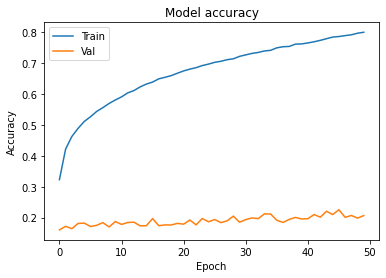

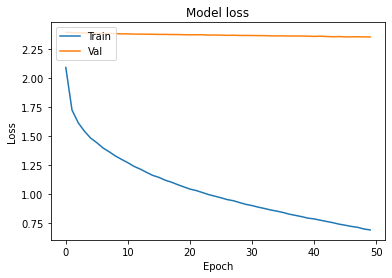

In [64]:
plot_curves(history)

In [65]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=1, verbose=1)

Train on 50000 samples
50000/50000 [==============================] - 17s 346us/sample - loss: 0.7390 - sparse_categorical_accuracy: 0.7785


              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1074
           1       0.62      0.82      0.71       753
           2       0.40      0.70      0.51       574
           3       0.44      0.47      0.45       937
           4       0.44      0.72      0.55       615
           5       0.72      0.41      0.52      1757
           6       0.63      0.84      0.72       751
           7       0.66      0.71      0.68       924
           8       0.77      0.76      0.76      1012
           9       0.89      0.55      0.68      1603

    accuracy                           0.63     10000
   macro avg       0.63      0.66      0.63     10000
weighted avg       0.67      0.63      0.63     10000

0.6261


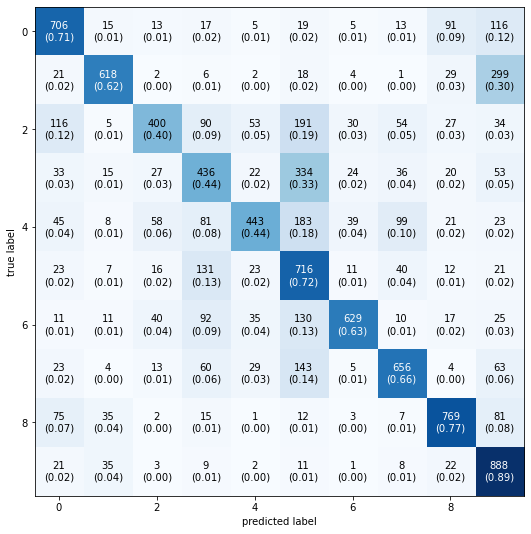

In [66]:
y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(9,9), show_normed=True)
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))